# HFA Regressions
Created: 04/08/24 \
Updated: 06/14/2024


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir = f'{base_dir}ephys_analysis/results/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

06152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *


In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
subj_ids


['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS028',
 'MS029',
 'MS030',
 'MS033',
 'MS035',
 'MS041',
 'MS043',
 'MS048',
 'MS050',
 'DA8',
 'DA023',
 'DA026',
 'DA037']

In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df

subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4

# Load data
- First run - load all power_epochs data, after just save as pickle dict
- Get subj metadata for regression dfs + compute logRT & logRT_t1

In [7]:
# #### Try Beta Power 
# all_subj_hfa_power = {}
# all_subj_metadata   = {}

# hfa_freqs = [70,200]

# # load pow epochs data 
# for subj_id in subj_ids: 
#     # load power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
#     power_epochs = power_epochs.crop(tmin=0,tmax=2.0,include_tmax=True)
#     all_subj_metadata[subj_id] = power_epochs.metadata.copy()
    
#     # extract power df with mean beta power for each epoch for each elec 
#     power_df = power_epochs.to_data_frame()
#     del power_epochs 
#     hfa_power_df = power_df[(power_df.freq >= hfa_freqs[0])&(power_df.freq <= hfa_freqs[1])].groupby(
#         ['epoch']).agg('mean').reset_index()
#     del power_df 
#     all_subj_hfa_power[subj_id] = hfa_power_df
#     del hfa_power_df
    
    
# # create a binary pickle file 
# pickle.dump(all_subj_hfa_power,open(f'{save_dir}all_subj_hfa_power.pkl',"wb"))
# # pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata.pkl',"wb"))

    

In [7]:
# paths = glob(f'{save_dir}all_subj_hfa_power_*.pkl')
# load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
#                         for path in paths]))

all_subj_hfa_power = pickle.load(open(f'{save_dir}all_subj_hfa_power.pkl','rb'))
all_subj_metadata = pickle.load(open(f'{save_dir}regression_data/all_subj_metadata.pkl','rb'))

# all_subj_hfa_power

In [8]:
### update metadata - zscore continuous regressors + add RT info

for subj_id in subj_ids:
    subj_df         = all_subj_metadata[subj_id]
    rounds_t1       = subj_df.Round.tolist()[1:]
    logRT_list      = np.log(subj_df['RT']).tolist() # take log of RT
    logRT_t1_list   = logRT_list[1:] # get logRT_t1
    GambleChoice_t1 = subj_df.GambleChoice.tolist()[1:]
    GambleEV_t1     = subj_df.GambleEV.tolist()[1:]
    TrialType_t1    = subj_df.TrialType.tolist()[1:]
    TrialEV         = subj_df.GambleEV - subj_df.SafeBet
    TrialEV_t1      = TrialEV[1:].tolist()
    rounds_t1.append(np.nan)
    logRT_t1_list.append(np.nan) # add nan to logRT_t1 (no t1 for last round)
    GambleChoice_t1.append(np.nan)
    GambleEV_t1.append(np.nan)
    TrialType_t1.append(np.nan) 
    TrialEV_t1.append(np.nan)
    subj_df['logRT']           = logRT_list
    subj_df['logRT_t1']        = logRT_t1_list
    subj_df['Round_t1']        = rounds_t1
    subj_df['GambleChoice_t1'] = GambleChoice_t1
    subj_df['GambleEV_t1']     = GambleEV_t1
    subj_df['TrialType_t1']    = TrialType_t1
    subj_df['TrialEV']         = TrialEV
    subj_df['TrialEV_t1']      = TrialEV_t1
    subj_df['bdi']             = subj_info_df.bdi[subj_info_df.subj_id==subj_id].values[0]
    subj_df['subj_id']         = subj_id
    
    # update metadata
    all_subj_metadata[subj_id] = subj_df
    
    
pickle.dump(all_subj_metadata,open(f'{save_dir}regression_data/all_subj_metadata_clean.pkl',"wb"))
    


In [9]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])


#### add roi info to master df 
hfa_master_df = []


# variables to zscore after data cleaning - 
continuous_regressors = ['GambleEV','GambleEV_t1','SafeBet','Profit','TotalProfit','RPE',
                         'decisionCPE', 'decisionRegret','decisionRelief','TrialEV','TrialEV_t1']

for subj_id,pow_df in zip(all_subj_hfa_power.keys(),all_subj_hfa_power.values()):
    
     # reshape pow_df 
        pow_reg_df = pow_df.melt(id_vars=['epoch','freq'],
                                    value_vars=pow_df.columns.drop(['epoch','time','freq']).tolist().copy(),
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)

        pow_reg_df['subj_id'] = subj_id # add subj_id to df values
        # reshape metadata df 
        metadata_df = all_subj_metadata[subj_id].reset_index()
        metadata_df = metadata_df.rename(columns={'index':'epoch'})

        # merge pow and metadata dfs keeping epoch as index 
        subj_regression_df = pd.merge(pow_reg_df, metadata_df,left_on=['epoch','subj_id'],
                                    right_on=['epoch','subj_id']).reset_index(drop=True).set_index('epoch')
        
        subj_regression_df['epoch_num'] = subj_regression_df.index # keep epoch as a column

        # add roi info 
        subj_epochs = pow_reg_df.epoch.unique()
        # extract roi_reref_labels_df for each subj 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        # add epochs to df - repeat each elec id for every epoch to join with master df 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        subj_roi_reref_labels = (pd.concat([subj_roi_reref_labels]*len(subj_epochs),
                                keys = subj_epochs,
                                names = ['epoch',None])).reset_index(level=1,drop=True) #make sure epochs are the index
        subj_roi_reref_labels['epoch_num'] = subj_roi_reref_labels.index

        # create unique reref ch id for regression
        subj_roi_reref_labels['unique_reref_ch'] = subj_roi_reref_labels[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)

        # merge regression df with roi reref info df  
        subj_regression_df = pd.merge(subj_regression_df, subj_roi_reref_labels,left_on=['subj_id',
                                    'reref_ch_names','epoch_num'],right_on=['subj_id',
                                    'reref_ch_names','epoch_num']).reset_index(drop=True).set_index('epoch_num')
        
        subj_regression_df['epoch'] = subj_regression_df.index
        
        ### cleaning within subject BEFORE zscoring regressors! 
        
        # remove trials where RT is too fast (random choice)
        subj_regression_df = subj_regression_df[subj_regression_df.RT>0.3]
        # remove trials where there is no choice at trial t
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice=='gamble') | 
                                                (subj_regression_df.GambleChoice == 'safe')].reset_index(drop=True)
        # remove trials where there is no choice for trial t1 (RT_t1 is nonsense)
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice_t1=='gamble') | 
                                                (subj_regression_df.GambleChoice_t1 == 'safe')].reset_index(drop=True)
        # remove trials where there is no outcome
        subj_regression_df = subj_regression_df[(subj_regression_df.Outcome=='good') | 
                                                (subj_regression_df.Outcome == 'bad')].reset_index(drop=True)
        # remove epoch 76 bc photodiode times are not correct at breakpoint 
        subj_regression_df = subj_regression_df[subj_regression_df.Round != 76]
        # remove trials where logRT_t1 is inf or -inf (means RT = 0)
        subj_regression_df = subj_regression_df[~np.isinf(subj_regression_df.logRT_t1)]
        # format GambleChoice + TrialType vars as categories 
        subj_regression_df['GambleChoice']    = subj_regression_df['GambleChoice'].astype('category')
        subj_regression_df['GambleChoice_t1'] = subj_regression_df['GambleChoice_t1'].astype('category')
        subj_regression_df['TrialType']       = subj_regression_df['TrialType'].astype('category')
        subj_regression_df['TrialType_t1']    = subj_regression_df['TrialType_t1'].astype('category')
        # make sure Round_t1 is an integer
        subj_regression_df['Round_t1']        = subj_regression_df['Round_t1'].astype('Int64')
        
        # zscore continuous regressors AFTER removing bad trials!! 
        for reg in continuous_regressors:
            subj_regression_df[reg] = norm_zscore(subj_regression_df[reg].values) # zscore is /2std

        hfa_master_df.append(subj_regression_df)


    
    
hfa_master_df = pd.concat(hfa_master_df)   
# reorder columns 
hfa_master_df = hfa_master_df[['subj_id','bdi','epoch','freq','reref_ch_names','band_pow','unique_reref_ch',
                                 'roi','hemi','ch_label4roi','ch_type4roi','loc4roi','Round', 'Round_t1',
                                 'logRT_t1','logRT','RT','TrialType','TrialType_t1','GambleChoice',
                                 'GambleChoice_t1','GambleEV', 'GambleEV_t1','SafeBet','TrialEV','TrialEV_t1',
                                 'Profit','TotalProfit','RPE','decisionCPE', 'decisionRegret','decisionRelief']]



In [10]:
# hfa_master_df.to_csv(f'{save_dir}hfa_master_df.csv')
hfa_master_df

subj_id  bdi  epoch        freq reref_ch_names  band_pow  \
0      MS002   14      0  118.986976  lacas1-lacas2  0.069986   
1      MS002   14      0  118.986976  lacas2-lacas3 -0.012389   
2      MS002   14      0  118.986976  lacas3-lacas4 -0.051644   
3      MS002   14      0  118.986976  lacas4-lacas5 -0.096877   
4      MS002   14      0  118.986976  lacas5-lacas6 -0.192916   
...      ...  ...    ...         ...            ...       ...   
3748   DA037    4    148  118.986976  rpins1-rpins2 -0.703054   
3749   DA037    4    148  118.986976  rpins2-rpins3 -0.668863   
3750   DA037    4    148  118.986976  rpins3-rpins4  0.086863   
3751   DA037    4    148  118.986976  rpins4-rpins5 -0.004322   
3752   DA037    4    148  118.986976      rmc7-rmc8 -0.154669   

          unique_reref_ch    roi hemi ch_label4roi  ... GambleEV_t1   SafeBet  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ...   -0.406880 -0.007878   
1     MS002_lacas2-lacas3    acc    l       lacas2  ...   -0.406880 -0.007878   
2     MS002_lacas3-lacas4    acc    l       lacas3  ...   -0.406880 -0.007878   
3     MS002_lacas4-lacas5    acc    l       lacas4  ...   -0.406880 -0.007878   
4     MS002_lacas5-lacas6    acc    l       lacas5  ...   -0.406880 -0.007878   
...                   ...    ...  ...          ...  ...         ...       ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...    0.012054  0.863812   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...    0.012054  0.863812   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...    0.012054  0.863812   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...    0.012054  0.863812   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...    0.012054  0.863812   

       TrialEV  TrialEV_t1    Profit  TotalProfit       RPE decisionCPE  \
0    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
1    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
2    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
3    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
4    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
...        ...         ...       ...          ...       ...         ...   
3748  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3749  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3750  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3751  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3752  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   

     decisionRegret decisionRelief  
0         -0.287638      -0.392122  
1         -0.287638      -0.392122  
2         -0.287638      -0.392122  
3         -0.287638      -0.392122  
4         -0.287638      -0.392122  
...             ...            ...  
3748      -0.291207      -0.317739  
3749      -0.291207      -0.317739  
3750      -0.291207      -0.317739  
3751      -0.291207      -0.317739  
3752      -0.291207      -0.317739  

[250433 rows x 32 columns]

In [11]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
acc              193
ofc              192
sts              151
hpc              135
amy              109
dlpfc            102
stg              100
vlpfc             76
smg               66
ains              64
thalamus          58
pins              57
mtg               54
mcc               28
phg               25
parietal          24
temporal pole     24
motor             19
fusiform          19
occipital         19
vmpfc             18
angular           14
itg               13
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
print(hfa_master_df.band_pow.max(),hfa_master_df.band_pow.mean(),hfa_master_df.band_pow.std(),hfa_master_df.band_pow.min())


5.328407873338229 -0.010398680513200021 0.1650100098465057 -0.9549933481961362


In [13]:
hfa_reg_df = hfa_master_df.copy()
hfa_reg_df.roi.unique().tolist()

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 'mtg',
 'ofc',
 'pins',
 'dlpfc',
 'motor',
 'vmpfc',
 'somat',
 'phg',
 nan,
 'smg',
 'stg',
 'fusiform',
 'mcc',
 'premotor',
 'temporal pole',
 'itg',
 'parietal',
 'angular',
 'thalamus',
 'occipital',
 'caudate',
 'pcc']

# Mixed effects with just CPE 


In [43]:
cpe_hfa_model = smf.mixedlm(
    formula='band_pow ~ 1 + decisionCPE',
    re_formula = ' decisionCPE',
    data = hfa_reg_df,groups=hfa_reg_df['unique_reref_ch'], missing='drop')
cpe_hfa_model_fit = cpe_hfa_model.fit()
print(cpe_hfa_model_fit.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    band_pow   
No. Observations:    250396     Method:                REML       
No. Groups:          1813       Scale:                 0.0232     
Min. group size:     65         Log-Likelihood:        112751.8654
Max. group size:     148        Converged:             Yes        
Mean group size:     138.1                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               -0.010    0.002 -6.506 0.000 -0.013 -0.007
decisionCPE              0.004    0.001  5.593 0.000  0.002  0.005
Group Var                0.004    0.001                           
Group x decisionCPE Cov  0.000    0.000                           
decisionCPE Var          0.000    0.000                           



# Feature Selection

In [75]:
vif_scores(hfa_reg_df,['GambleChoice','TrialType','TotalProfit','TrialEV','decisionCPE']) #,'logRT_t1'


feature       VIF
0  GambleChoice  1.810203
1     TrialType  1.821691
2   TotalProfit  1.010838
3       TrialEV  1.060041
4   decisionCPE  1.005842

In [76]:
######## make all possible variable combinations for regressions 
main_var  = 'decisionCPE'
iter_vars = ['C(GambleChoice)','C(TrialType)','TotalProfit','TrialEV']


In [77]:
var_combos = [[v,main_var] for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+[main_var] for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)


var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'C(TrialType)' not in combo)|
              ('C(GambleChoice)' not in combo and 'C(TrialType)' in combo)|
              ('C(GambleChoice)'not in combo and 'C(TrialType)' not in combo)]



var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'TrialEV' not in combo)|
              ('C(GambleChoice)' not in combo and 'TrialEV' in combo)|('C(GambleChoice)'not in combo 
                                                                       and 'TrialEV' not in combo)]


var_combos = [combo for combo in var_combos if ('TrialEV' in combo and 'C(TrialType)' not in combo)|
              ('TrialEV' not in combo and 'C(TrialType)' in combo)|('TrialEV'not in combo 
                                                                    and 'C(TrialType)' not in combo)]
var_combos

[['C(GambleChoice)', 'decisionCPE'],
 ['C(TrialType)', 'decisionCPE'],
 ['TotalProfit', 'decisionCPE'],
 ['TrialEV', 'decisionCPE'],
 ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'],
 ['C(TrialType)', 'TotalProfit', 'decisionCPE'],
 ['TotalProfit', 'TrialEV', 'decisionCPE']]

In [ ]:
# import time 
start = time.time() # start timer

all_models = {}
no_conv = []

for test_vars in var_combos:
    model_key = ''.join(test_vars[:-1]) ### make string of covariate var names to use as dict key
    model_fit = fit_mixed_model(hfa_reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
    # check if model converged
    if model_fit.converged:
        print(model_key,' converged!')
        all_models[model_key] = {'var_list':test_vars,
                                 'fe_coeff':model_fit.params.to_numpy()[1:len(model_fit.fe_params)],
                                 'fe_pvals':model_fit.pvalues.to_numpy()[1:len(model_fit.fe_params)],
                                 'rsq':compute_marginal_rsq(model_fit),
                                 'bic':model_fit.bic}
    else:
        print(model_key,' did not converge :(')
        no_conv.append(model_key)
    del model_fit

end = time.time()
print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)    

In [78]:
print(no_conv)

[]


In [79]:
all_models

{'C(GambleChoice)': {'var_list': ['C(GambleChoice)', 'decisionCPE'],
  'fe_coeff': array([0.0037469 , 0.00355782]),
  'fe_pvals': array([2.97540529e-05, 7.17071243e-08]),
  'rsq': 0.7572629925990746,
  'bic': -225976.50534314316},
 'C(TrialType)': {'var_list': ['C(TrialType)', 'decisionCPE'],
  'fe_coeff': array([ 0.0003818 , -0.00015502,  0.00365994]),
  'fe_pvals': array([6.70634275e-01, 8.40795643e-01, 2.90593406e-08]),
  'rsq': 0.7744242259595777,
  'bic': -225485.45257754874},
 'TotalProfit': {'var_list': ['TotalProfit', 'decisionCPE'],
  'fe_coeff': array([-0.01046128,  0.00440411]),
  'fe_pvals': array([3.22782539e-12, 7.88885475e-12]),
  'rsq': 0.49521965963387776,
  'bic': -231697.8693736226},
 'TrialEV': {'var_list': ['TrialEV', 'decisionCPE'],
  'fe_coeff': array([-0.00013981,  0.00366981]),
  'fe_pvals': array([8.36572643e-01, 2.86383744e-08]),
  'rsq': 0.8303840807721103,
  'bic': -225448.61142119978},
 'C(GambleChoice)TotalProfit': {'var_list': ['C(GambleChoice)',
   'Tot

In [80]:
model_summary = {key:all_models[key]['bic'] for key in all_models.keys()}
model_summary

{'C(GambleChoice)': -225976.50534314316,
 'C(TrialType)': -225485.45257754874,
 'TotalProfit': -231697.8693736226,
 'TrialEV': -225448.61142119978,
 'C(GambleChoice)TotalProfit': -232322.6372848588,
 'C(TrialType)TotalProfit': -231842.03312703088,
 'TotalProfitTrialEV': -231695.7618481812}

In [81]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])


C(GambleChoice)TotalProfit


In [82]:
bic_list = [model_summary[key] for key in model_summary.keys()]
bic_list.sort()

ordered_list = [list(model_summary.keys())[np.where(list(model_summary.values()) == bic)[0][0]] for bic in bic_list]
ordered_list


['C(GambleChoice)TotalProfit',
 'C(TrialType)TotalProfit',
 'TotalProfit',
 'TotalProfitTrialEV',
 'C(GambleChoice)',
 'C(TrialType)',
 'TrialEV']

In [83]:
[(key,all_models[key]['fe_pvals'][-1]) for key in ordered_list]  


[('C(GambleChoice)TotalProfit', 3.288211374657947e-11),
 ('C(TrialType)TotalProfit', 8.207254045059996e-12),
 ('TotalProfit', 7.888854750119742e-12),
 ('TotalProfitTrialEV', 1.3440977924011098e-11),
 ('C(GambleChoice)', 7.170712434687785e-08),
 ('C(TrialType)', 2.905934063130104e-08),
 ('TrialEV', 2.863837440328106e-08)]

In [84]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])
print(np.min(list(model_summary.values())))

C(GambleChoice)TotalProfit
-232322.6372848588


In [85]:
list(all_models[list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]]]['fe_pvals'])


[1.6953442537883287e-05, 7.309961696774738e-12, 3.288211374657947e-11]

In [86]:
rsq_summary = {key:all_models[key]['rsq'] for key in all_models.keys()}
rsq_summary

{'C(GambleChoice)': 0.7572629925990746,
 'C(TrialType)': 0.7744242259595777,
 'TotalProfit': 0.49521965963387776,
 'TrialEV': 0.8303840807721103,
 'C(GambleChoice)TotalProfit': 0.46749308064237494,
 'C(TrialType)TotalProfit': 0.4655792969390296,
 'TotalProfitTrialEV': 0.4848820722581464}

In [87]:
sorted_rsq = list(rsq_summary.values()).copy()
sorted_rsq.sort(reverse=True)
sorted_rsq

[0.8303840807721103,
 0.7744242259595777,
 0.7572629925990746,
 0.49521965963387776,
 0.4848820722581464,
 0.46749308064237494,
 0.4655792969390296]

In [88]:
sorted_rsq_models = {f'{list(rsq_summary.keys())[np.where(list(rsq_summary.values()) == rsq)[0][0]]}':rsq for rsq in sorted_rsq}
sorted_rsq_models

{'TrialEV': 0.8303840807721103,
 'C(TrialType)': 0.7744242259595777,
 'C(GambleChoice)': 0.7572629925990746,
 'TotalProfit': 0.49521965963387776,
 'TotalProfitTrialEV': 0.4848820722581464,
 'C(GambleChoice)TotalProfit': 0.46749308064237494,
 'C(TrialType)TotalProfit': 0.4655792969390296}

In [89]:
list(zip(ordered_list,list(sorted_rsq_models.keys())))

[('C(GambleChoice)TotalProfit', 'TrialEV'),
 ('C(TrialType)TotalProfit', 'C(TrialType)'),
 ('TotalProfit', 'C(GambleChoice)'),
 ('TotalProfitTrialEV', 'TotalProfit'),
 ('C(GambleChoice)', 'TotalProfitTrialEV'),
 ('C(TrialType)', 'C(GambleChoice)TotalProfit'),
 ('TrialEV', 'C(TrialType)TotalProfit')]


# Model Evaluation
once you've selected the best ~3 models you need to evaluate the model output 
1. evaluate the model using cpd and/or generalized liklihood ratio test"
2. check fstats
3. tstat betas from zero 
4. visualization

In [41]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [93]:
final_vars = all_models[list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]]]['var_list']

final_vars

['C(GambleChoice)', 'TotalProfit', 'decisionCPE']

In [42]:
final_vars = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']

In [43]:
###### BEST MODEL 

final_fit = fit_mixed_model(hfa_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())

                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          band_pow   
No. Observations:          250396           Method:                      ML         
No. Groups:                1813             Scale:                       0.0222     
Min. group size:           65               Log-Likelihood:              116254.5496
Max. group size:           148              Converged:                   Yes        
Mean group size:           138.1                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.011    0.002 -7.109 0.000 -0.014 -0.008
C(GambleChoice)[T.safe]                    0.004    0.001  4.302 0.000  0.002  0.006
Tota

In [45]:
final_fit.bic

-232322.6372848588

In [44]:
mixed_effects_ftest_ttest(final_fit)

(        coef   std err         t         P>|t|  Conf. Int. Low  \
 c0  0.003916  0.000910  4.301645  1.695985e-05        0.002132   
 c1 -0.010361  0.001512 -6.851461  7.326741e-12       -0.013325   
 c2  0.004282  0.000646  6.633050  3.294859e-11        0.003017   
 
     Conf. Int. Upp.  
 c0         0.005700  
 c1        -0.007397  
 c2         0.005548  ,
 <class 'statsmodels.stats.contrast.ContrastResults'>
 <F test: F=136.66277244613767, p=0.0, df_denom=2.5e+05, df_num=13>)

In [46]:
fe_param_names = list(final_fit.fe_params.index)

In [47]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [hfa_reg_df.roi[hfa_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [48]:
plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.027091   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.007478   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.023420   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.020912   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.029386   
...      ...            ...                  ...        ...   
1808   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5  -0.011210   
1809   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.020740   
1810   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.065251   
1811   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.054896   
1812   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.027179   

      raw_C(GambleChoice)[T.safe]  raw_TotalProfit  raw_decisionCPE    roi  \
0                       -0.018575        -0.024900         0.001046    acc   
1                        0.000974        -0.013290        -0.002364  dmpfc   
2                       -0.009225        -0.035994        -0.001293    acc   
3                        0.004063        -0.031127        -0.000263    acc   
4                        0.013319        -0.034508        -0.003353  dmpfc   
...                           ...              ...              ...    ...   
1808                    -0.009240         0.007502        -0.000910    ofc   
1809                    -0.000734         0.005482         0.002989    ofc   
1810                     0.034791         0.007231         0.005653    ofc   
1811                     0.048548         0.004327         0.006960    ofc   
1812                     0.032363         0.010120         0.009220  vlpfc   

      bdi  
0      14  
1      14  
2      14  
3      14  
4      14  
...   ...  
1808    9  
1809    9  
1810    9  
1811    9  
1812    9  

[1813 rows x 9 columns]

In [49]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)

plot_data = plot_data[~plot_data.roi.isnull()]

In [50]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=1.314344353038825, pvalue=0.19029832708721015, df=192),
 'dmpfc': TtestResult(statistic=-1.1747705634703671, pvalue=0.24138597767578387, df=215),
 'hpc': TtestResult(statistic=-1.3227728477405434, pvalue=0.188163920002286, df=134),
 'sts': TtestResult(statistic=-2.456810162024573, pvalue=0.015158000230355037, df=150),
 'amy': TtestResult(statistic=1.1644259947513935, pvalue=0.24681716796310982, df=108),
 'parietal': TtestResult(statistic=-1.343352692358726, pvalue=0.19226329277890006, df=23),
 'angular': TtestResult(statistic=-1.3325053805713911, pvalue=0.20558053182868452, df=13),
 'stg': TtestResult(statistic=-1.73785766297754, pvalue=0.08534537728915693, df=99),
 'premotor': TtestResult(statistic=-0.21219880645169908, pvalue=0.8372586866417637, df=8),
 'mcc': TtestResult(statistic=1.021059261954972, pvalue=0.31628859534514053, df=27),
 'fusiform': TtestResult(statistic=-2.3123731351954313, pvalue=0.03279574323340583, df=18),
 'itg': TtestResult(statisti

In [51]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

{'acc': TtestResult(statistic=21.88923437391327, pvalue=4.518072286837193e-54, df=192),
 'dmpfc': TtestResult(statistic=19.69498935342437, pvalue=4.911528946254829e-50, df=215),
 'hpc': TtestResult(statistic=13.952403822500607, pvalue=6.954592708220517e-28, df=134),
 'sts': TtestResult(statistic=5.906079259259679, pvalue=2.2572343664260673e-08, df=150),
 'amy': TtestResult(statistic=17.673723728004052, pvalue=1.1930280616684212e-33, df=108),
 'parietal': TtestResult(statistic=3.890059674775734, pvalue=0.0007388687185315867, df=23),
 'angular': TtestResult(statistic=7.948258337538387, pvalue=2.4006304987080753e-06, df=13),
 'stg': TtestResult(statistic=7.588258812778889, pvalue=1.8088917656564324e-11, df=99),
 'premotor': TtestResult(statistic=4.130625617057723, pvalue=0.003295616998360701, df=8),
 'mcc': TtestResult(statistic=8.372858842657505, pvalue=5.534106395975586e-09, df=27),
 'fusiform': TtestResult(statistic=8.413662450584857, pvalue=1.1865531420020567e-07, df=18),
 'itg': Ttes

In [52]:
bonferr_alpha = 0.05/len(roi_order)
bonferr_alpha

0.005555555555555556

In [53]:
[(key,raw_roi_stats[key].pvalue) for key in raw_roi_stats.keys() if raw_roi_stats[key].pvalue < bonferr_alpha]

[('ofc', 6.817367113026989e-06)]

In [54]:
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


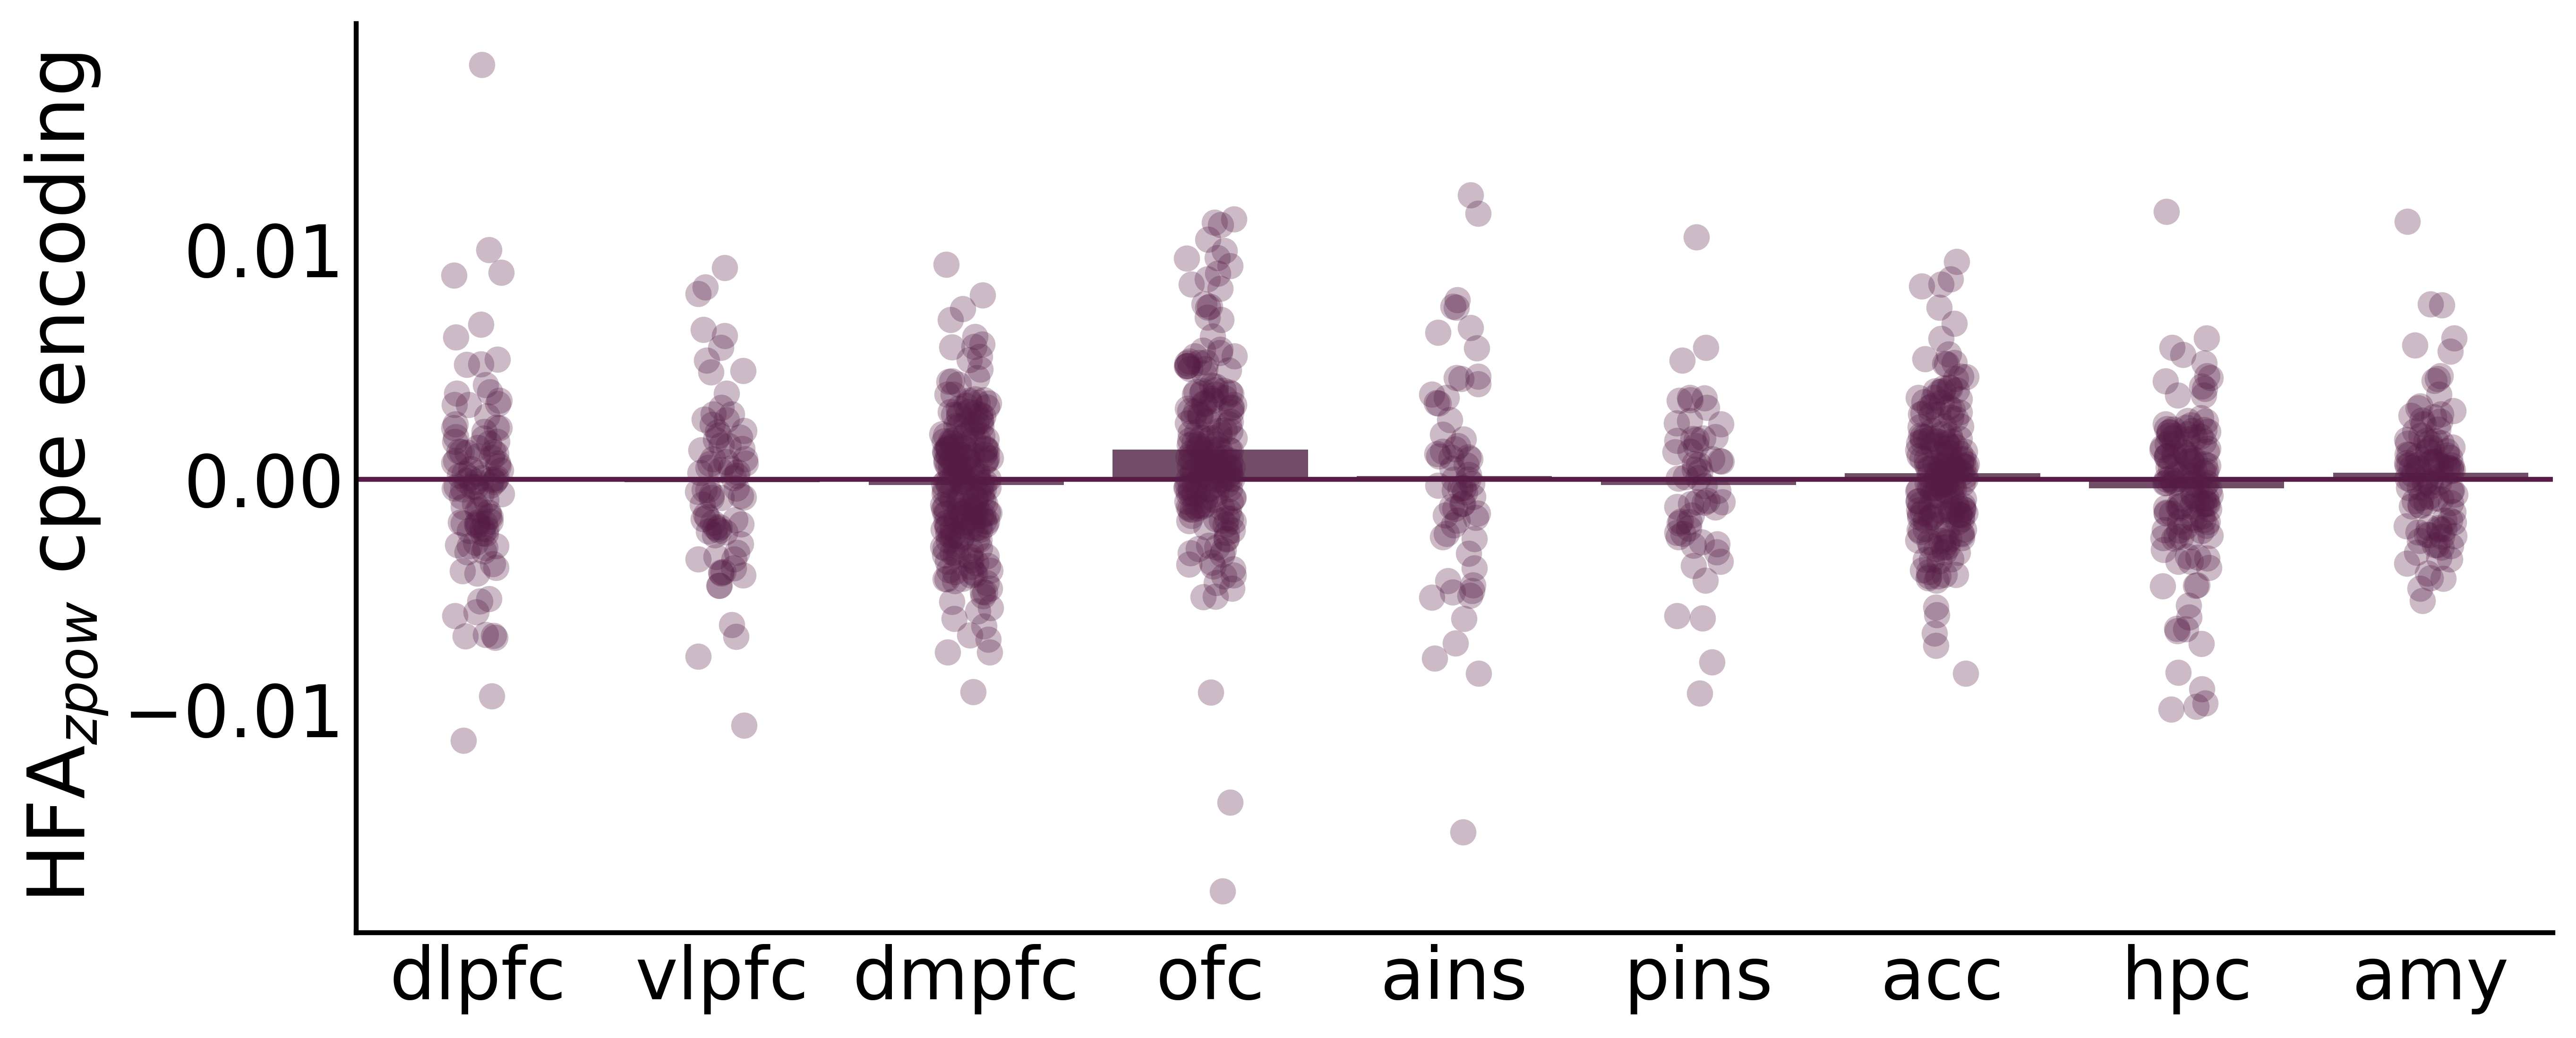

In [59]:
from matplotlib.ticker import StrMethodFormatter

sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(12, 5),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/hfa_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',

            y = 'raw_decisionCPE',
#             y='elec_bCPE',
            color = '#78496b',#78496b 997690
            saturation=.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE',
#               y='elec_bCPE',
              color = '#561C46',
              alpha=.3,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)
ax.set(xlabel=None)
plt.tick_params(length=0)
plt.ylabel('HFA'+r'$_{{{zpow}}}$'+' cpe encoding')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=6)

sns.despine()
    
plt.savefig(f'{fig_save_dir}HFA_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [333]:
rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.raw_decisionCPE)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
    if rho_p < bonferr_alpha: 
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)

acc pearsonr -0.12693070240655632 0.07856995211123673
dmpfc pearsonr -0.029720319564963776 0.6640276490080714
hpc pearsonr -0.26748367200129636 0.0017107533404911739
sts pearsonr -0.3168687786946235 7.369365619192075e-05
amy pearsonr -0.25522830154658693 0.007396284536839133
parietal pearsonr 0.12867428433911973 0.5490256935993016
angular pearsonr 0.26670287491317646 0.35667273104304537
stg pearsonr -0.17118951130838256 0.08857407172353152
premotor pearsonr -0.42137680783774273 0.25866449572596445
mcc pearsonr -0.20774564674127466 0.28878278594494716
fusiform pearsonr 0.19264132250413546 0.42944547324481885
itg pearsonr -0.39708273935581256 0.17911671044633048
mtg pearsonr -0.30058886048551214 0.027207073699591678
smg pearsonr 0.41601080967050225 0.0005127460436865381
phg pearsonr 0.11129380177714913 0.5963684594642196
temporal pole pearsonr -0.4107870647535554 0.04614970655580794
occipital pearsonr 0.5598874057088578 0.0126704848624458
somat pearsonr -0.48573922249837104 0.12984344170

In [334]:
sig_rho

[('hpc', -0.26748367200129636, 0.0017107533404911739),
 ('sts', -0.3168687786946235, 7.369365619192075e-05),
 ('smg', 0.41601080967050225, 0.0005127460436865381)]

In [335]:
rho_data['plot_p'] = [0.001 if roi.rho_p < 0.001 else np.round(roi.rho_p,4) for ix,roi in rho_data.iterrows()]

In [336]:
new_plot_ps = []
for p in rho_data['plot_p']:
    new_p = 0
    
    for ix,val in enumerate(str(p)):
        if val == '0':
            continue
        elif val == '.':
            continue
        else: 
#             print(ix,val)
            new_p = str(p)[:ix+1]
            break
            
            

    new_plot_ps.append(float(new_p))
#         print(val)
rho_data['round_p']   = new_plot_ps
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data

roi       rho     rho_p  plot_p  round_p  round_rho
0             acc -0.126931  0.078570  0.0786    0.070      -0.13
1           dmpfc -0.029720  0.664028  0.6640    0.600      -0.03
2             hpc -0.267484  0.001711  0.0017    0.001      -0.27
3             sts -0.316869  0.000074  0.0010    0.001      -0.32
4             amy -0.255228  0.007396  0.0074    0.007      -0.26
5        parietal  0.128674  0.549026  0.5490    0.500       0.13
6         angular  0.266703  0.356673  0.3567    0.300       0.27
7             stg -0.171190  0.088574  0.0886    0.080      -0.17
8        premotor -0.421377  0.258664  0.2587    0.200      -0.42
9             mcc -0.207746  0.288783  0.2888    0.200      -0.21
10       fusiform  0.192641  0.429445  0.4294    0.400       0.19
11            itg -0.397083  0.179117  0.1791    0.100      -0.40
12            mtg -0.300589  0.027207  0.0272    0.020      -0.30
13            smg  0.416011  0.000513  0.0010    0.001       0.42
14            phg  0.111294  0.596368  0.5964    0.500       0.11
15  temporal pole -0.410787  0.046150  0.0461    0.040      -0.41
16      occipital  0.559887  0.012670  0.0127    0.010       0.56
17          somat -0.485739  0.129843  0.1298    0.100      -0.49
18          dlpfc -0.051391  0.607976  0.6080    0.600      -0.05
19           pins  0.028541  0.833083  0.8331    0.800       0.03
20          motor -0.537184  0.017704  0.0177    0.010      -0.54
21            ofc  0.065941  0.363491  0.3635    0.300       0.07
22           ains -0.276012  0.027268  0.0273    0.020      -0.28
23          vlpfc  0.023577  0.839790  0.8398    0.800       0.02
24          vmpfc  0.098461  0.697503  0.6975    0.600       0.10
25       thalamus -0.009833  0.941601  0.9416    0.900      -0.01
26        caudate  0.143339  0.734899  0.7349    0.700       0.14

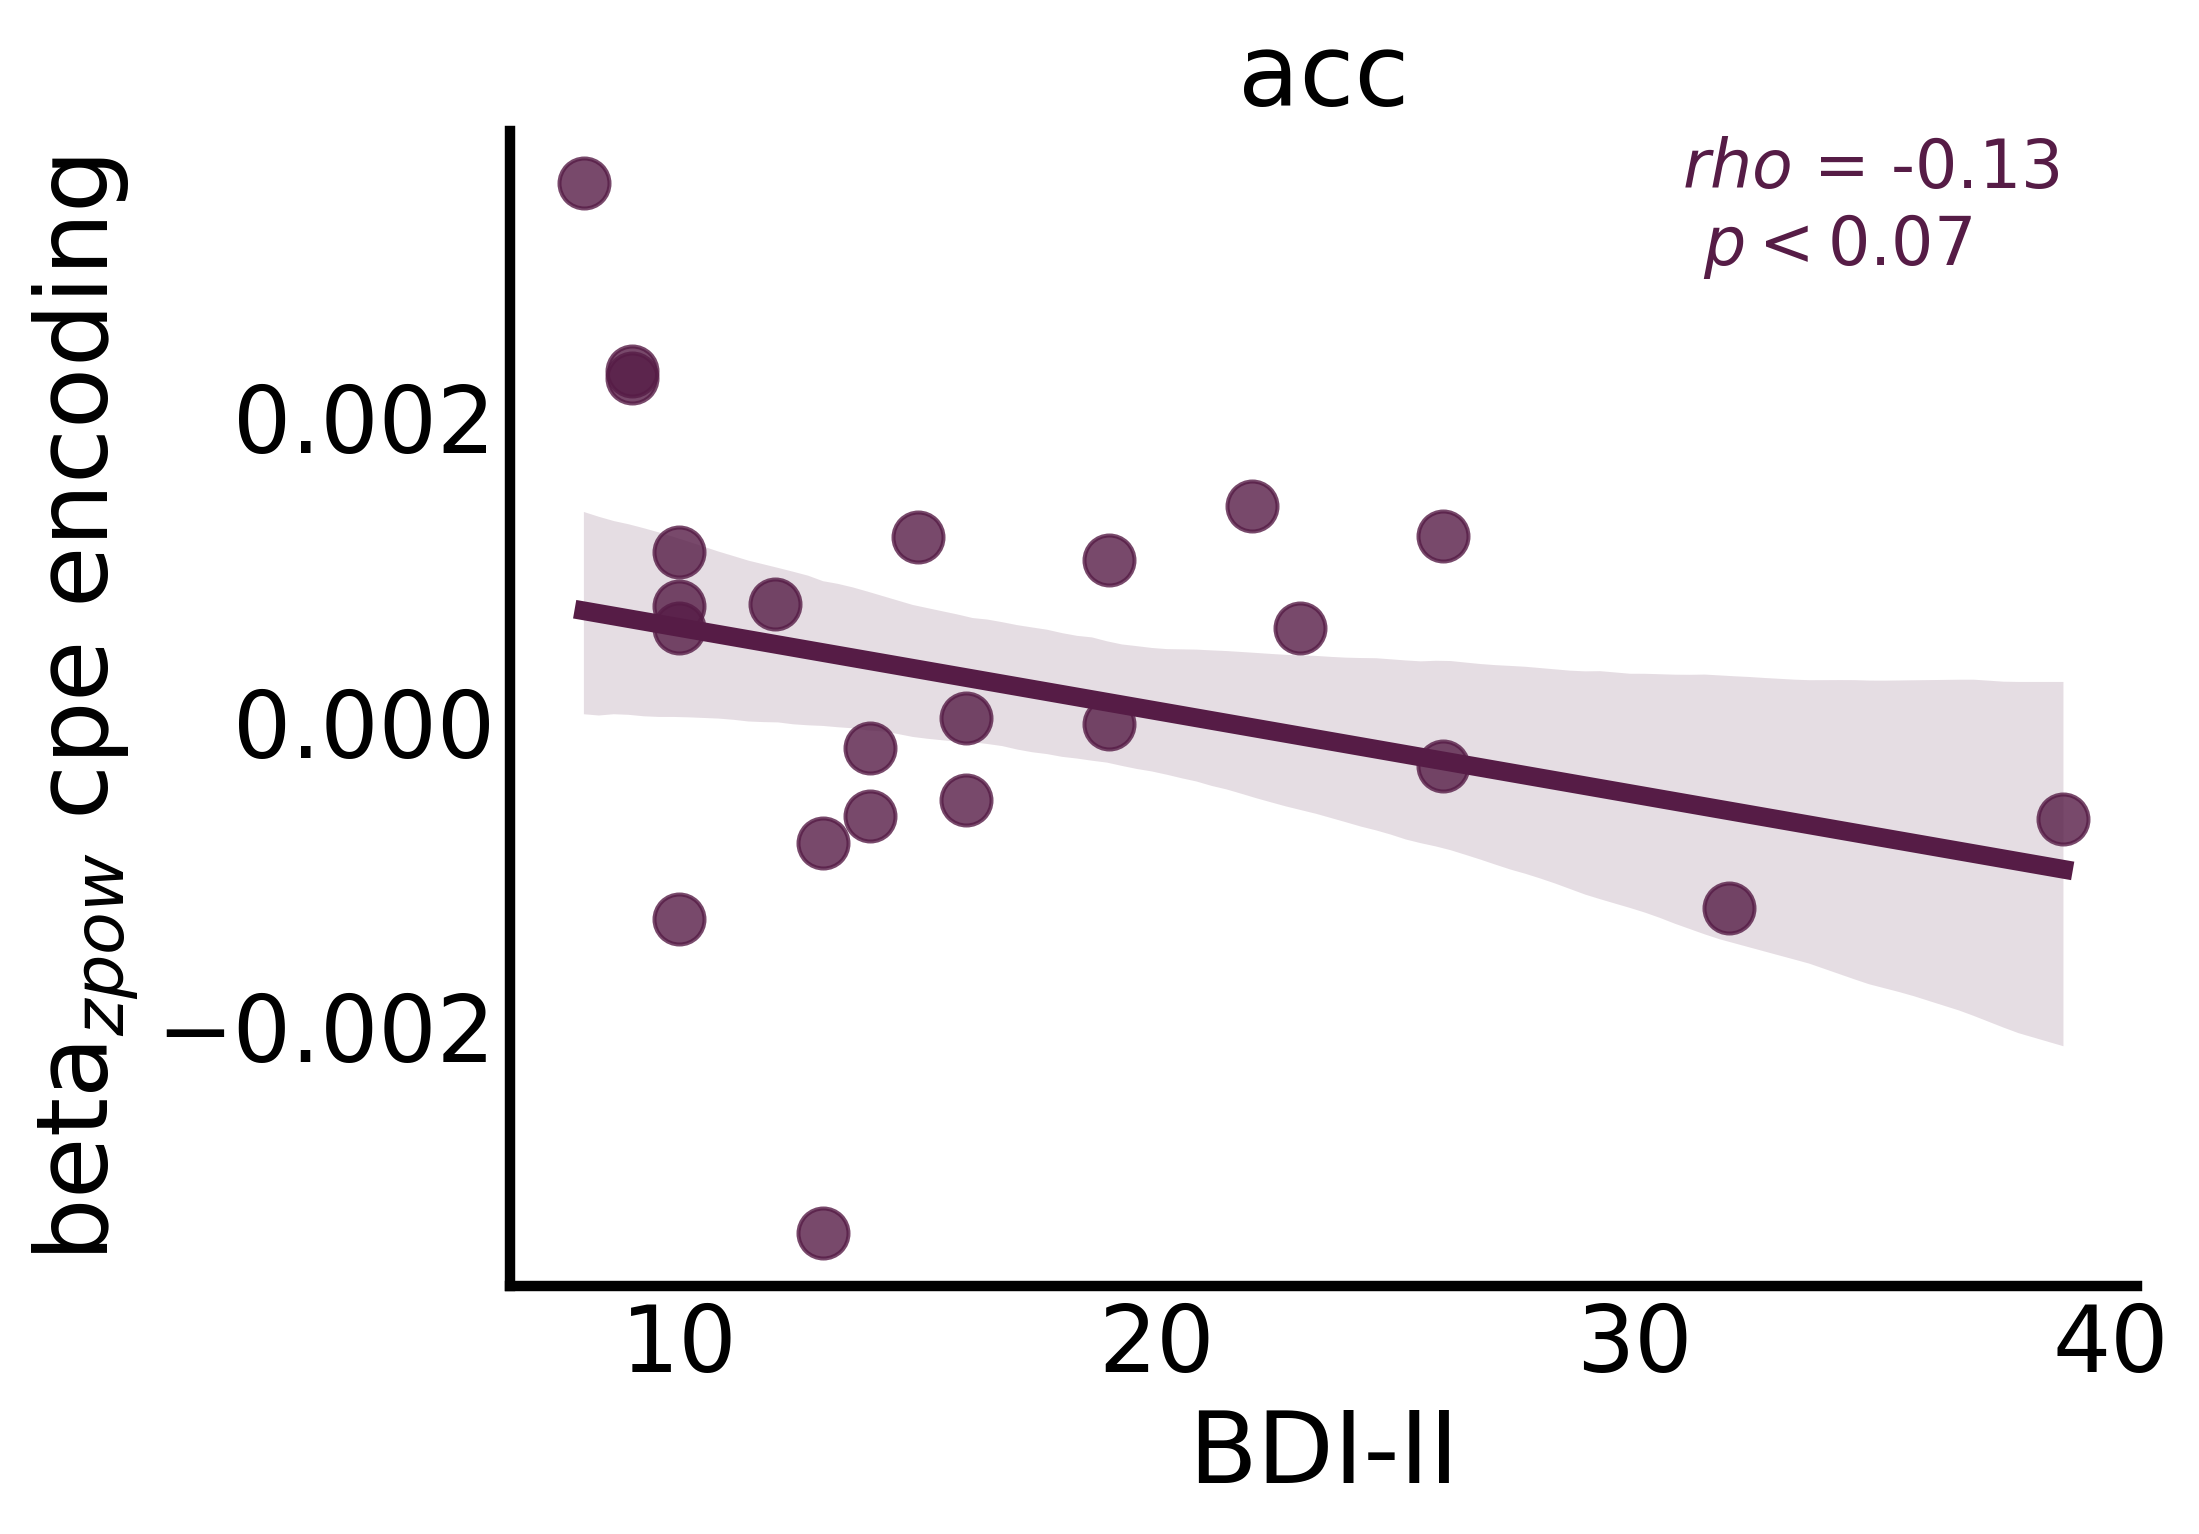

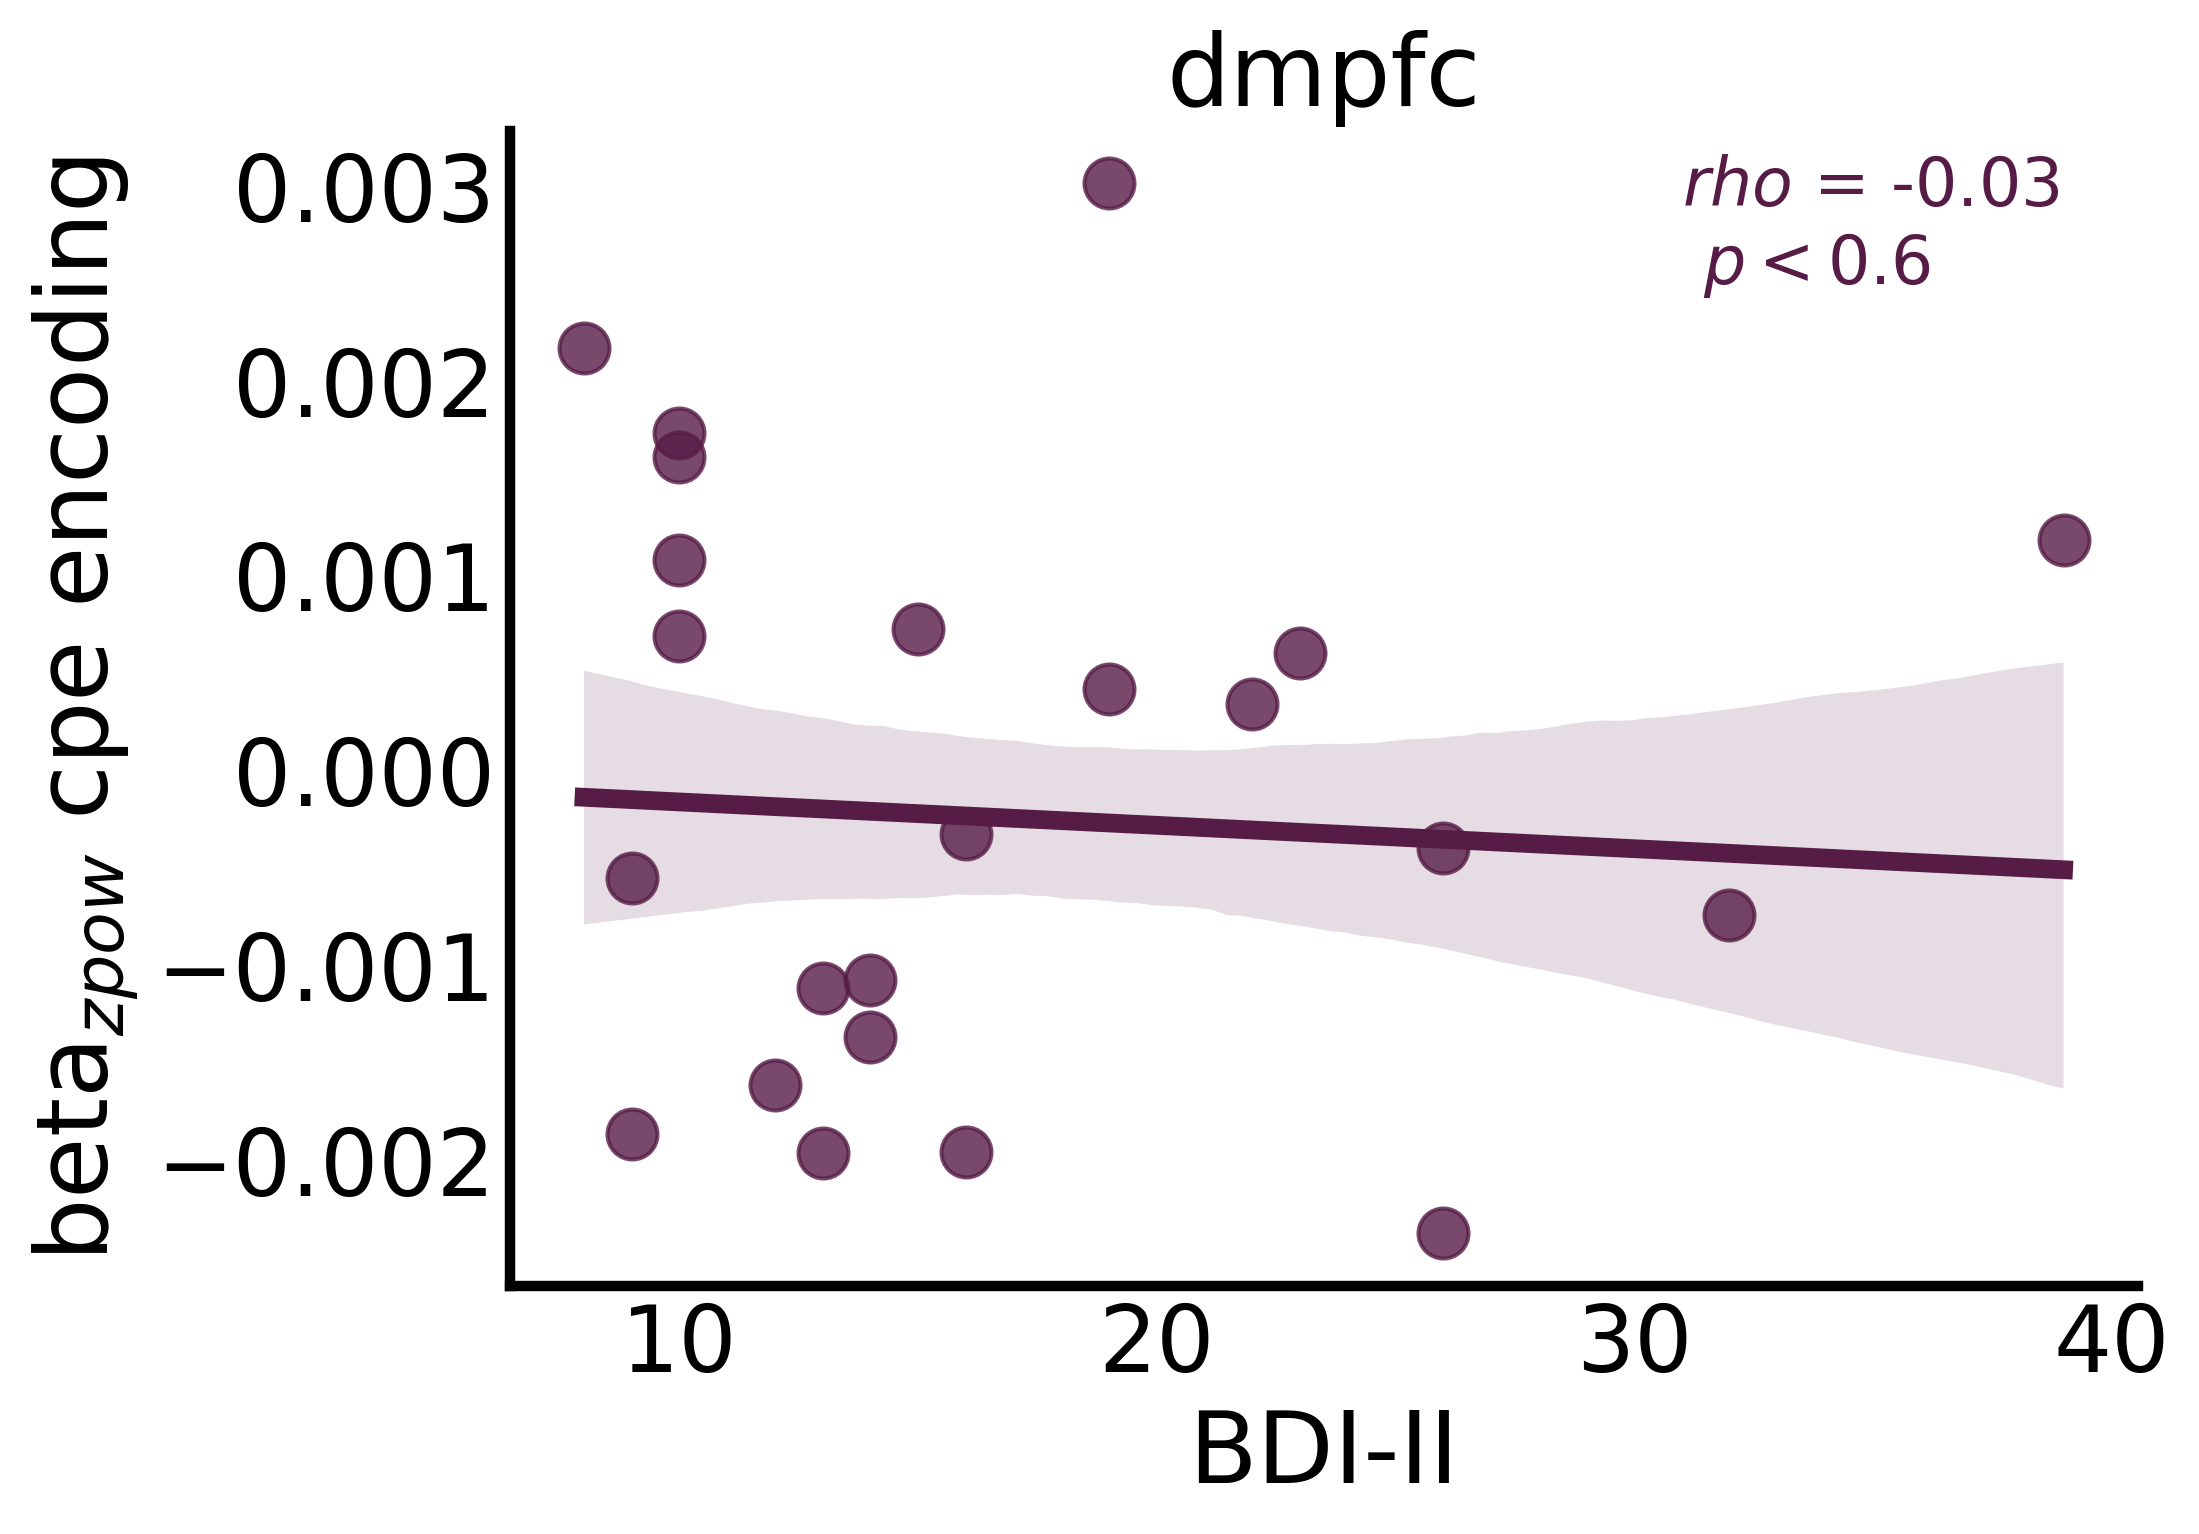

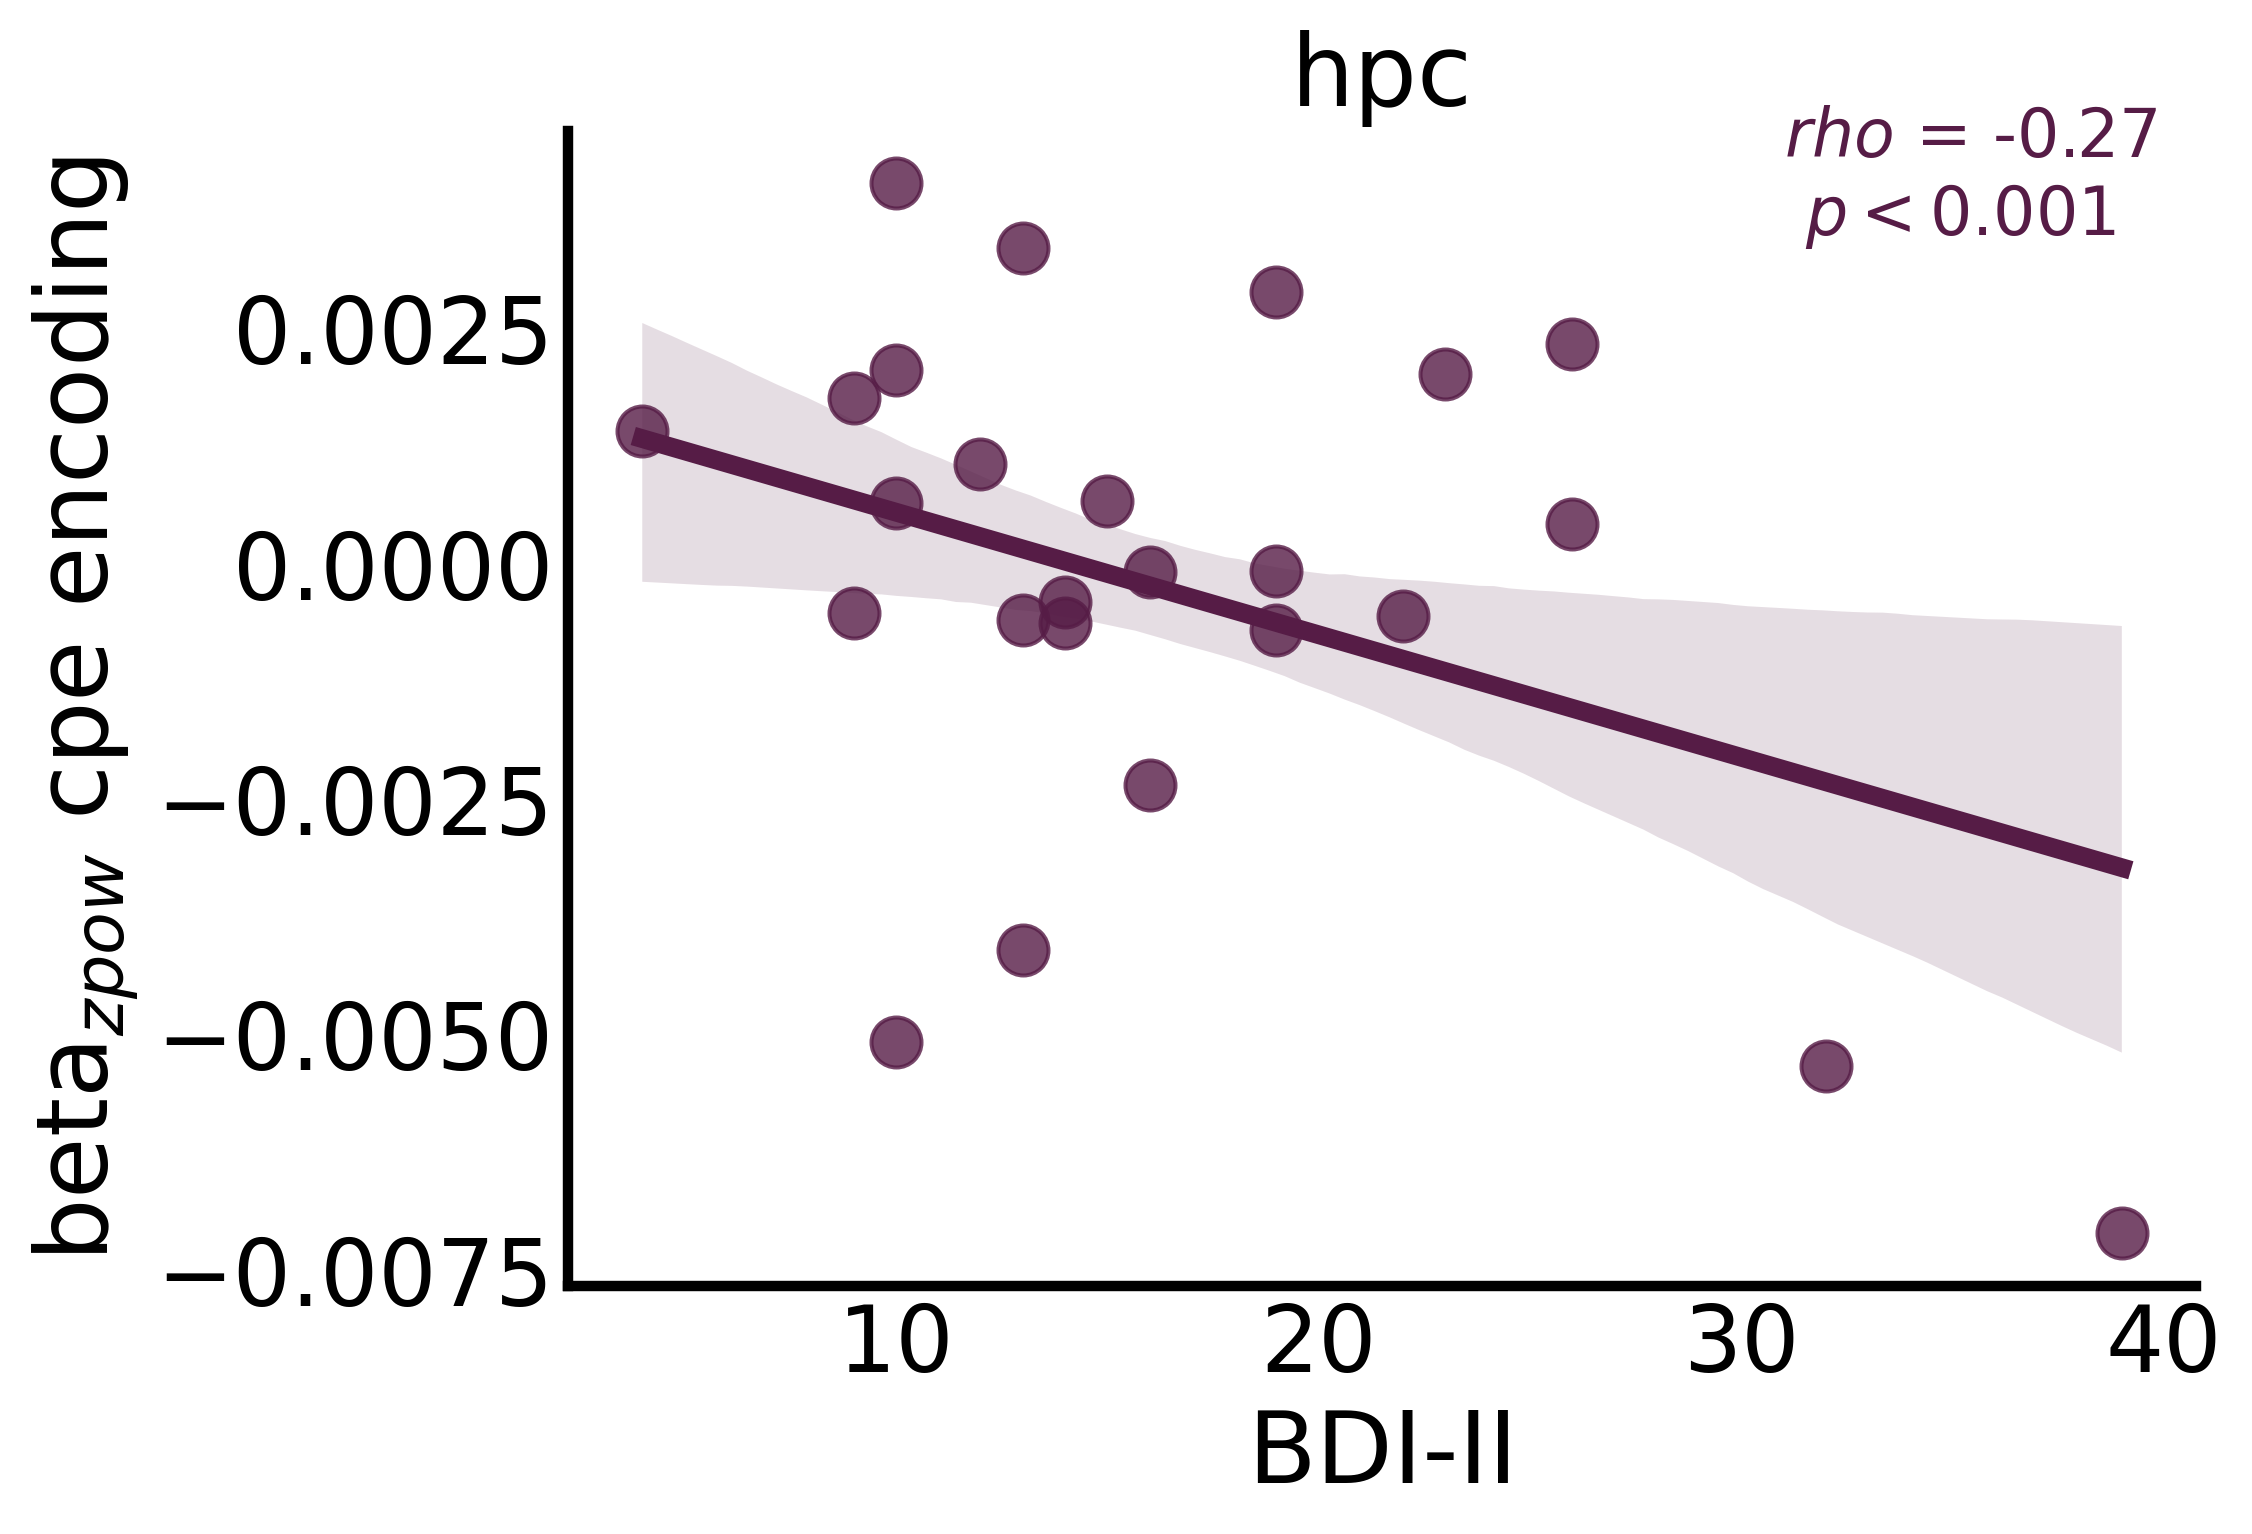

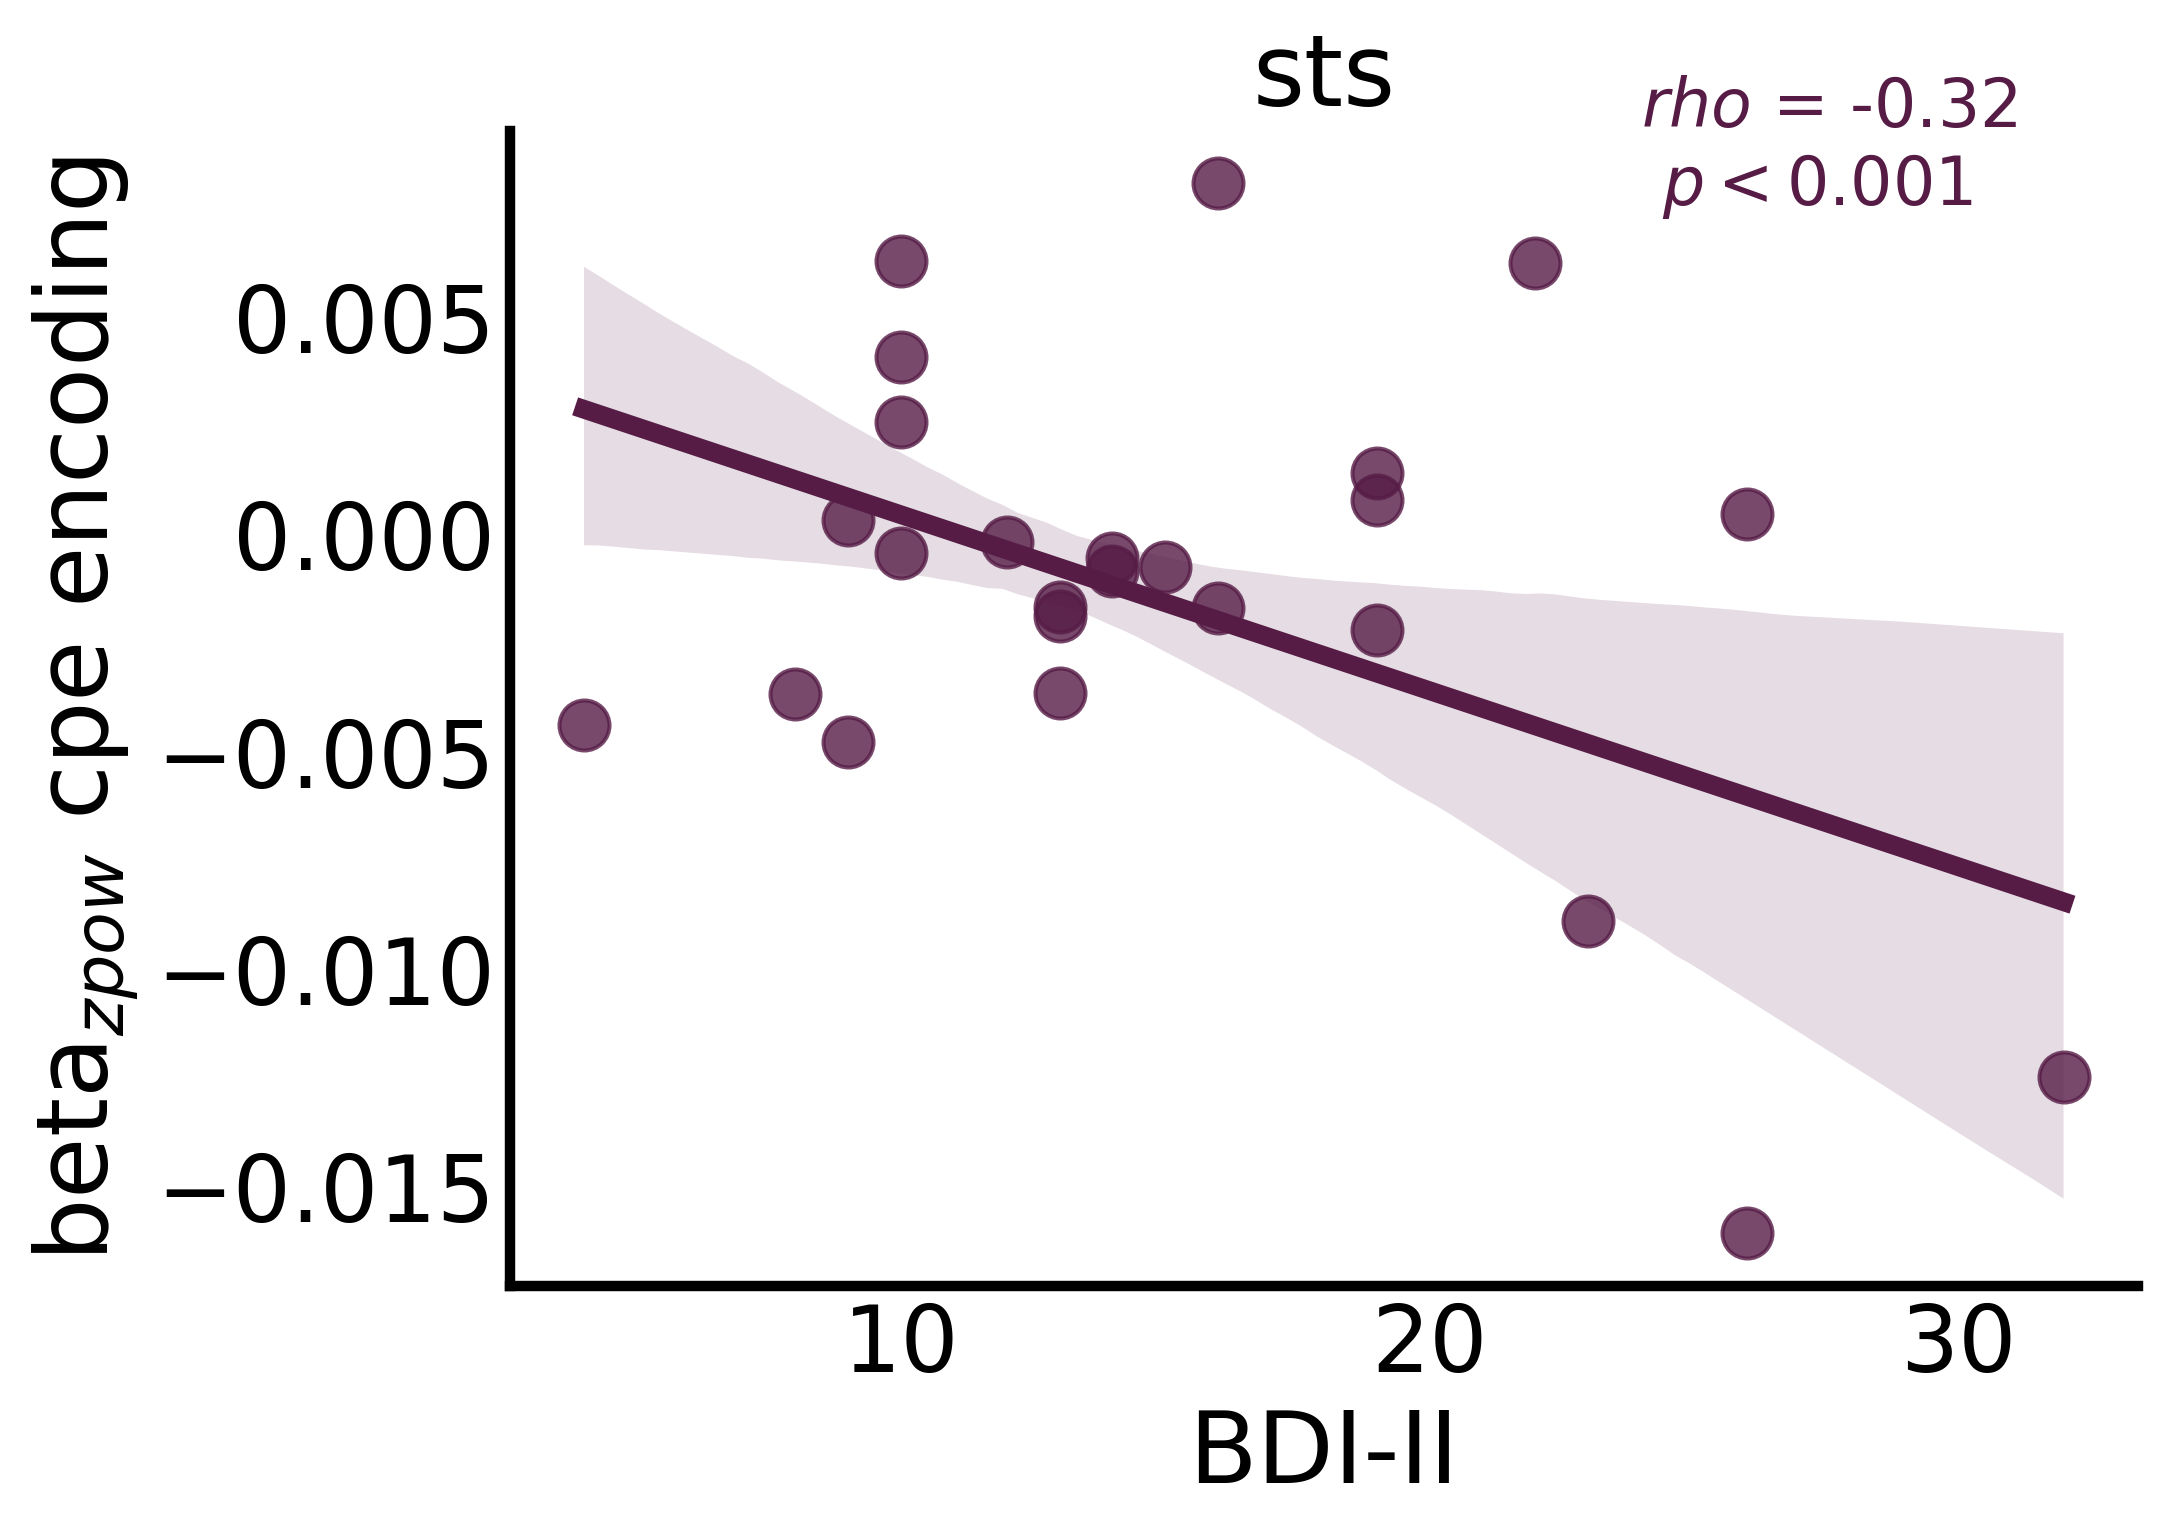

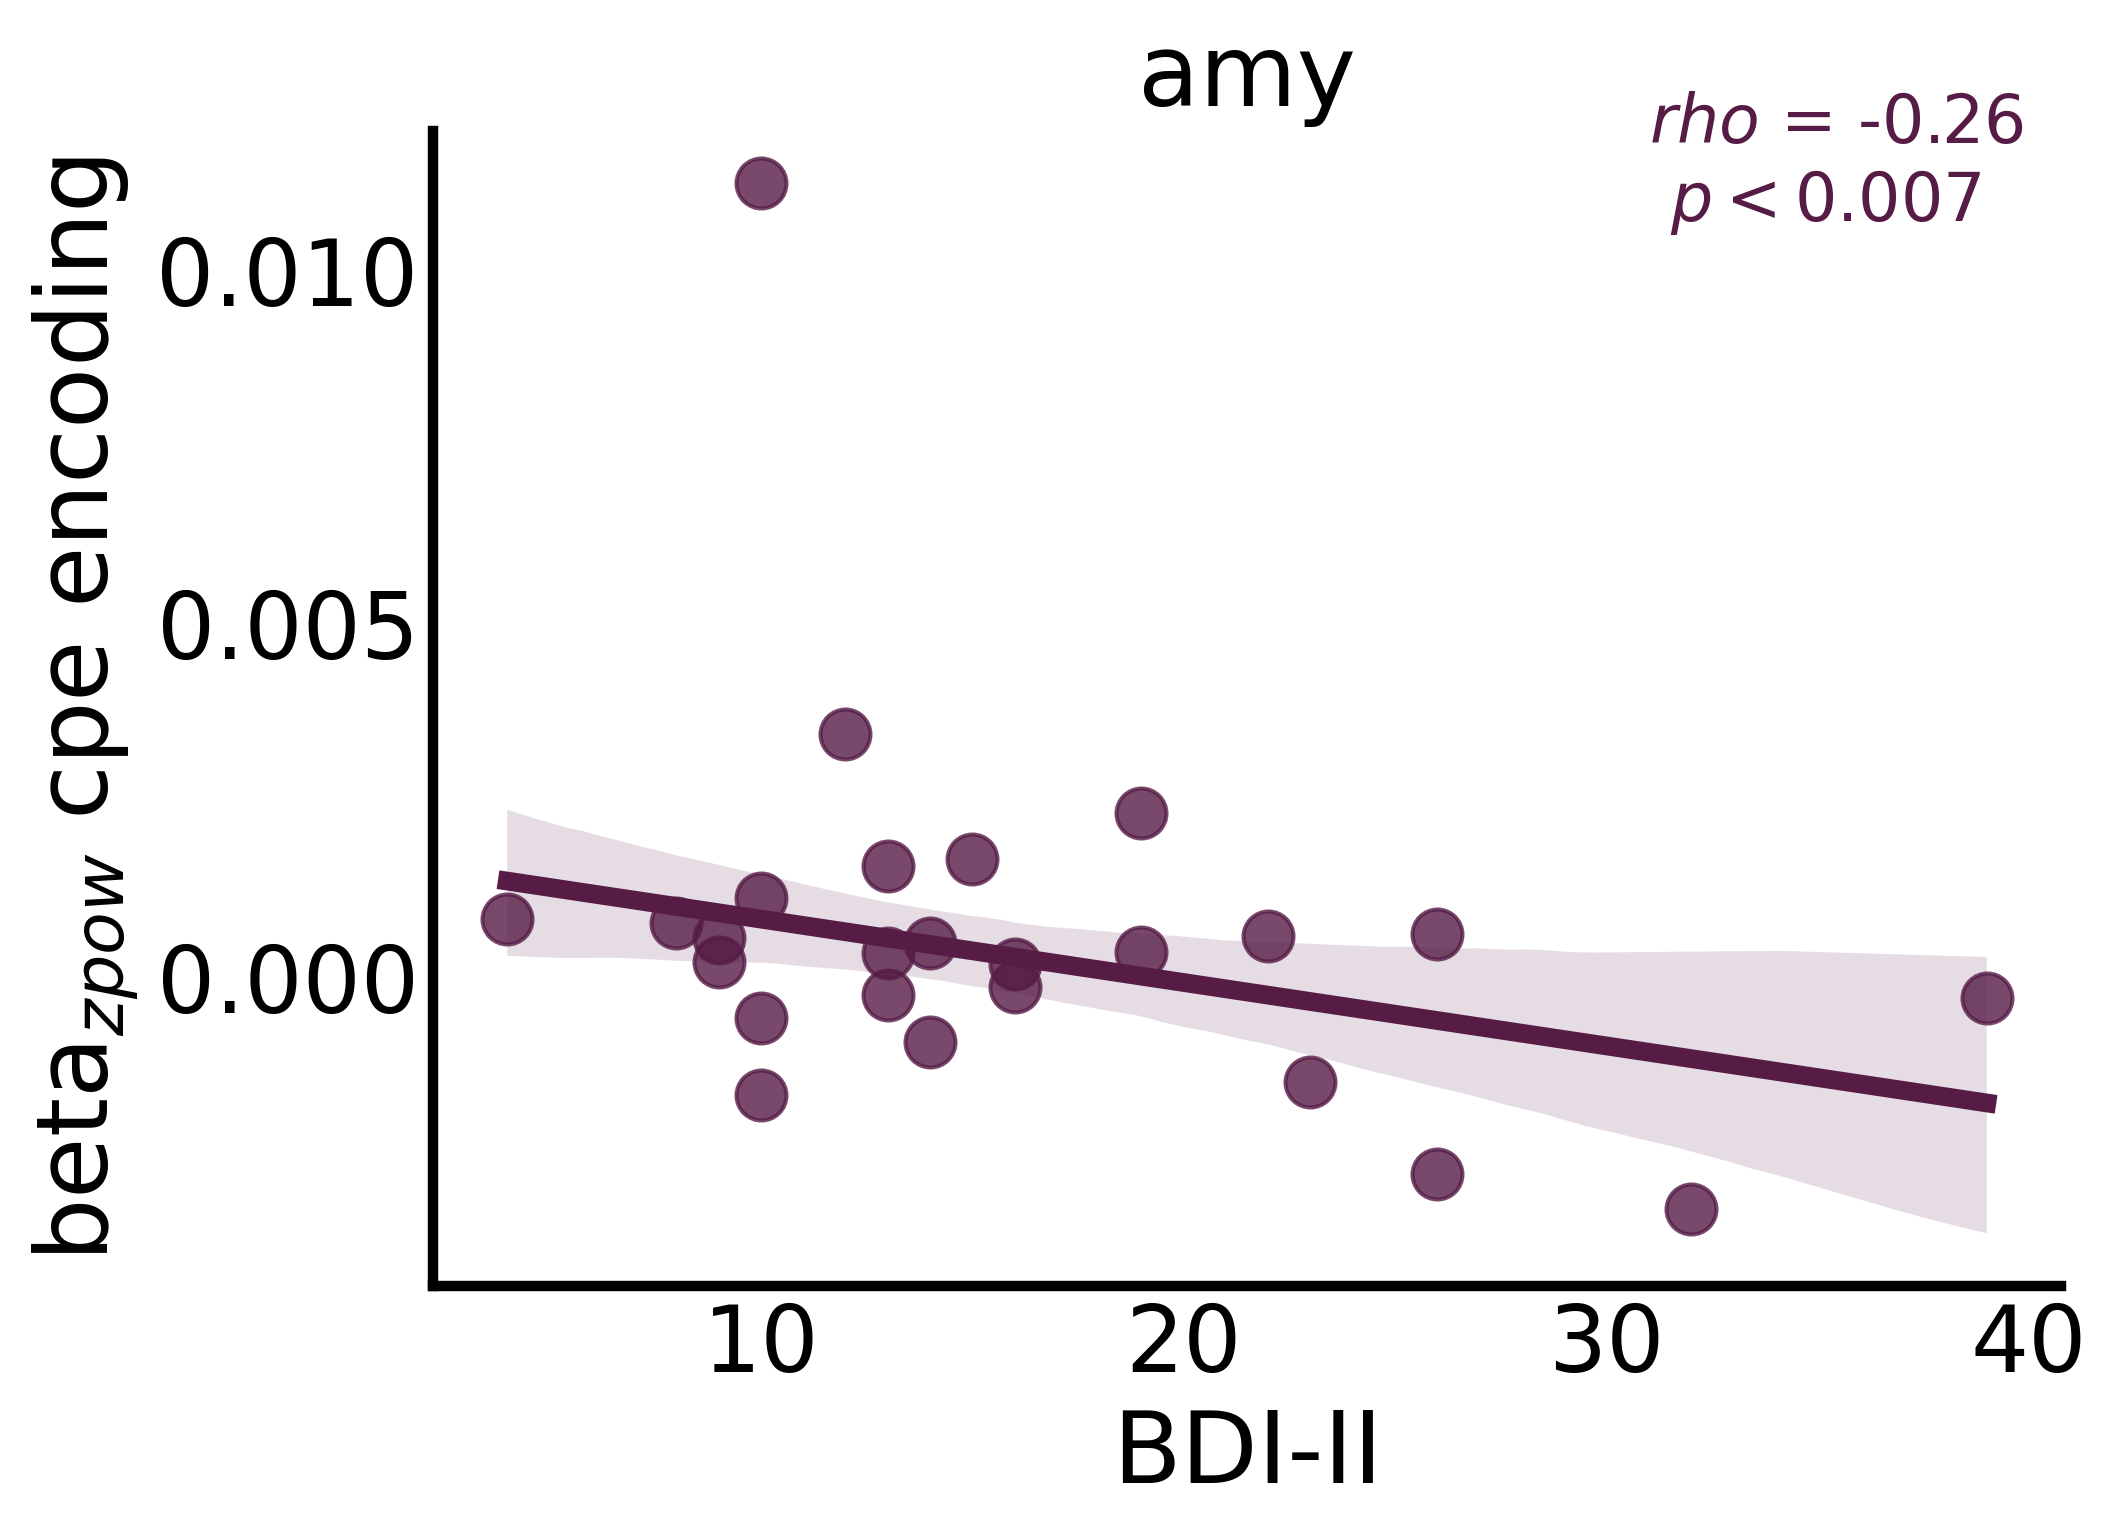

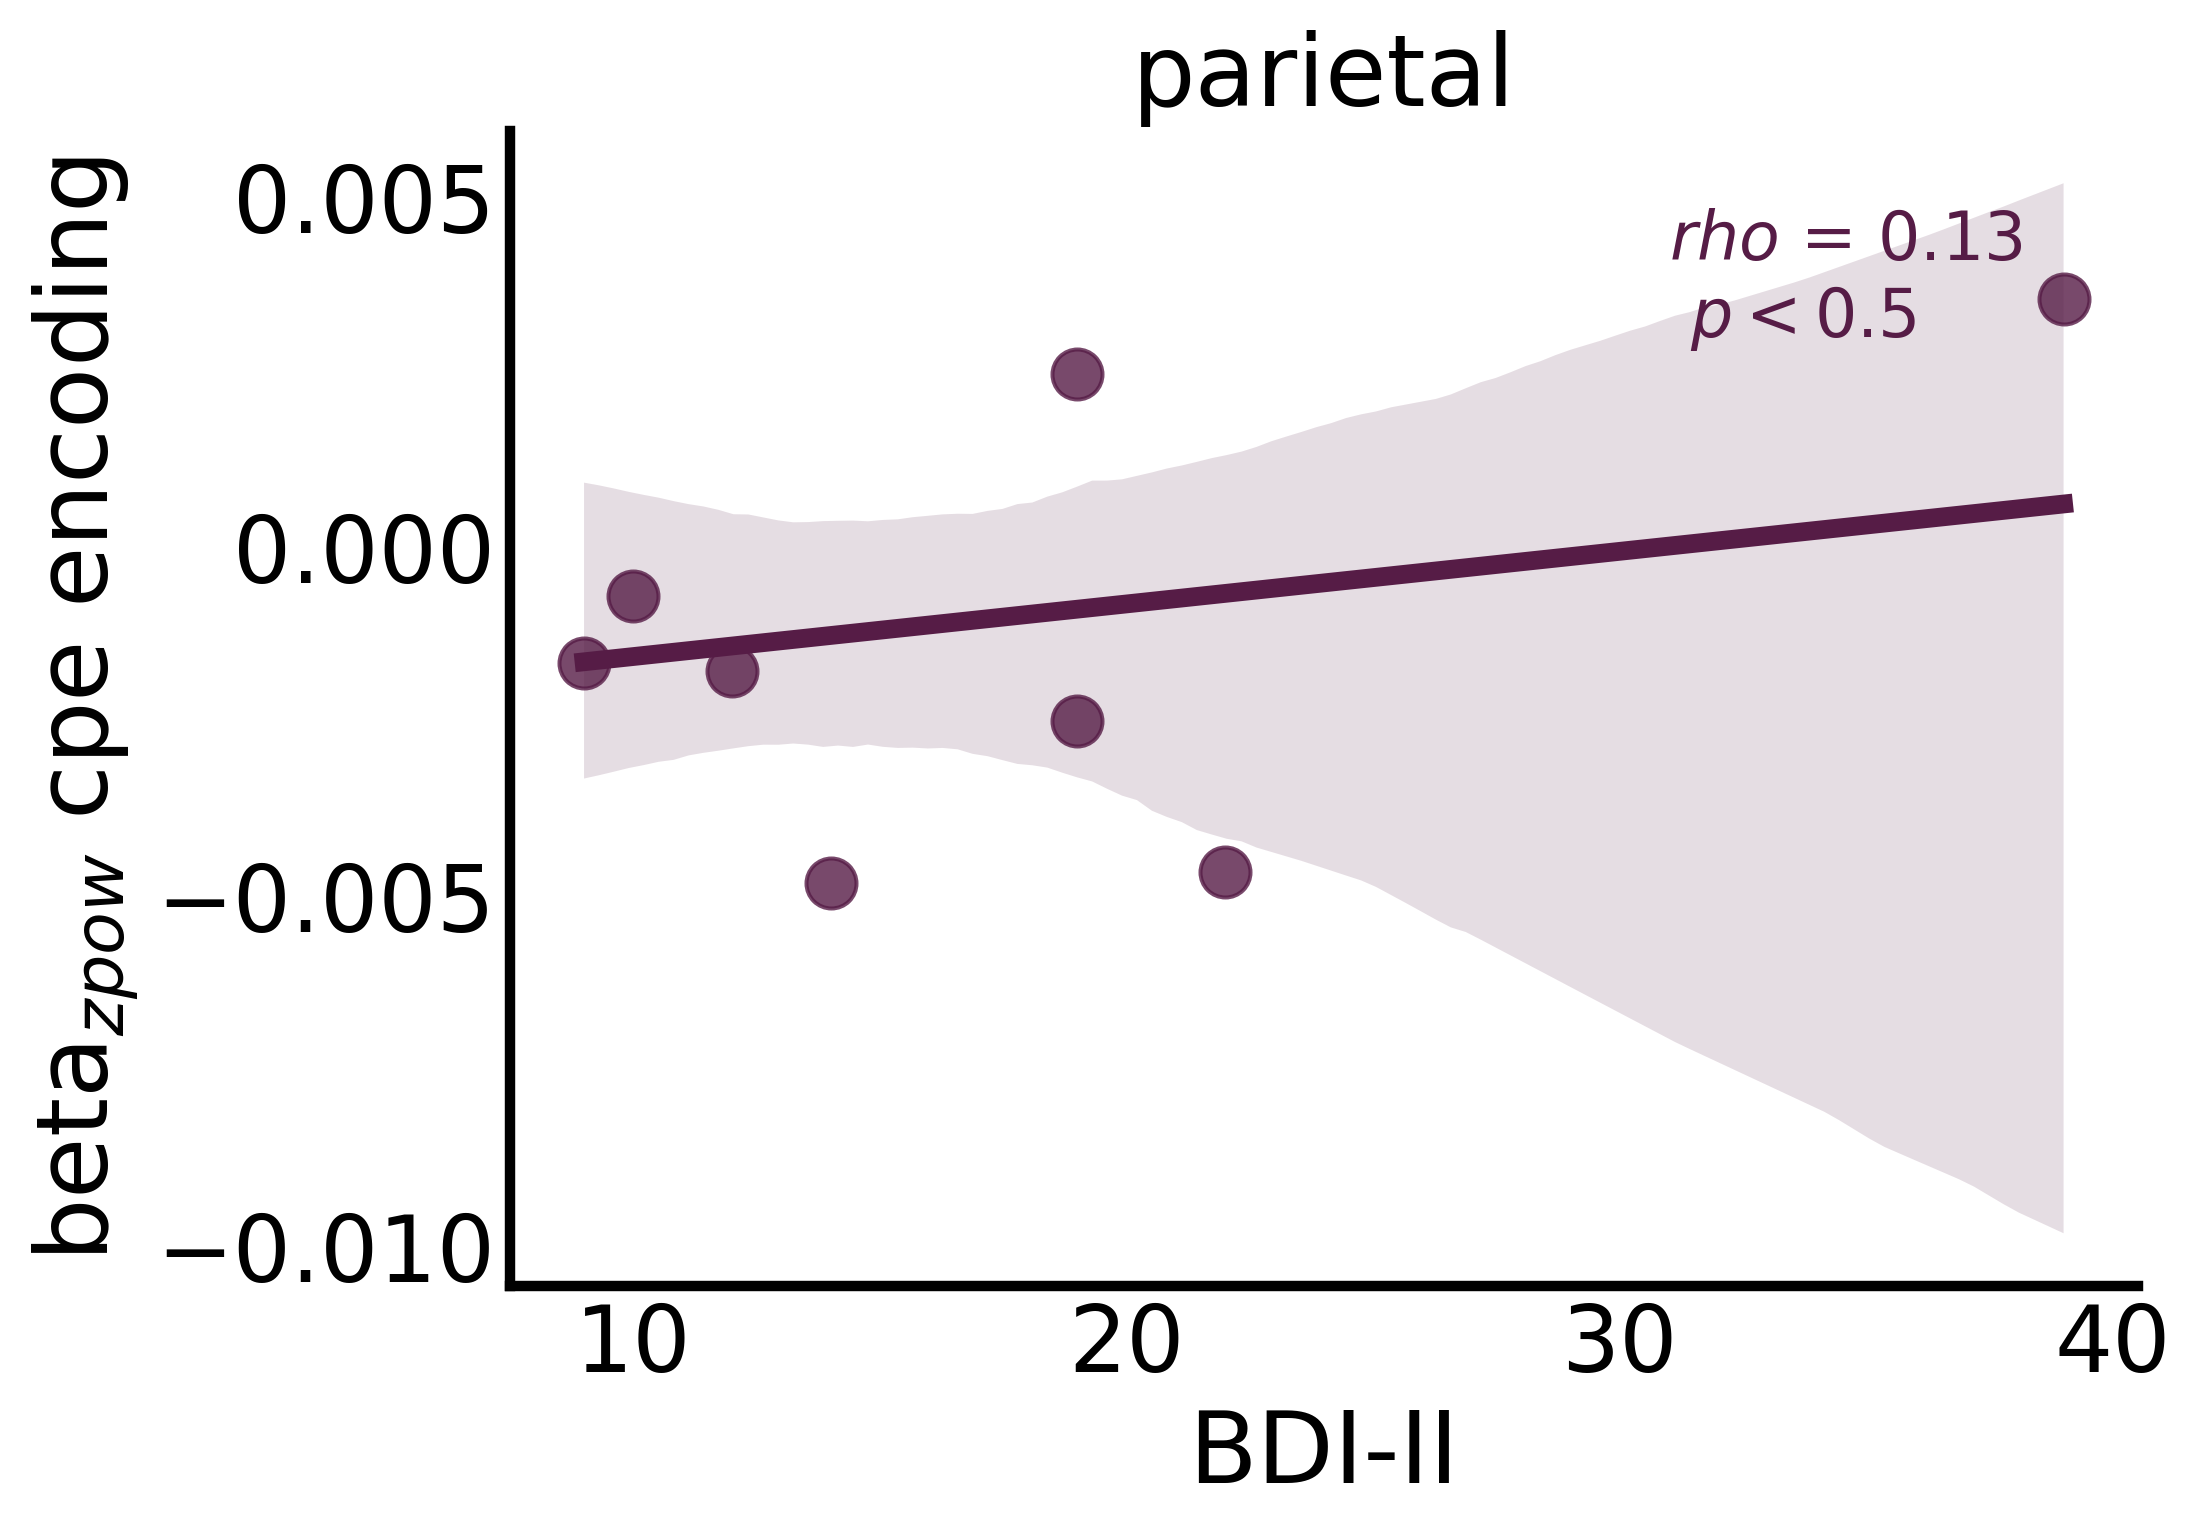

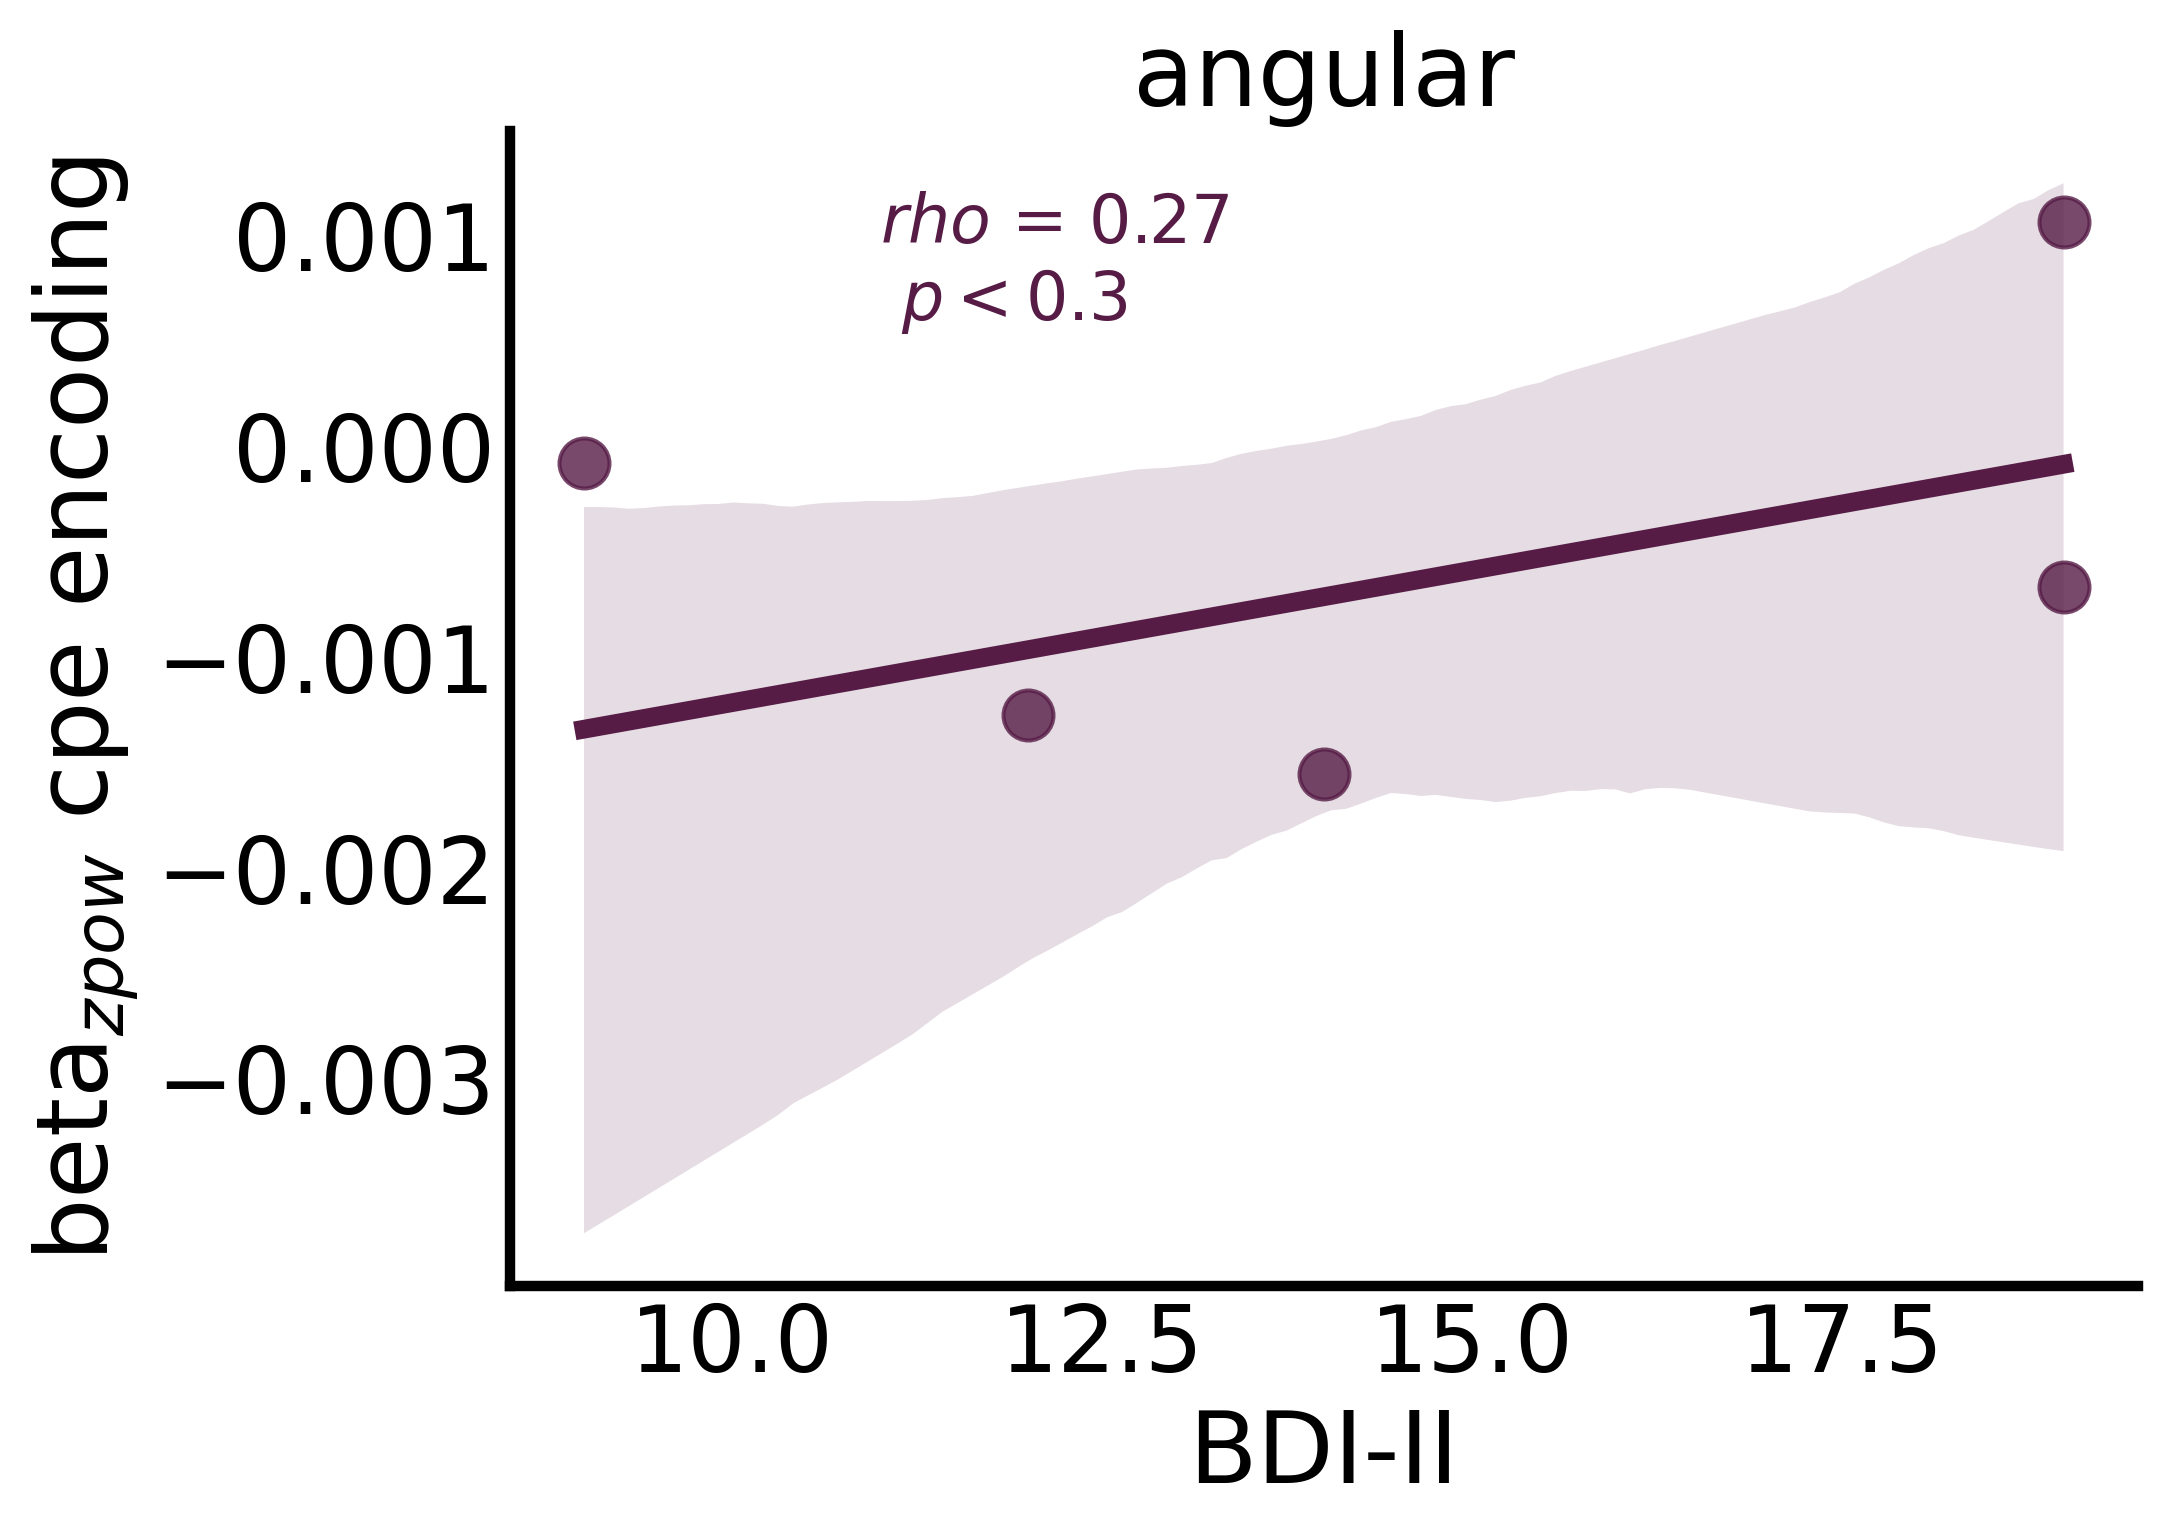

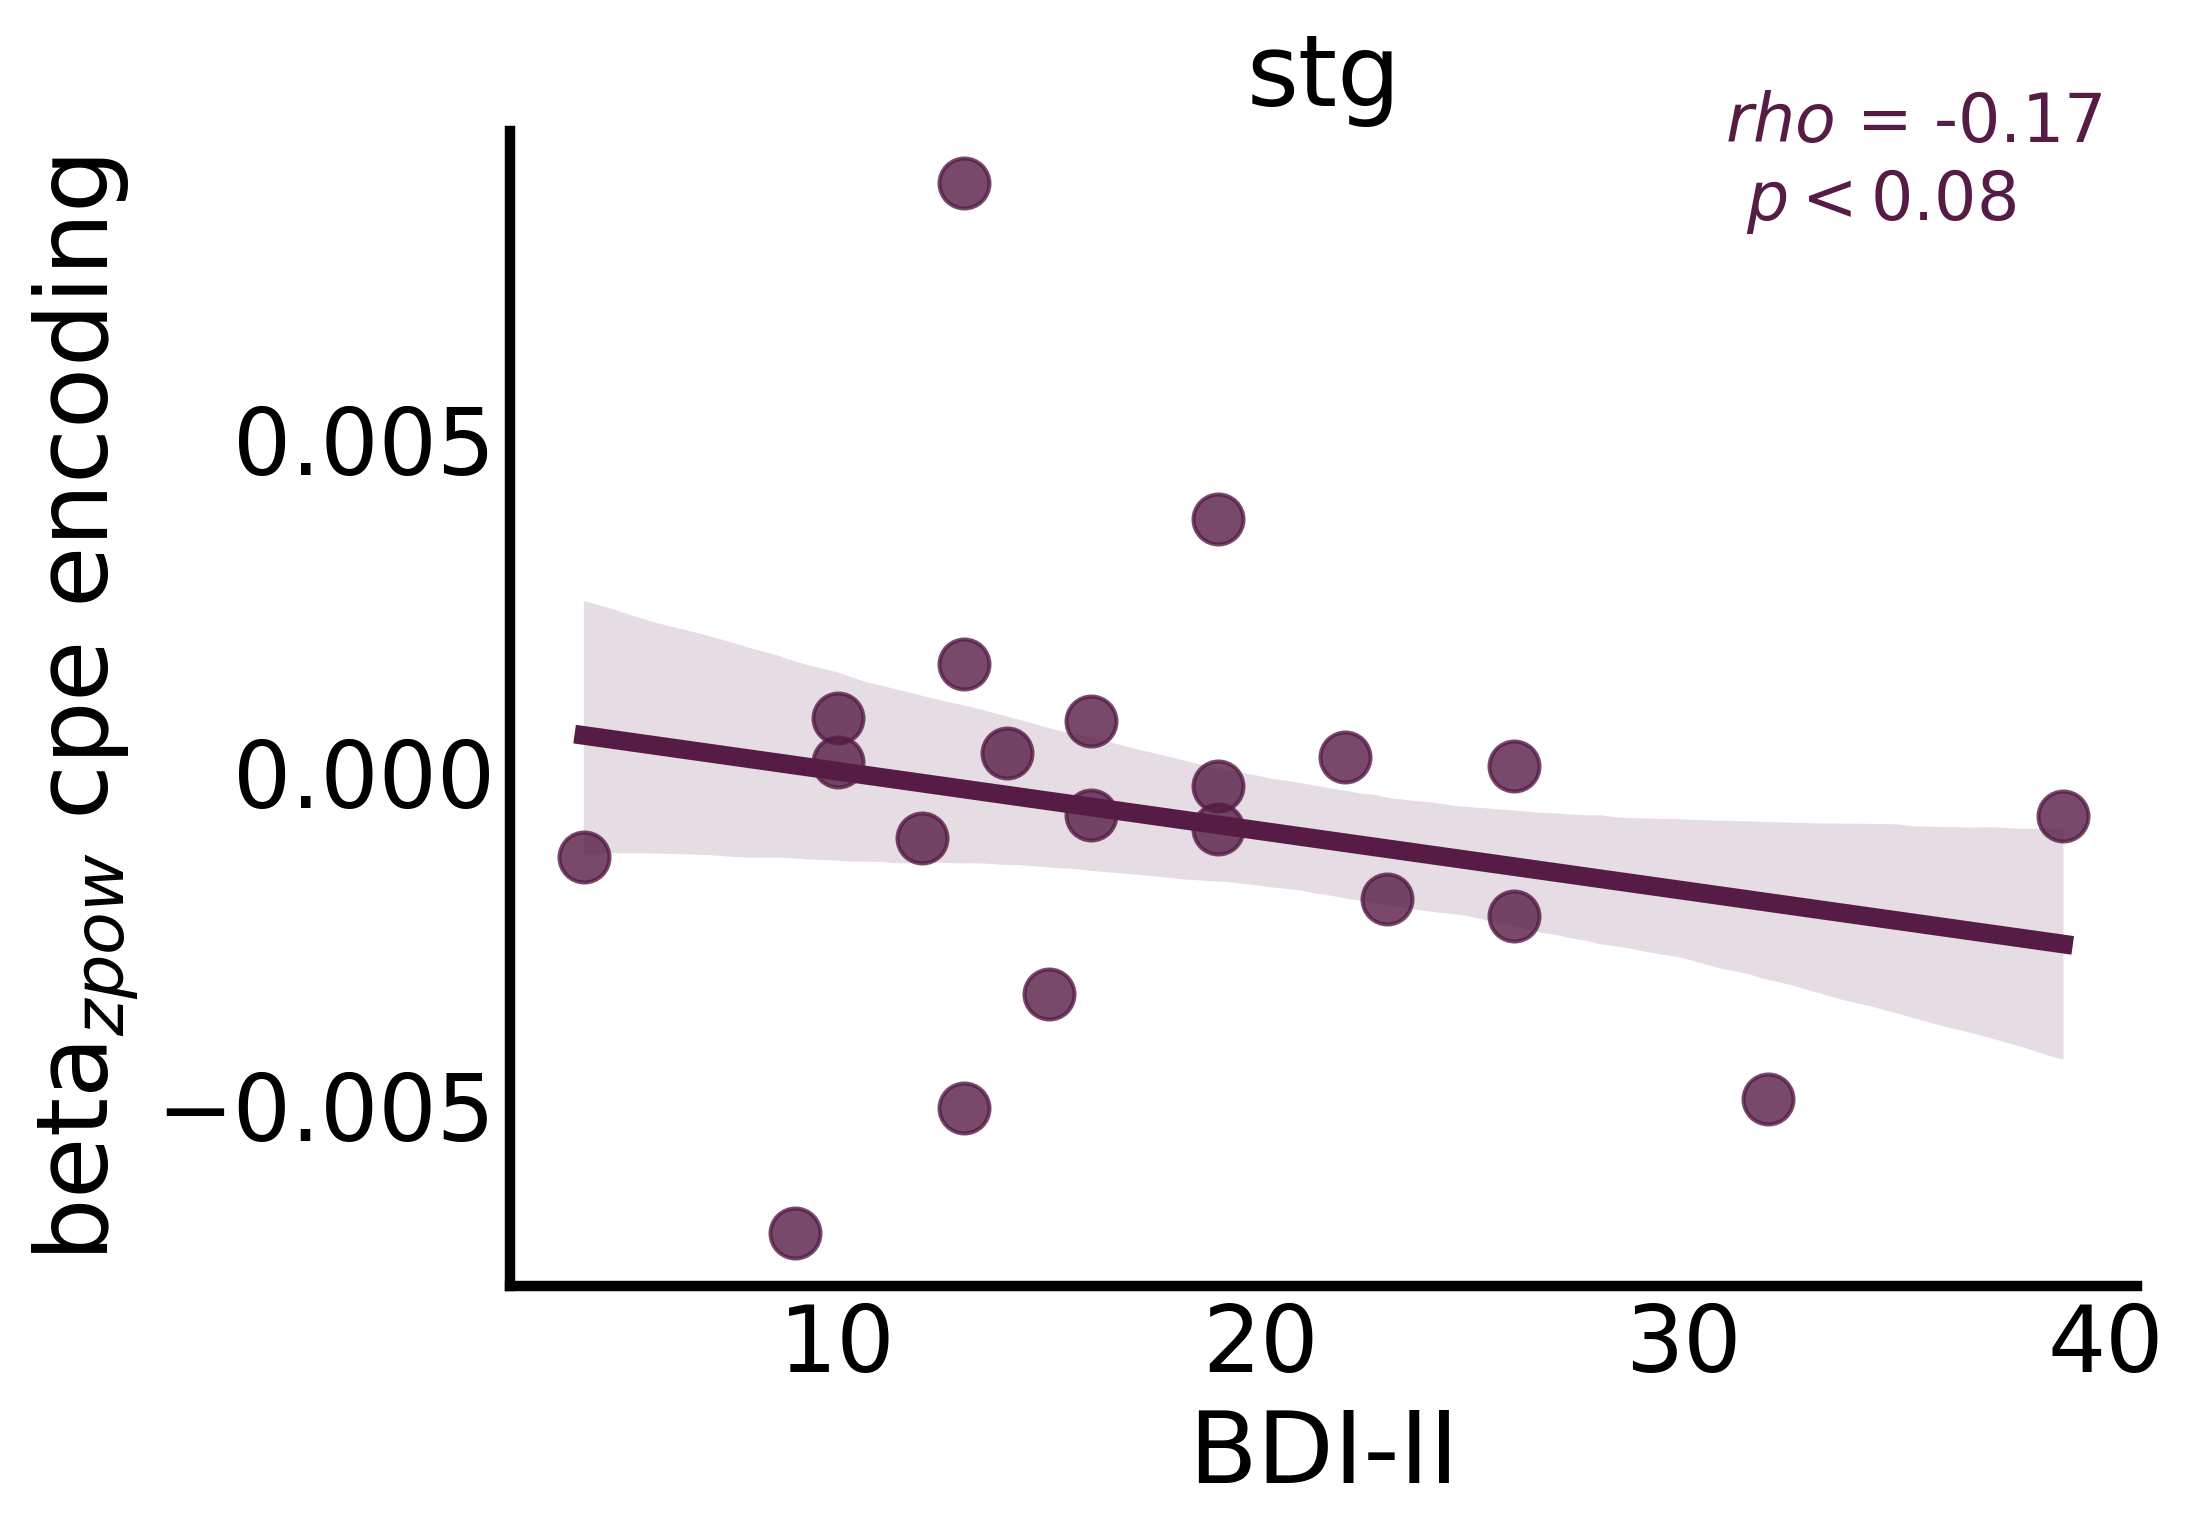

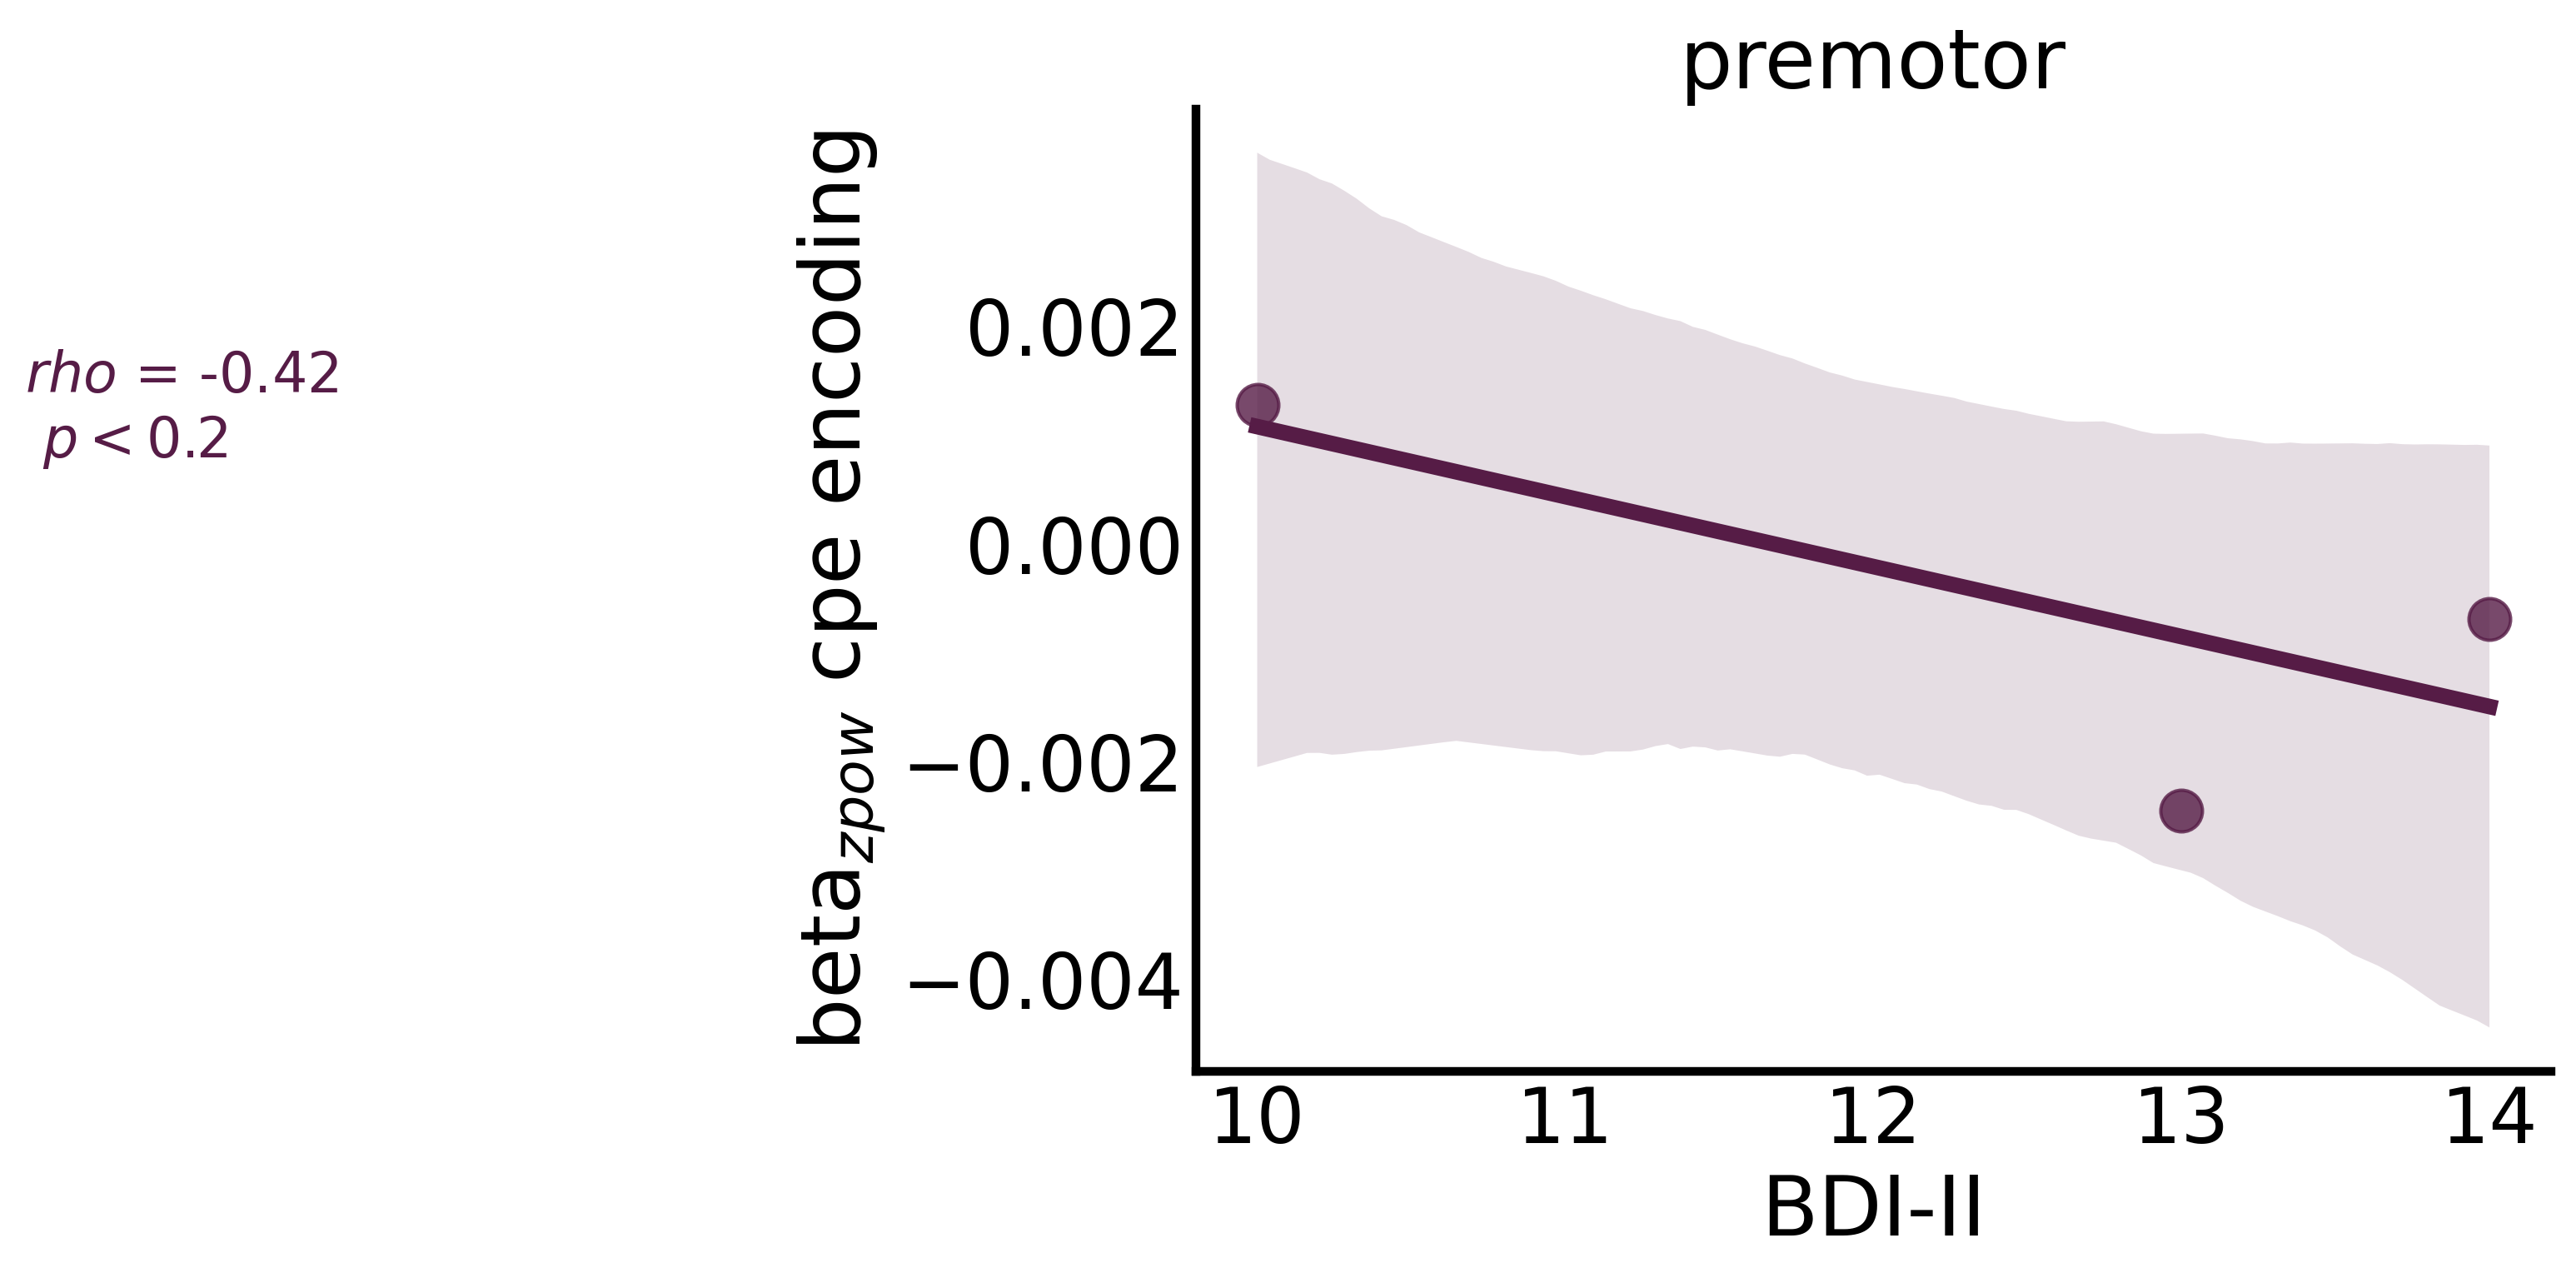

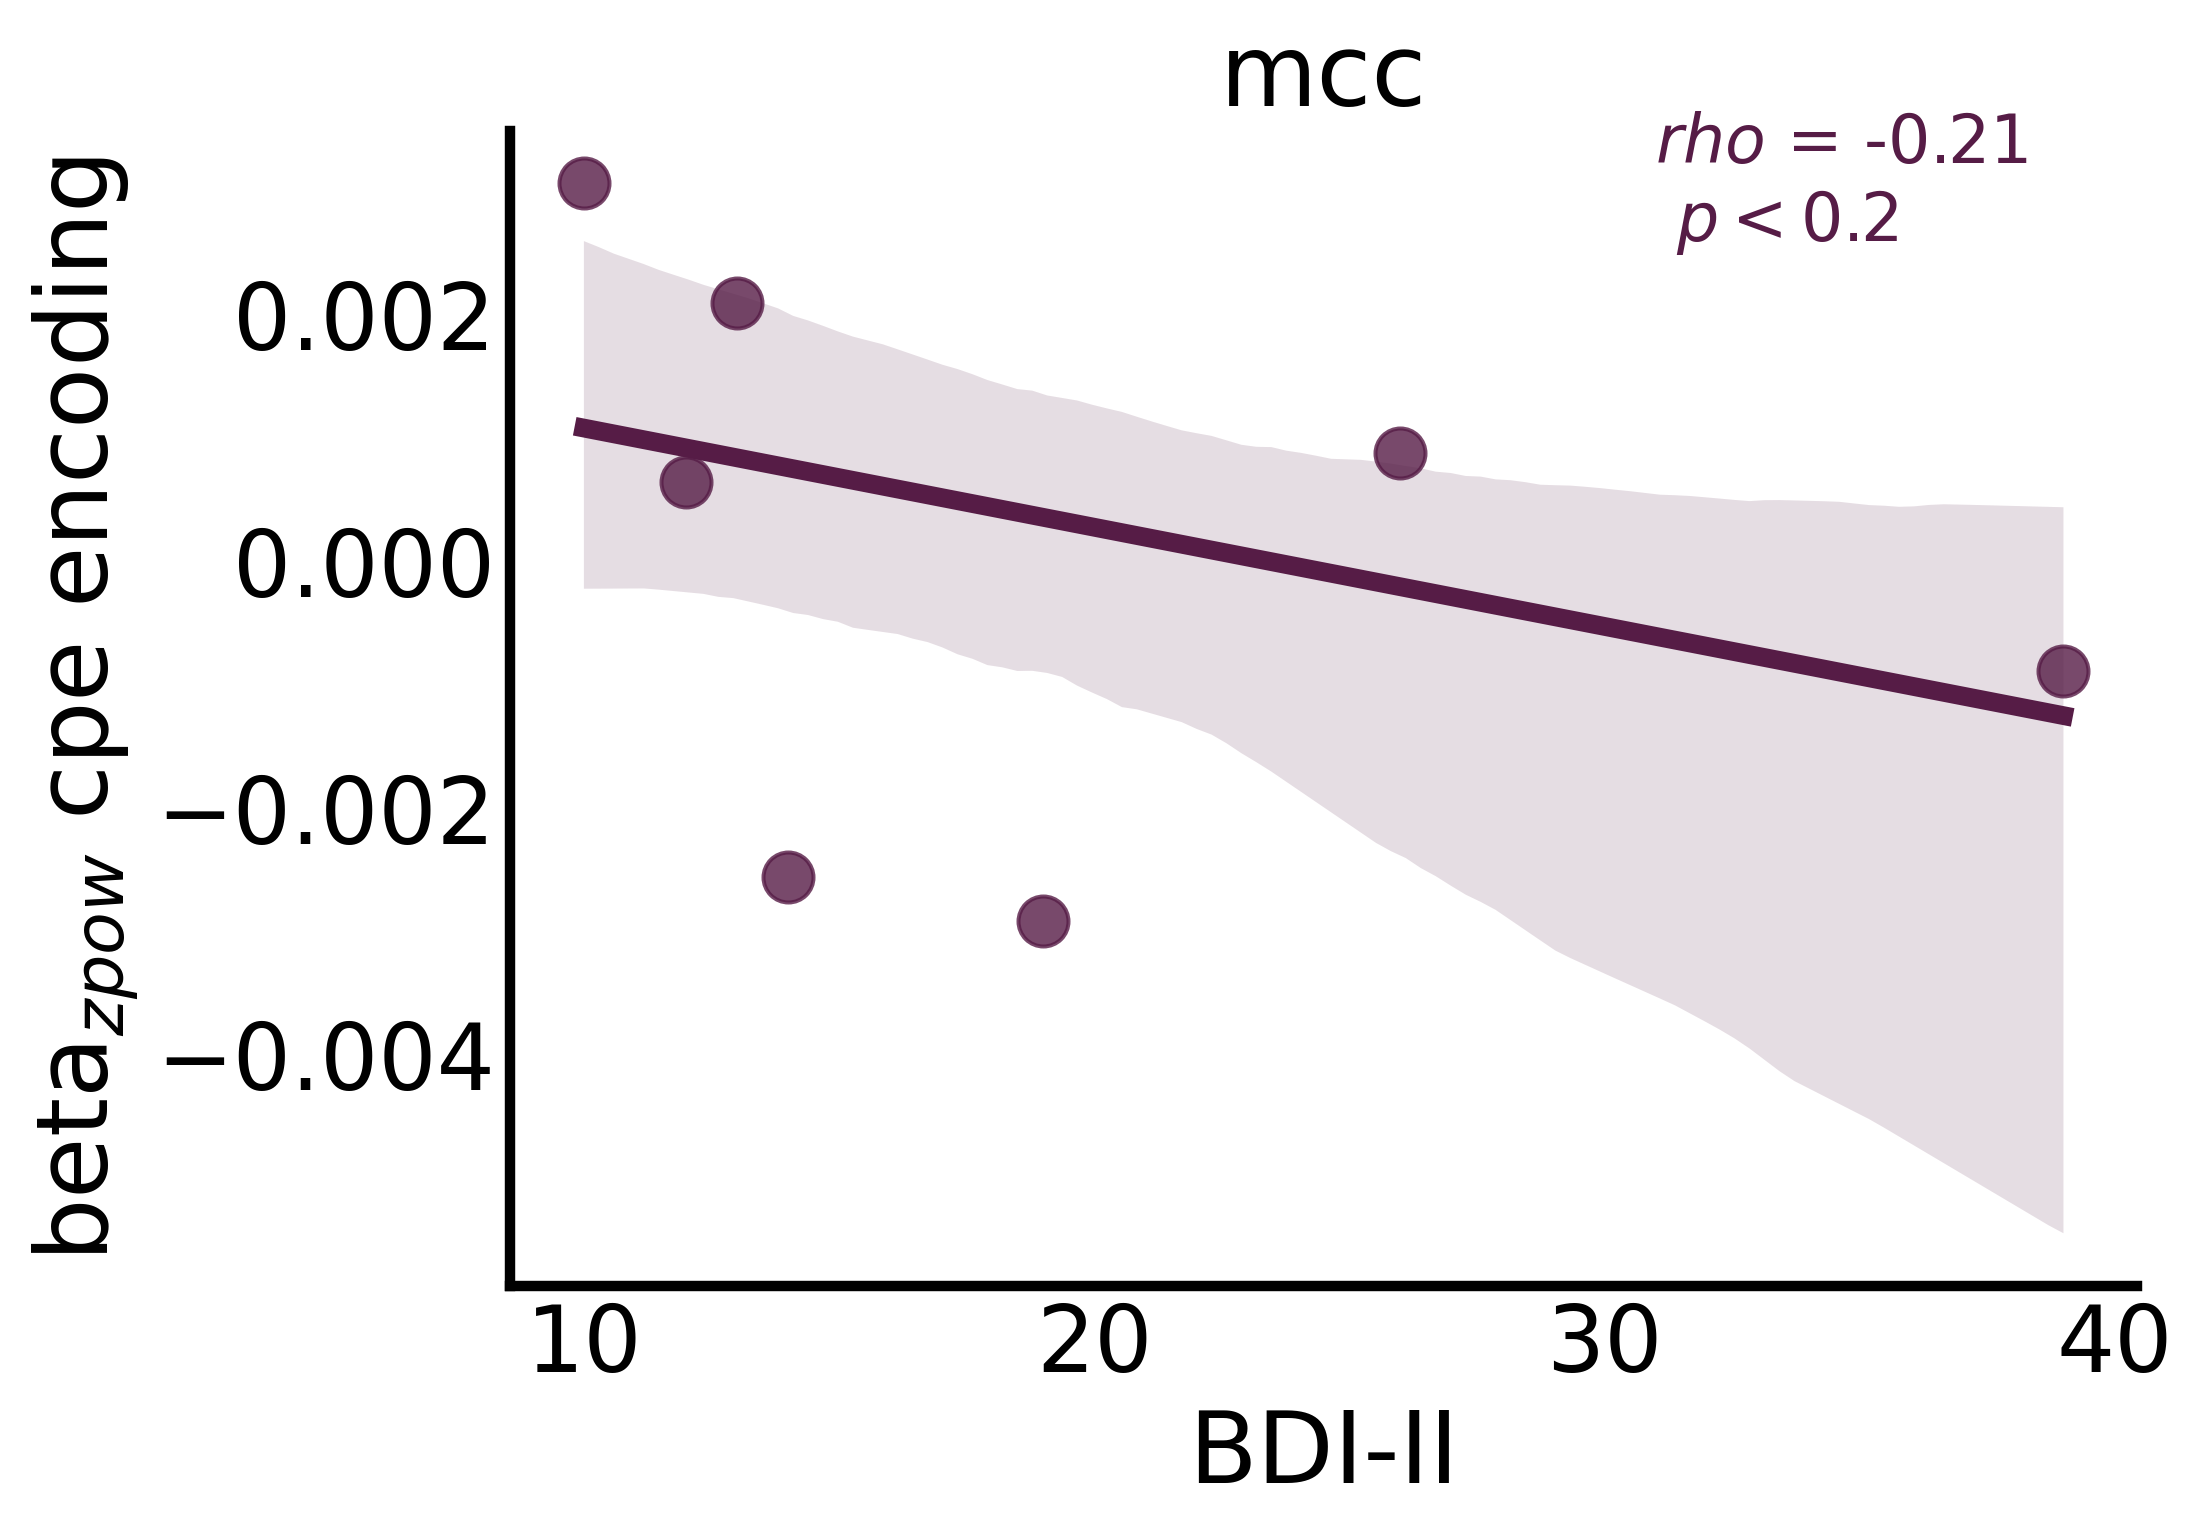

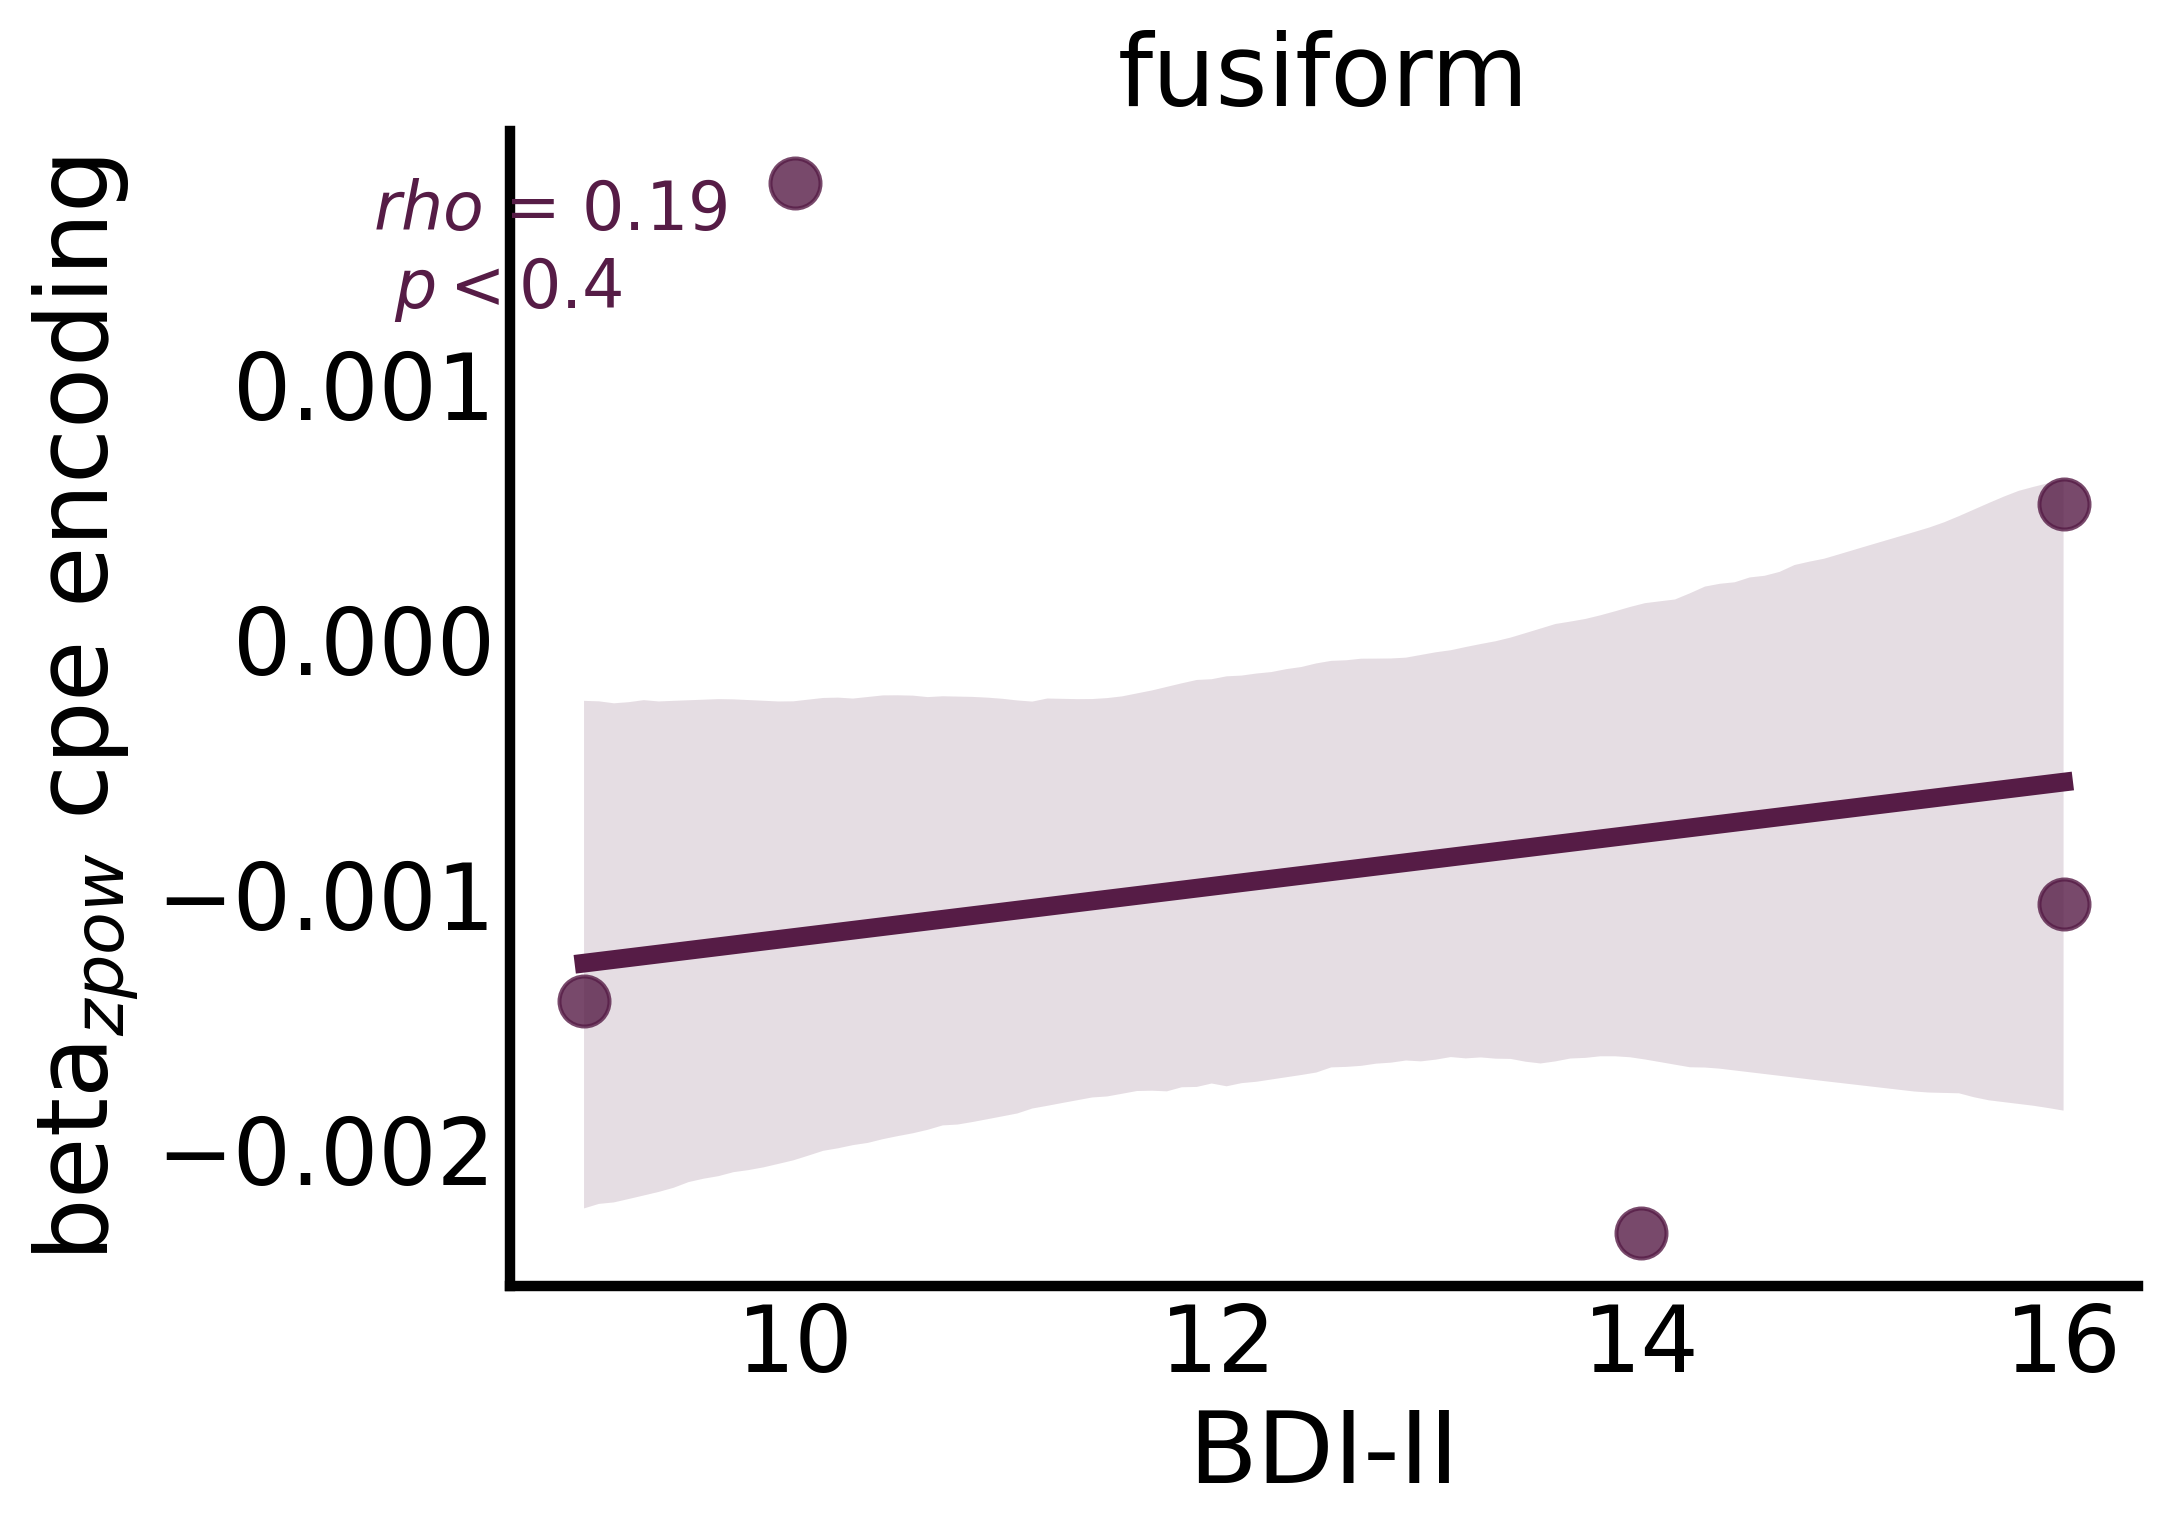

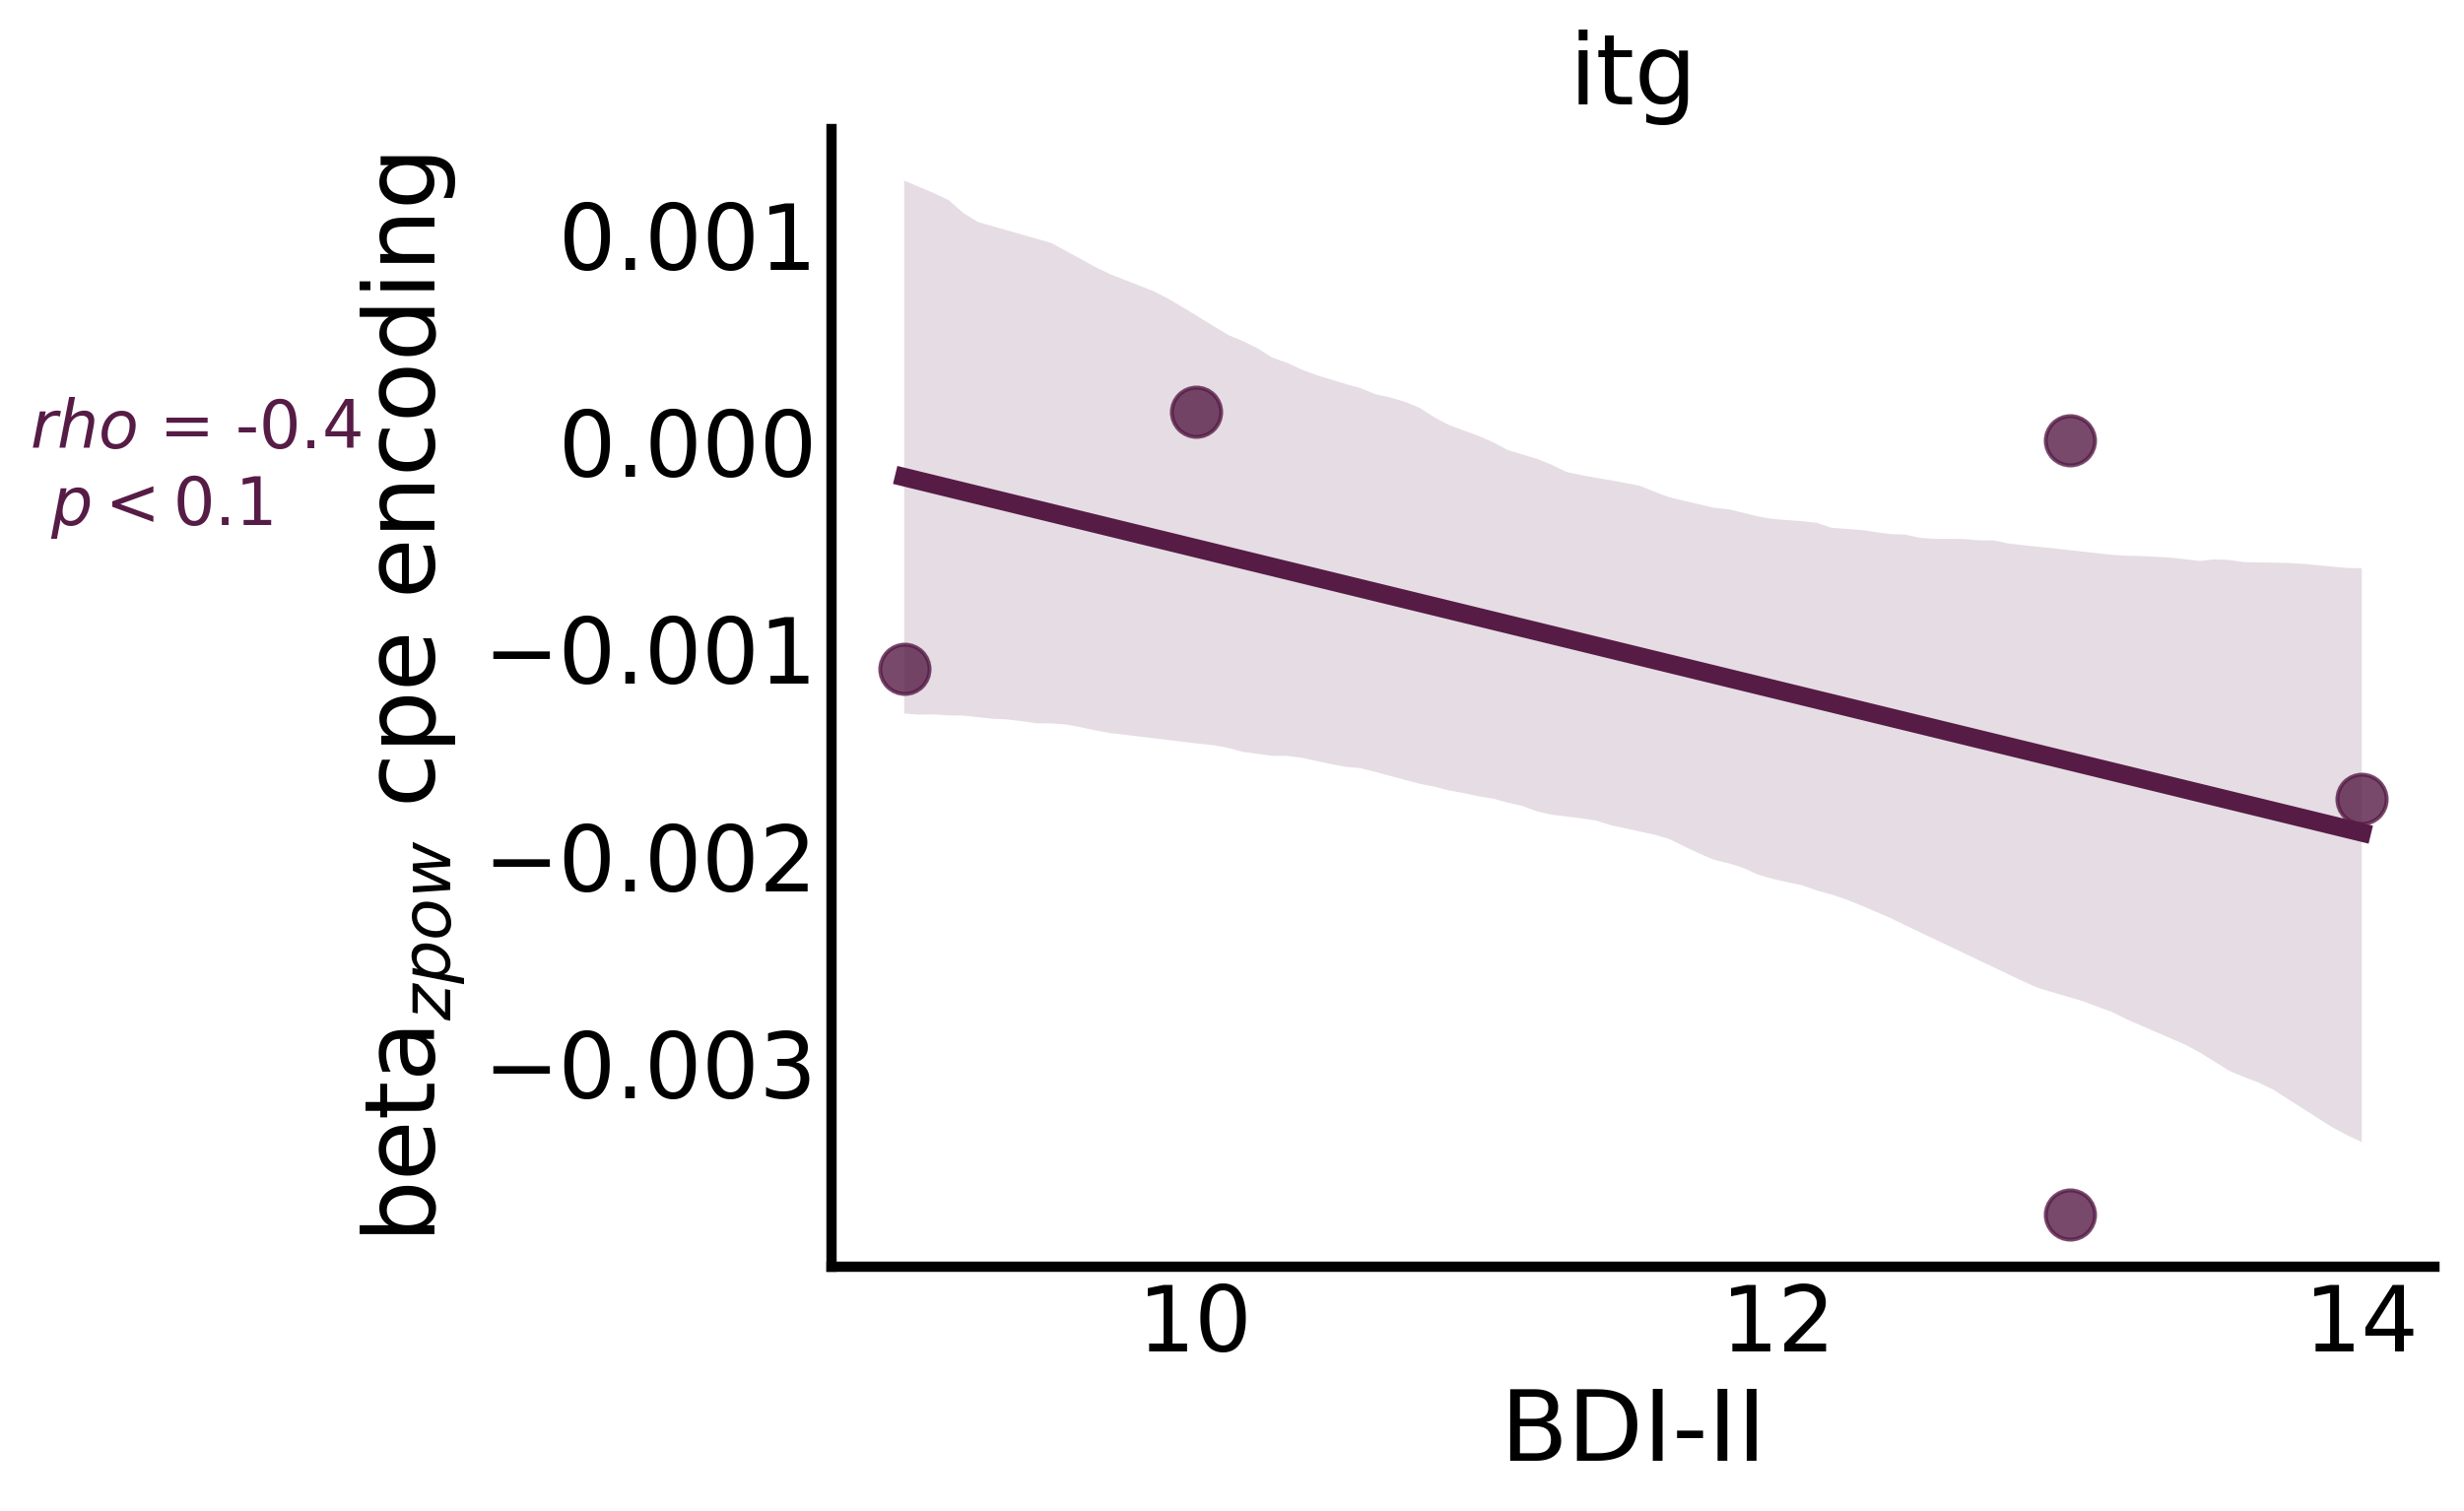

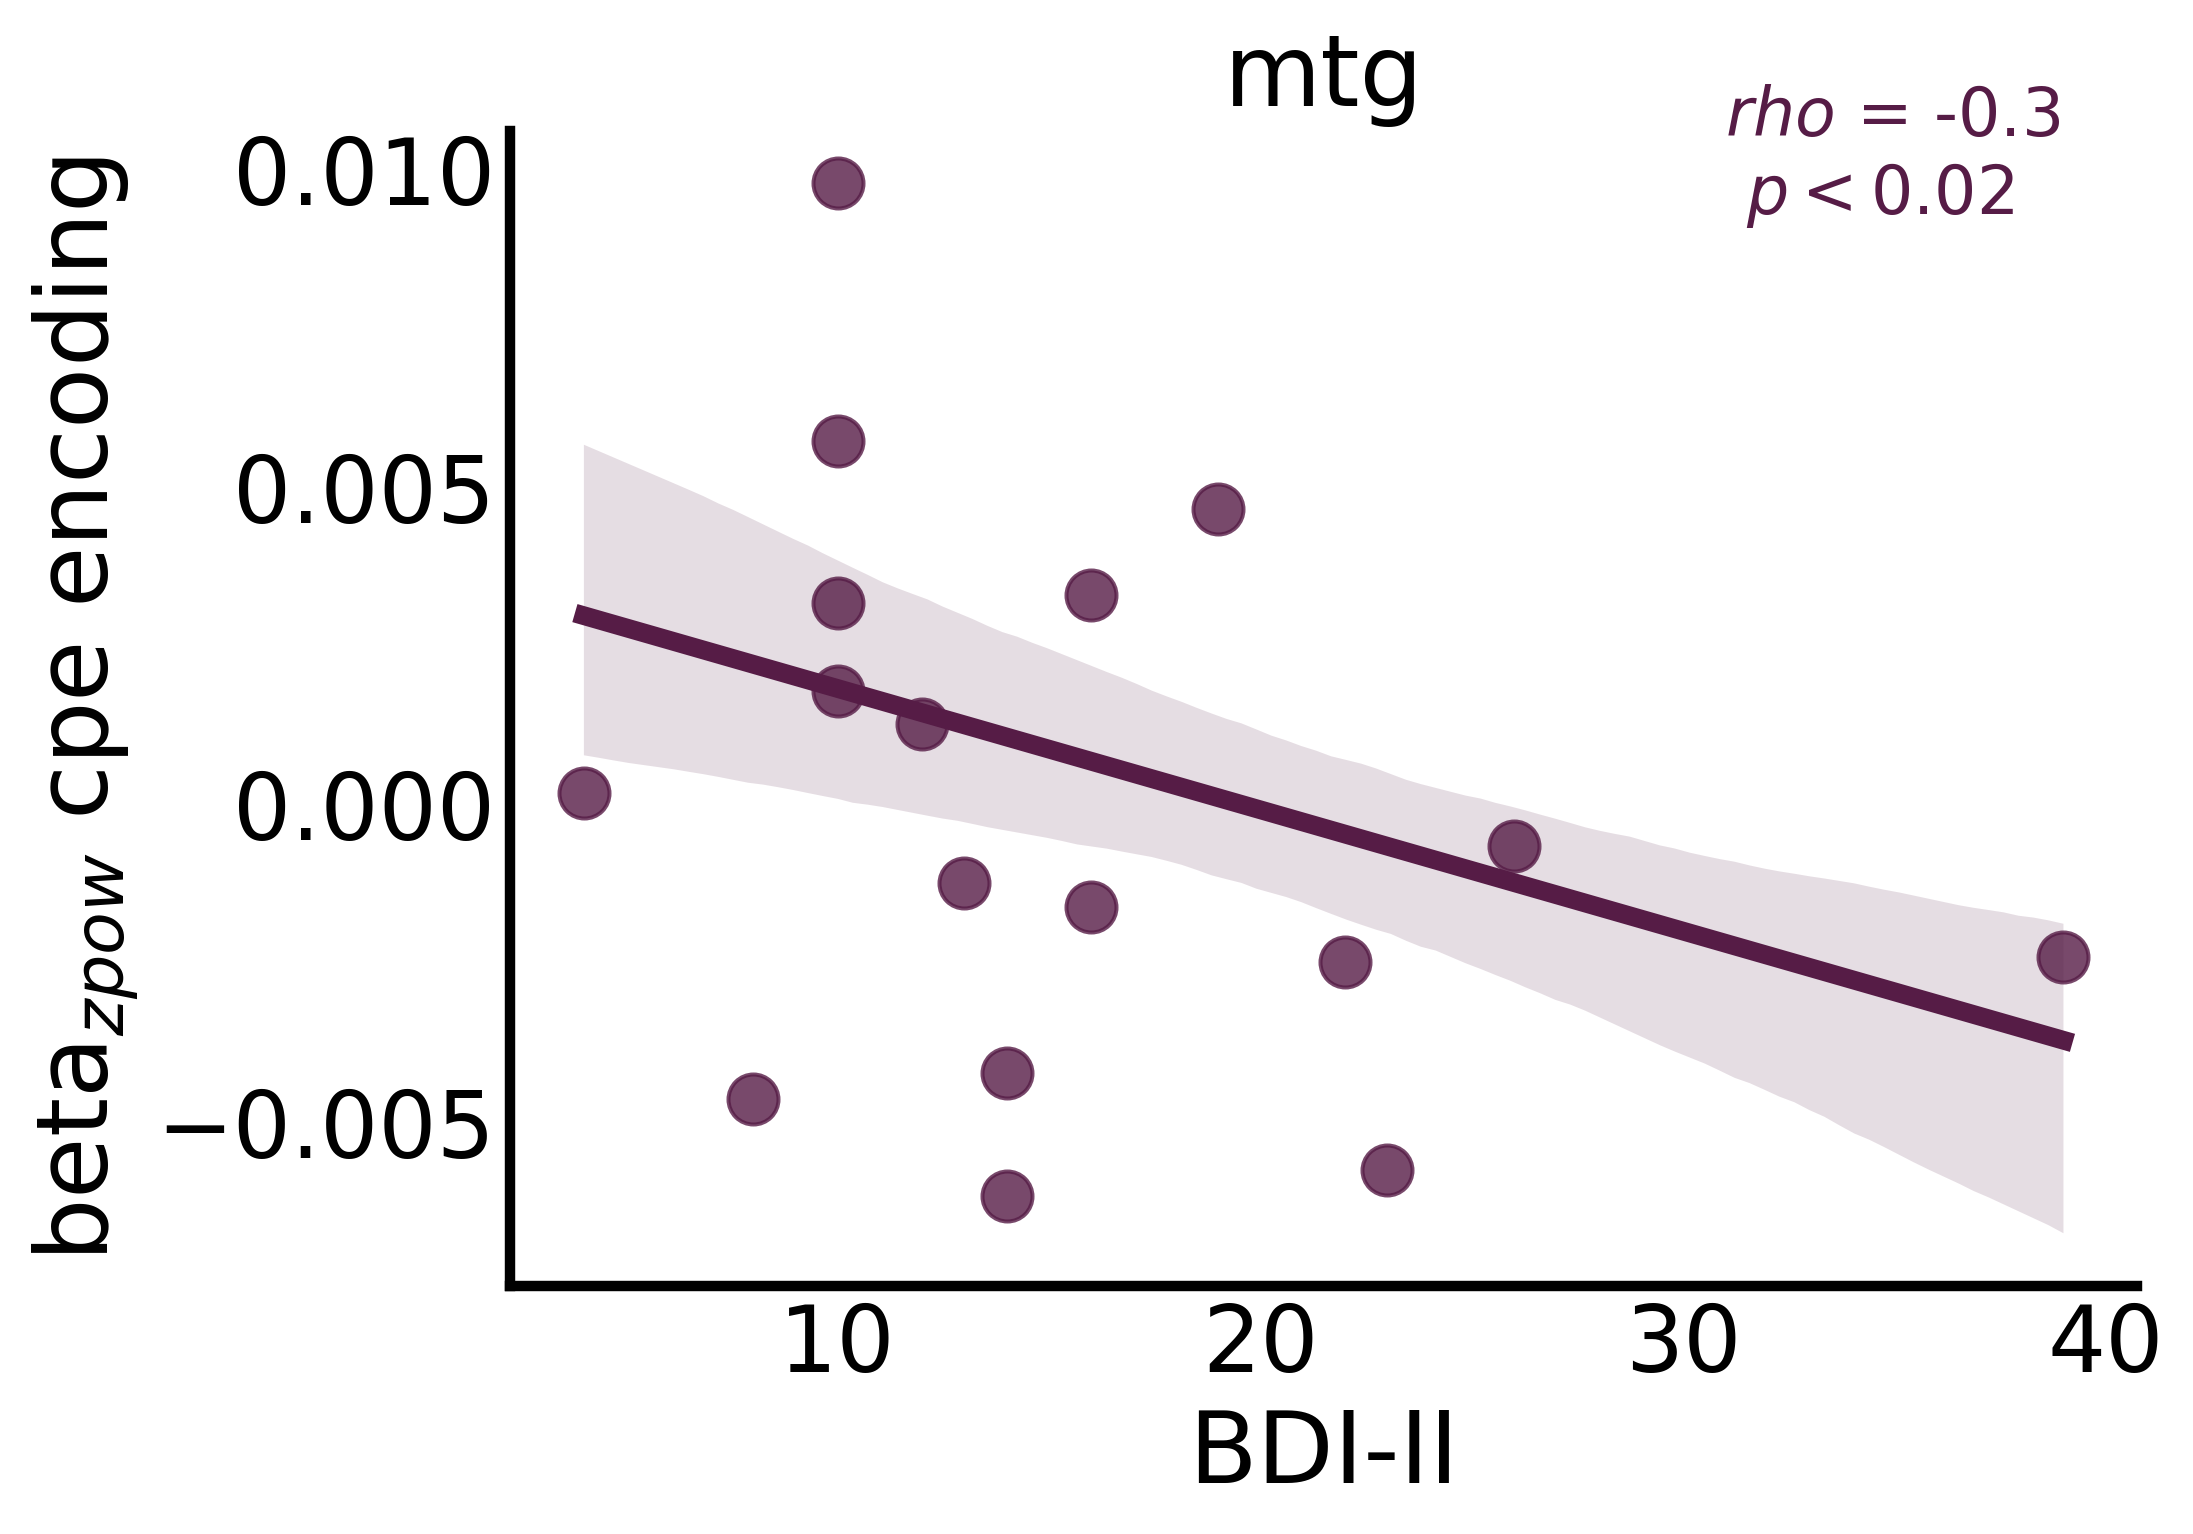

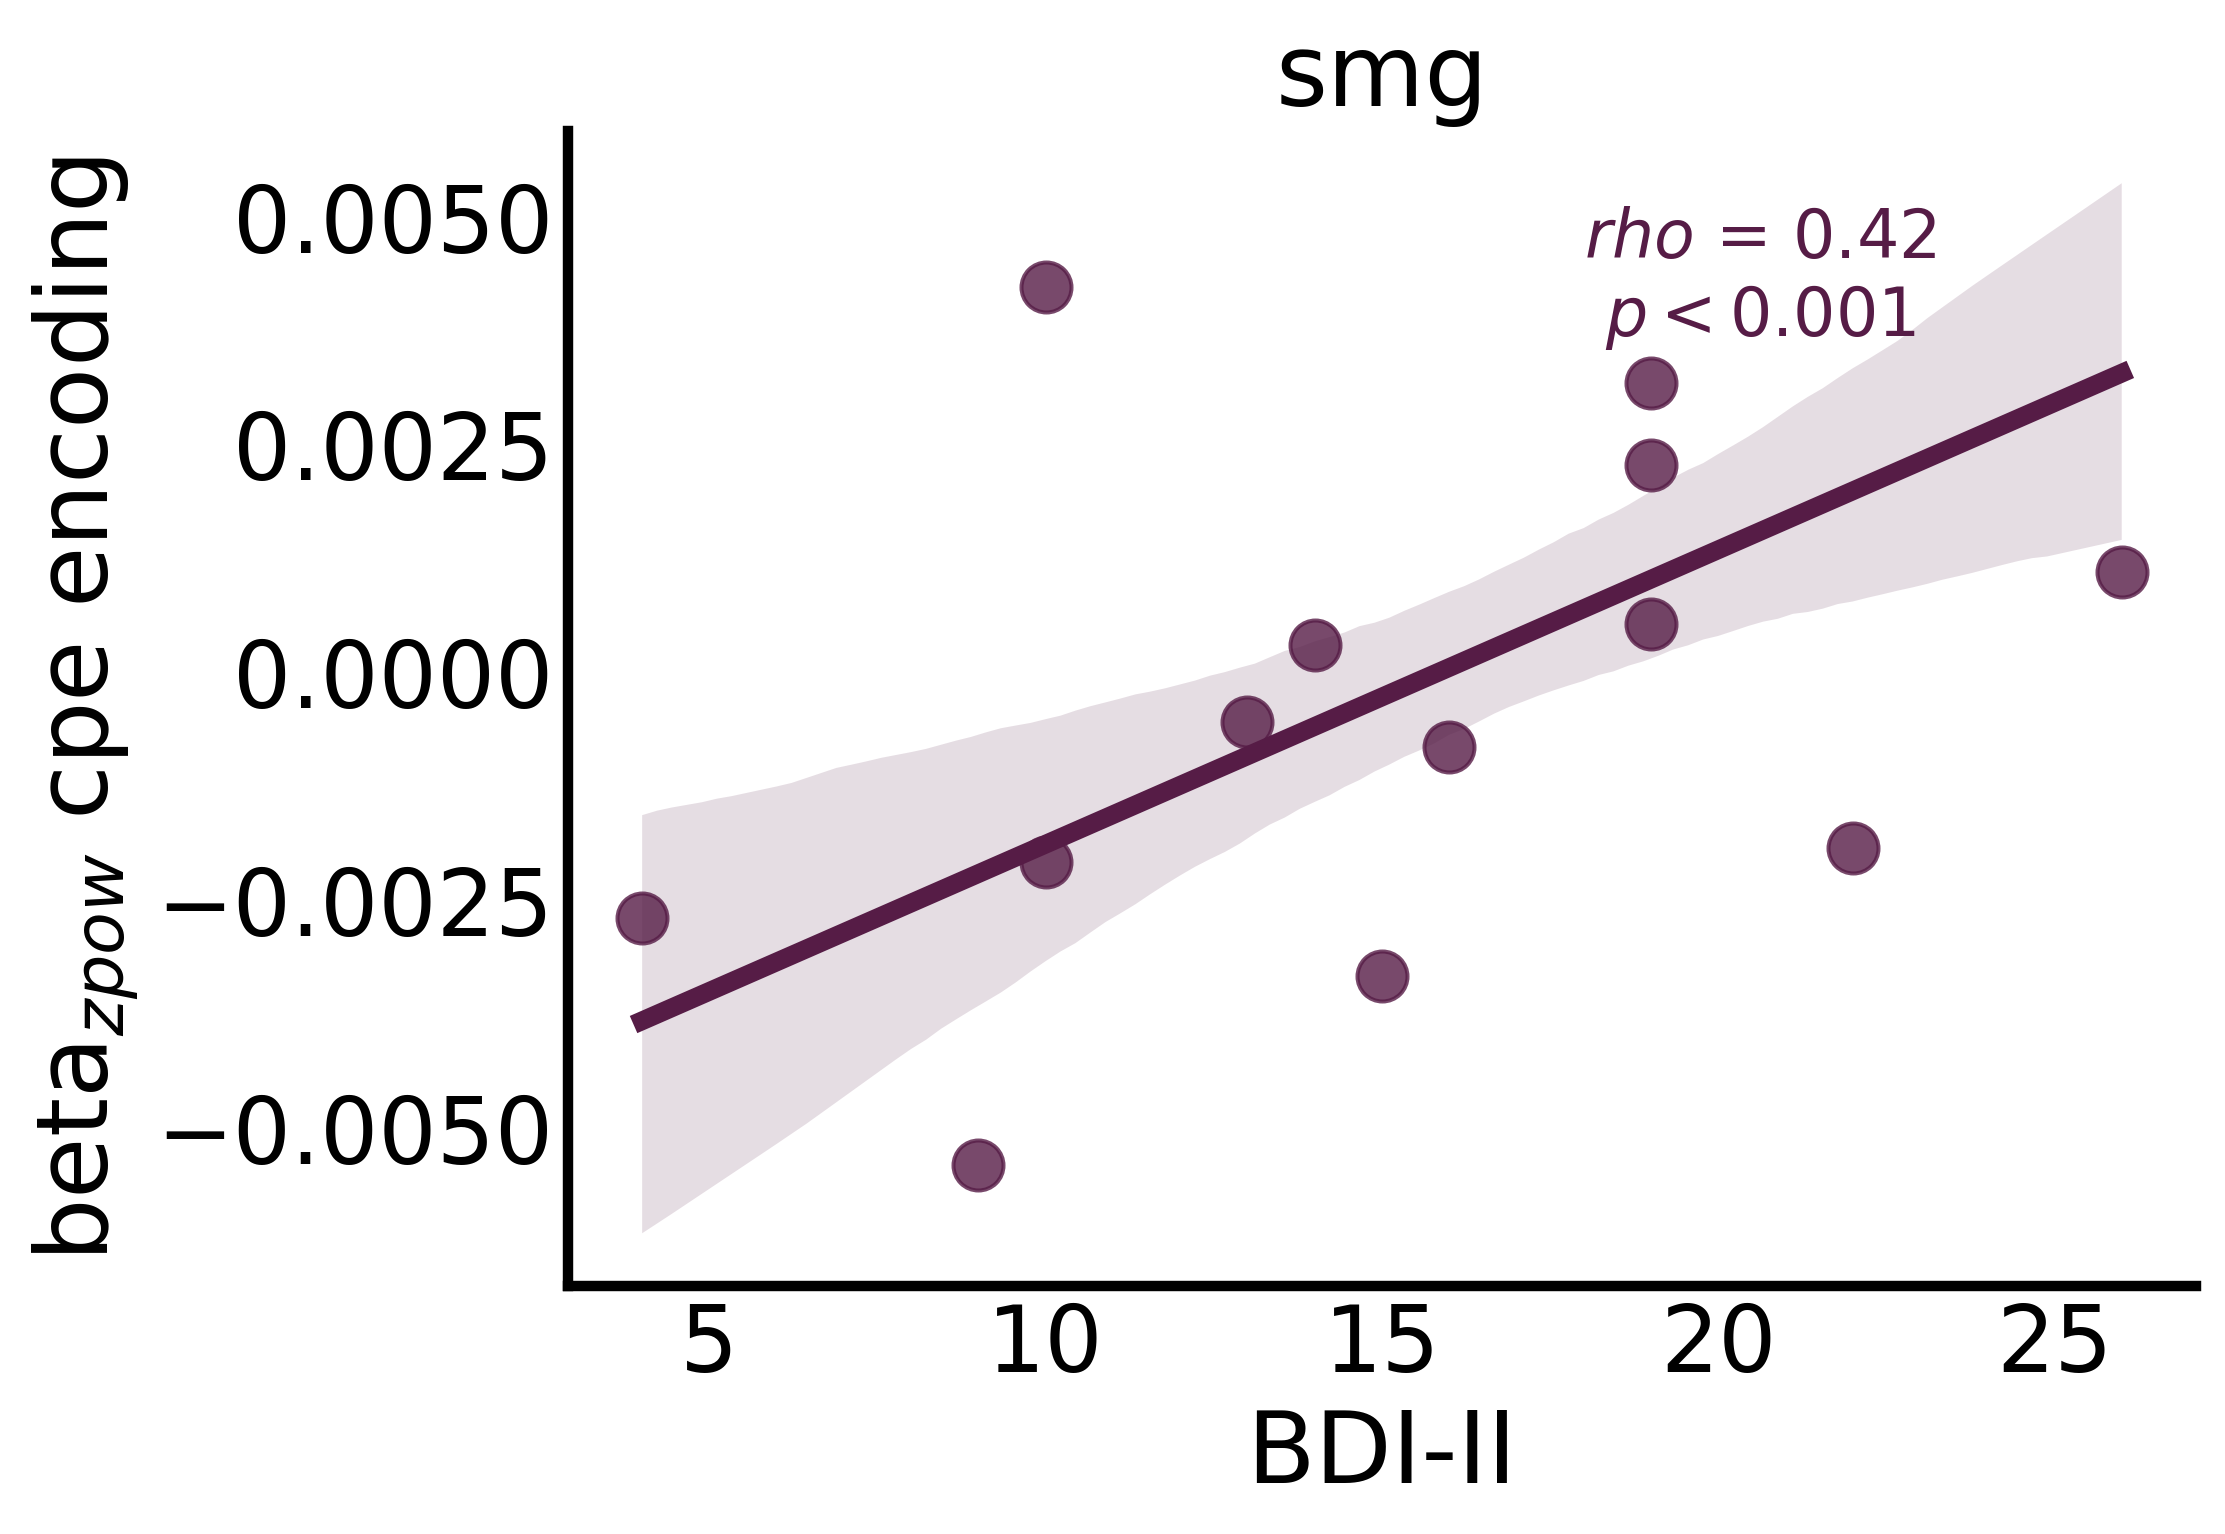

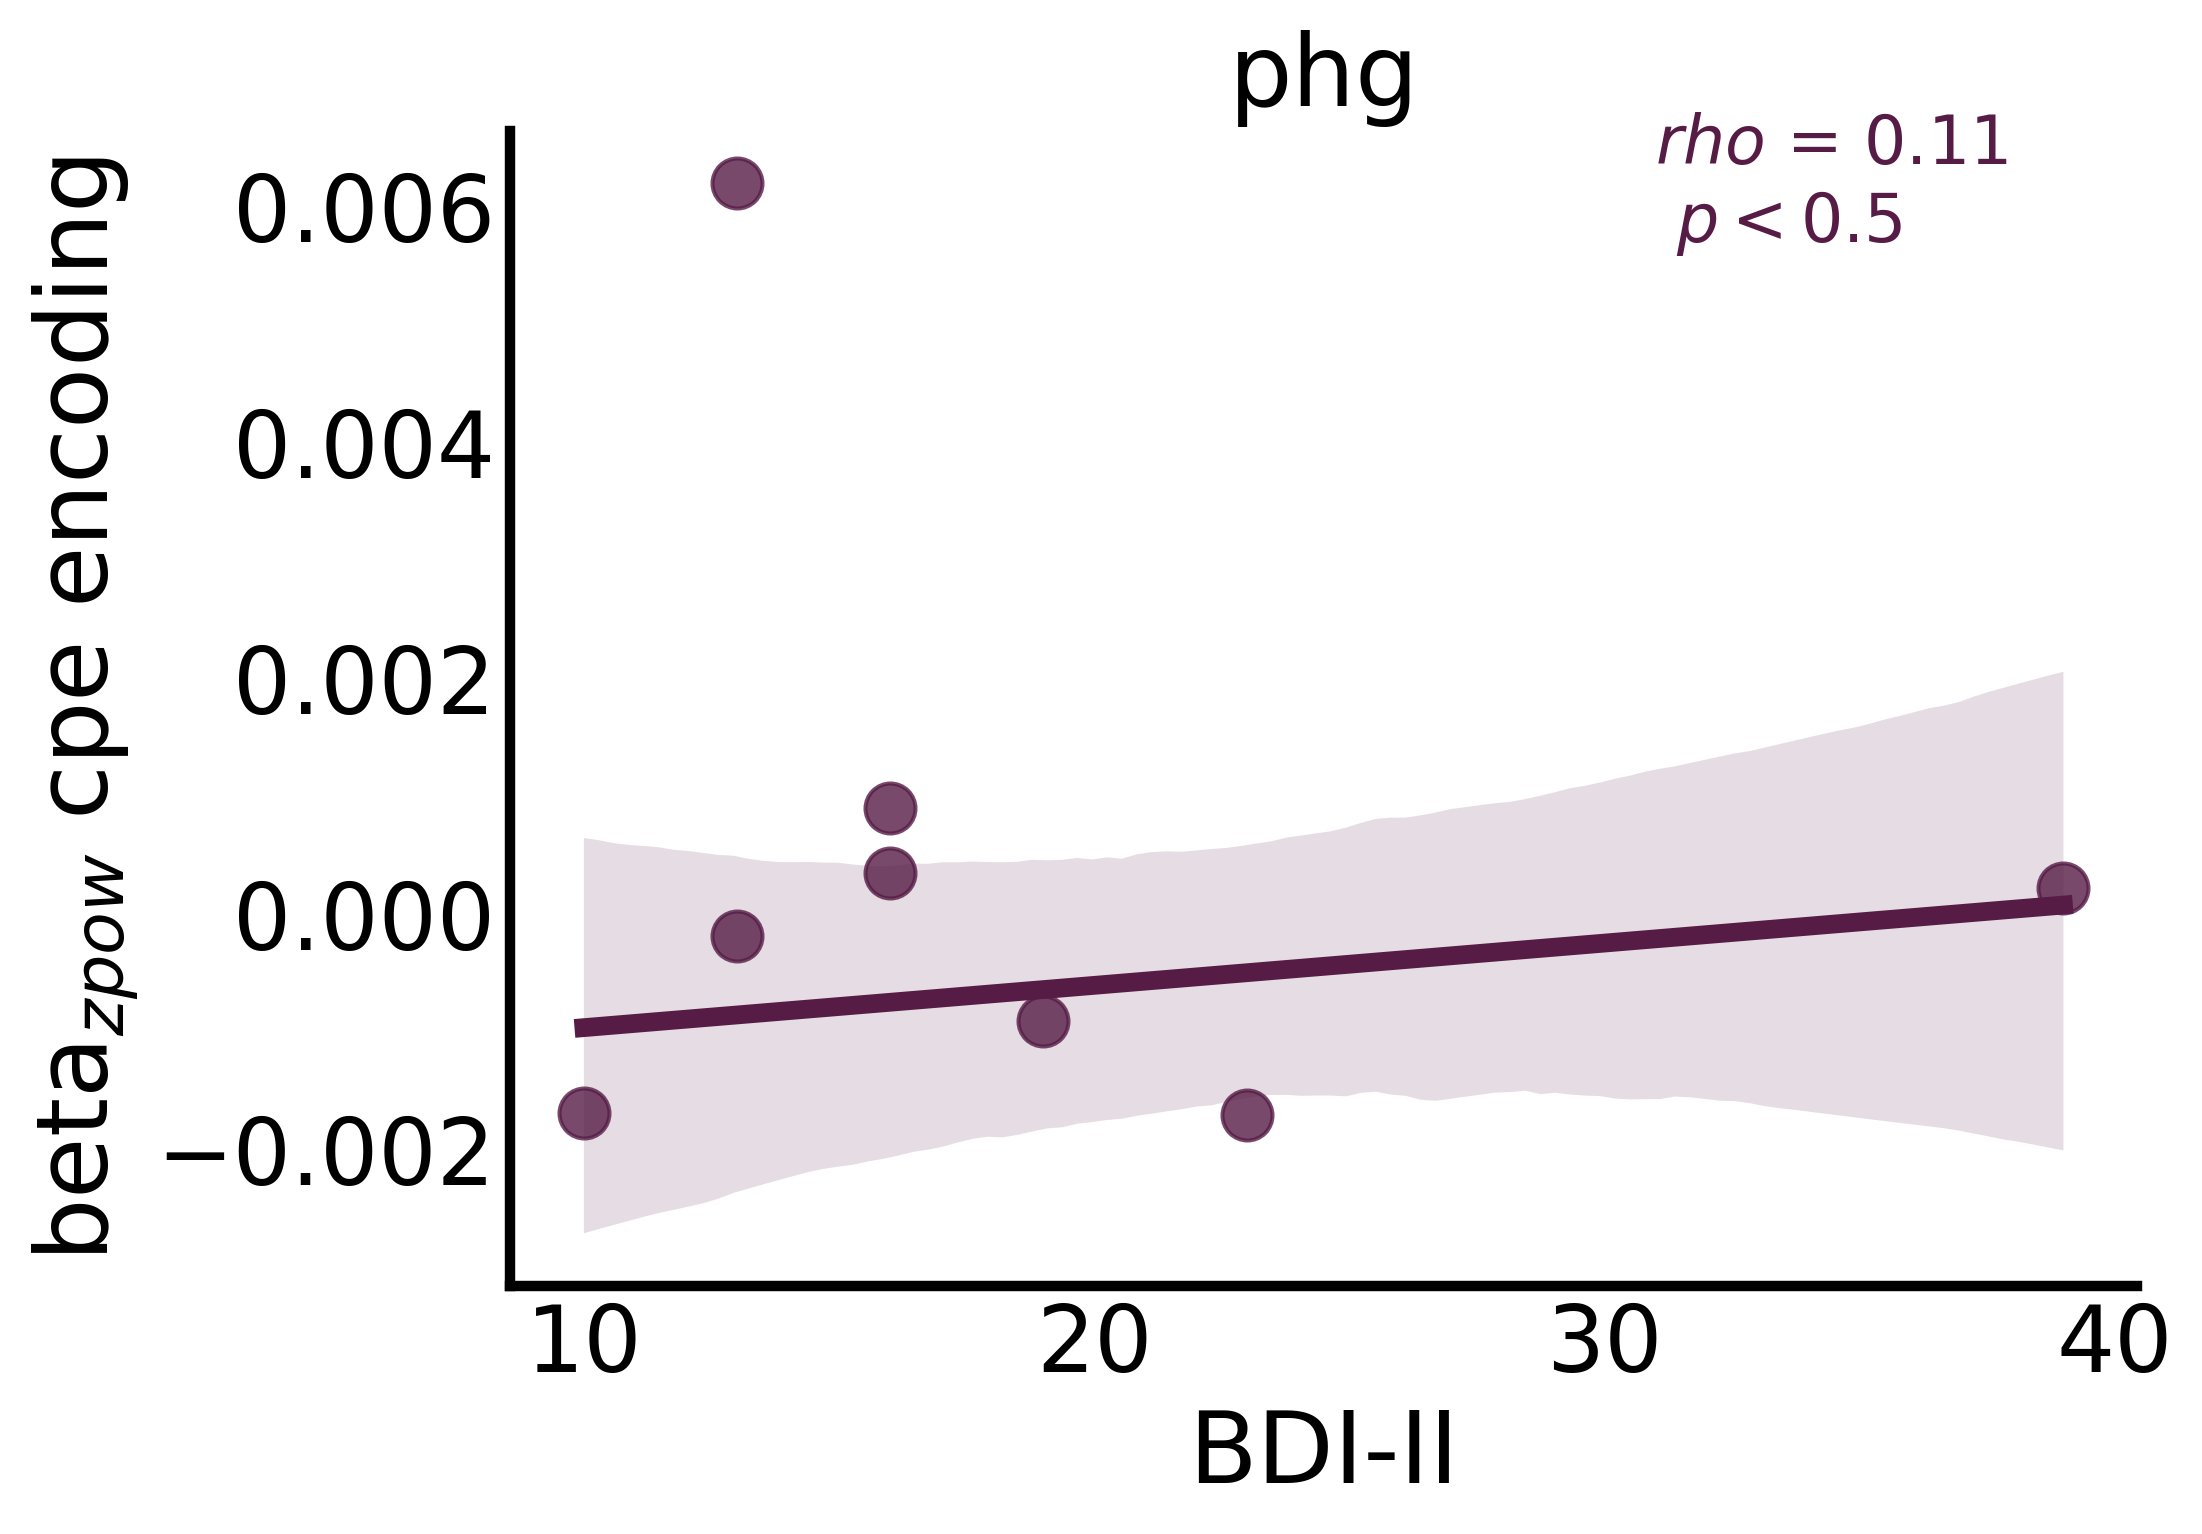

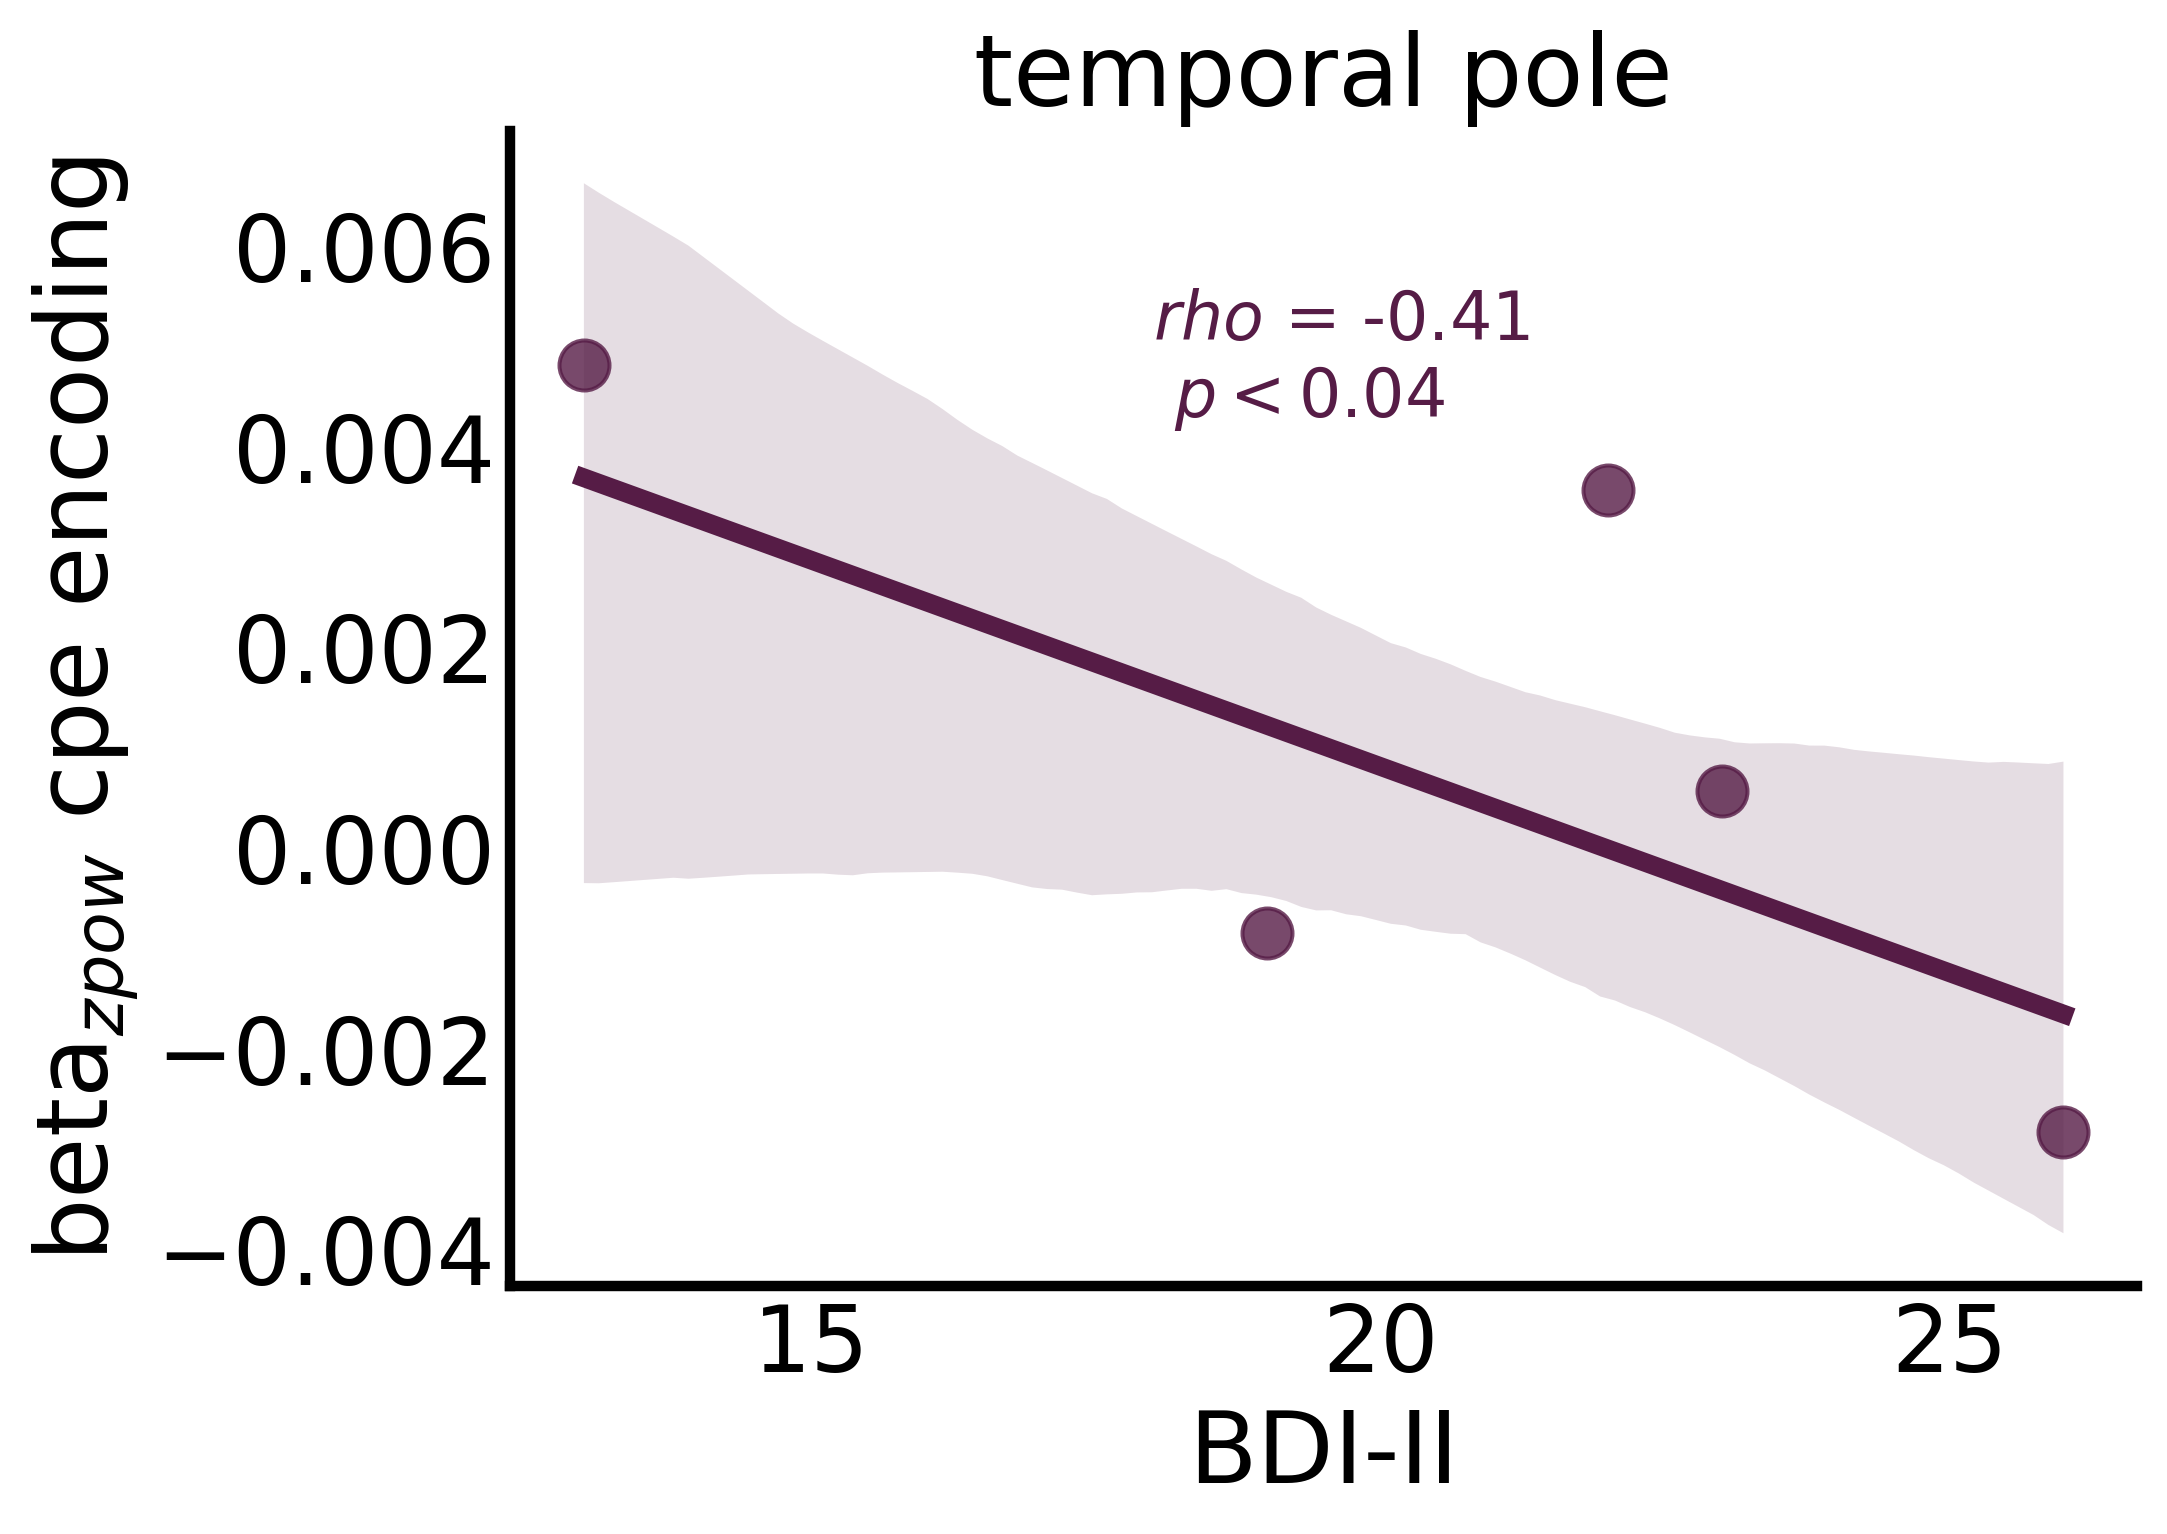

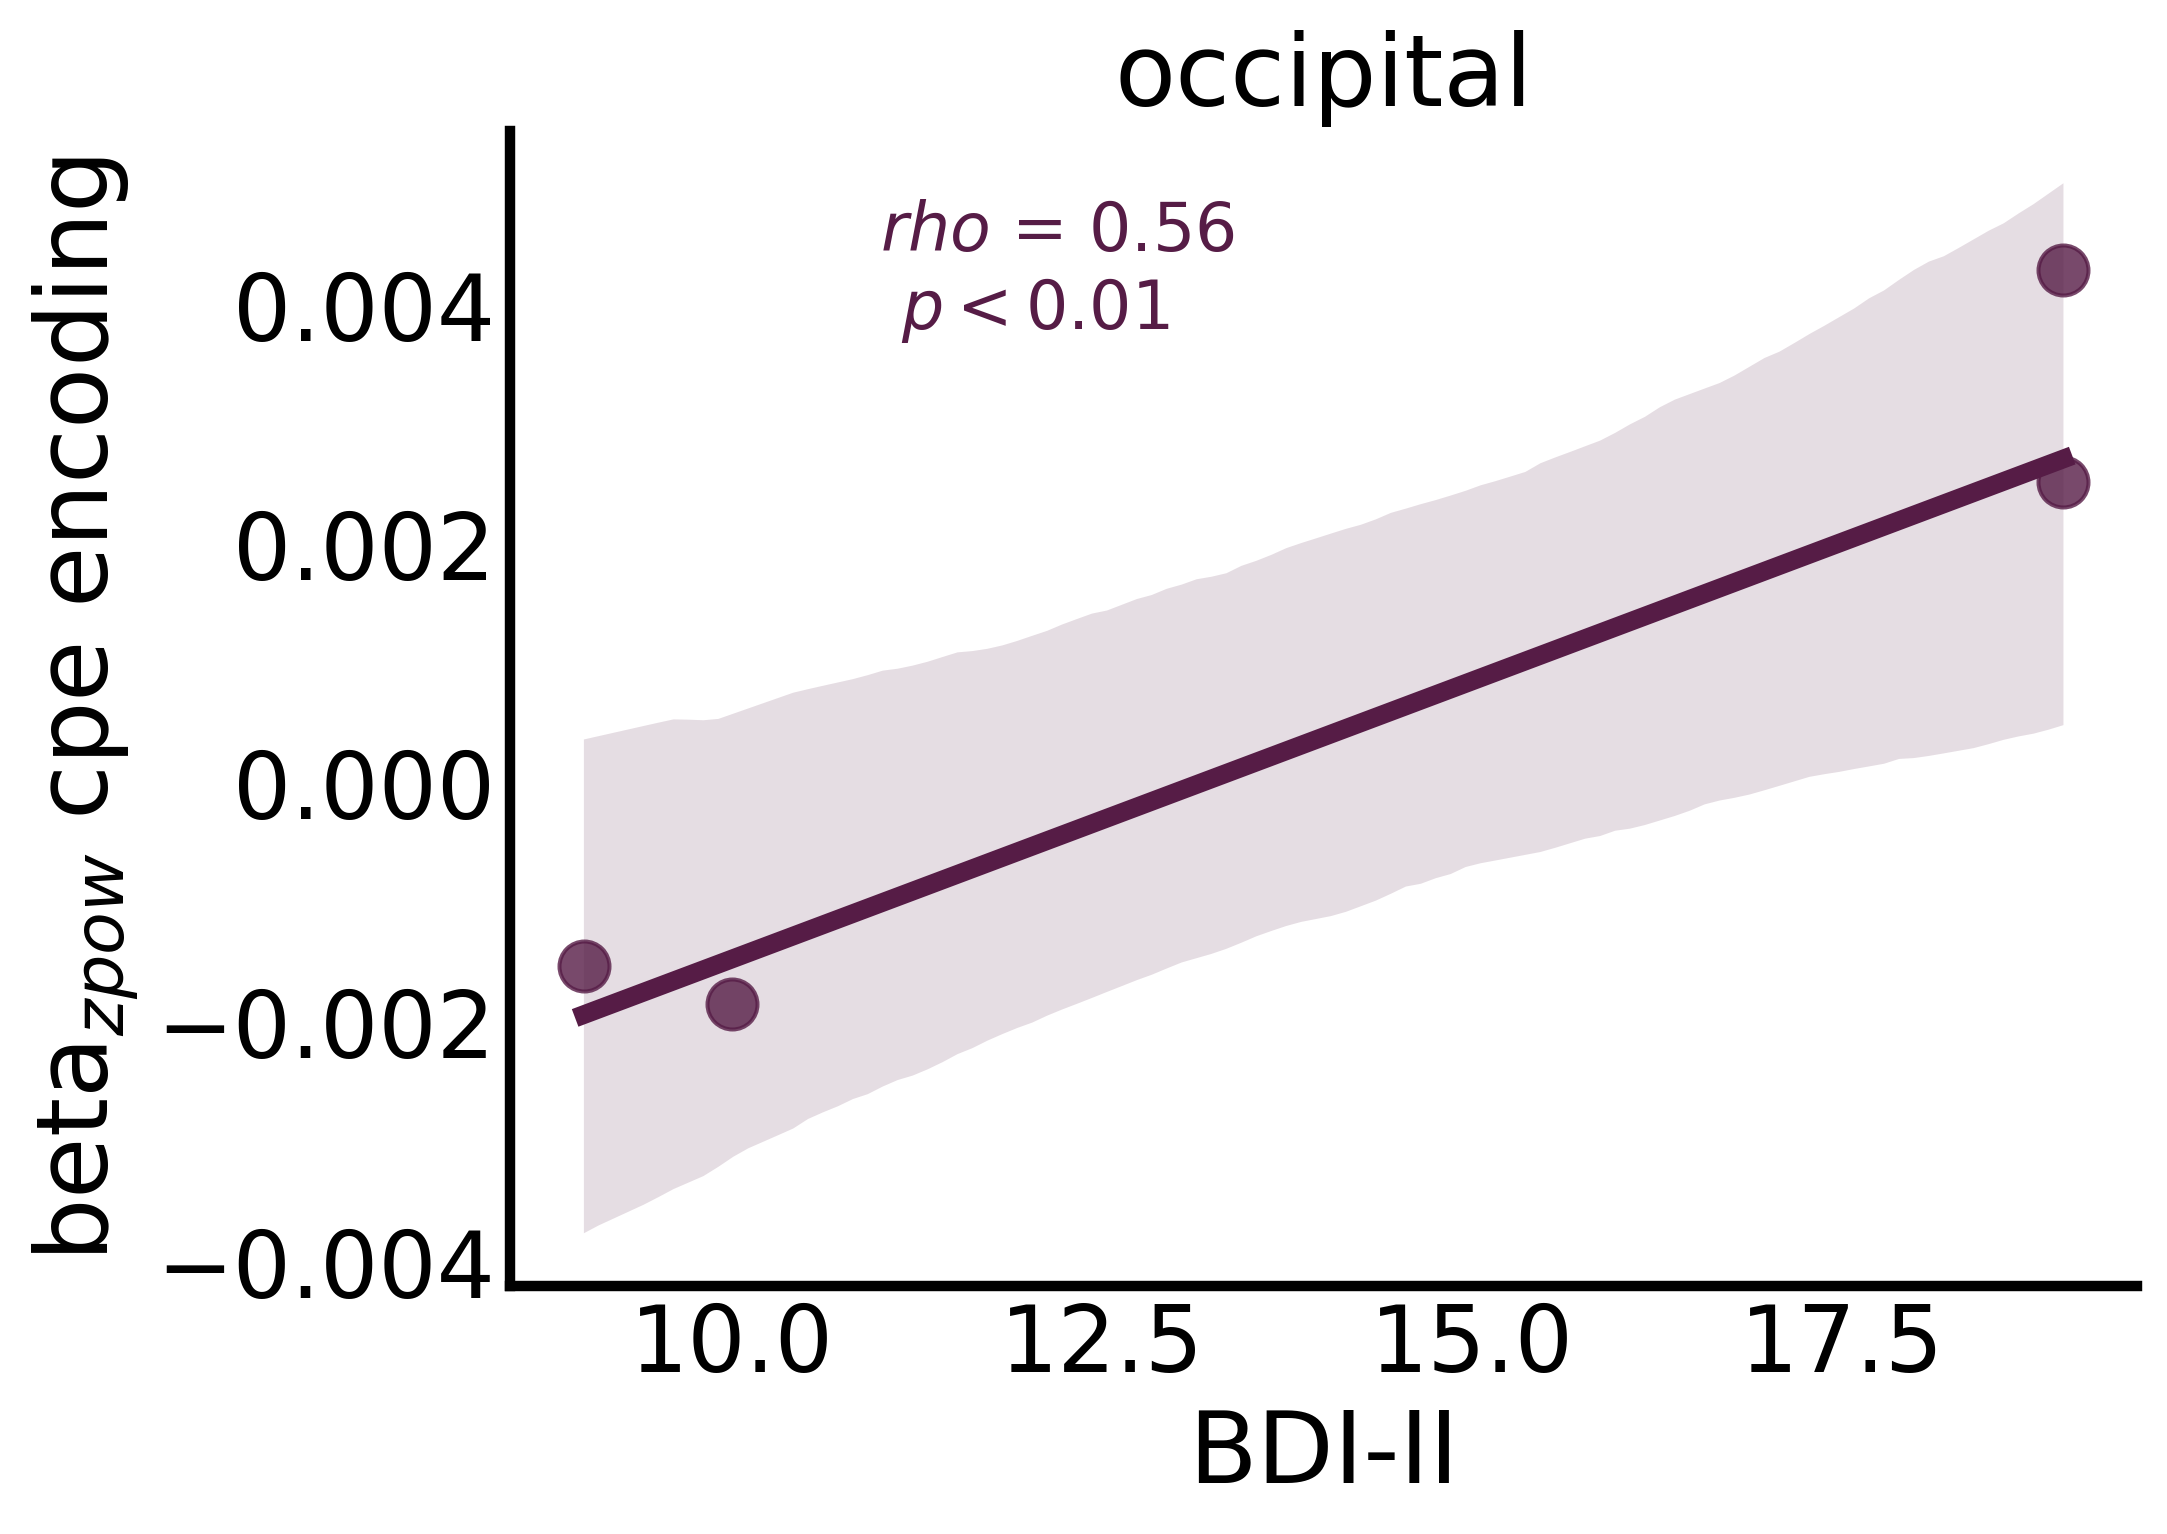

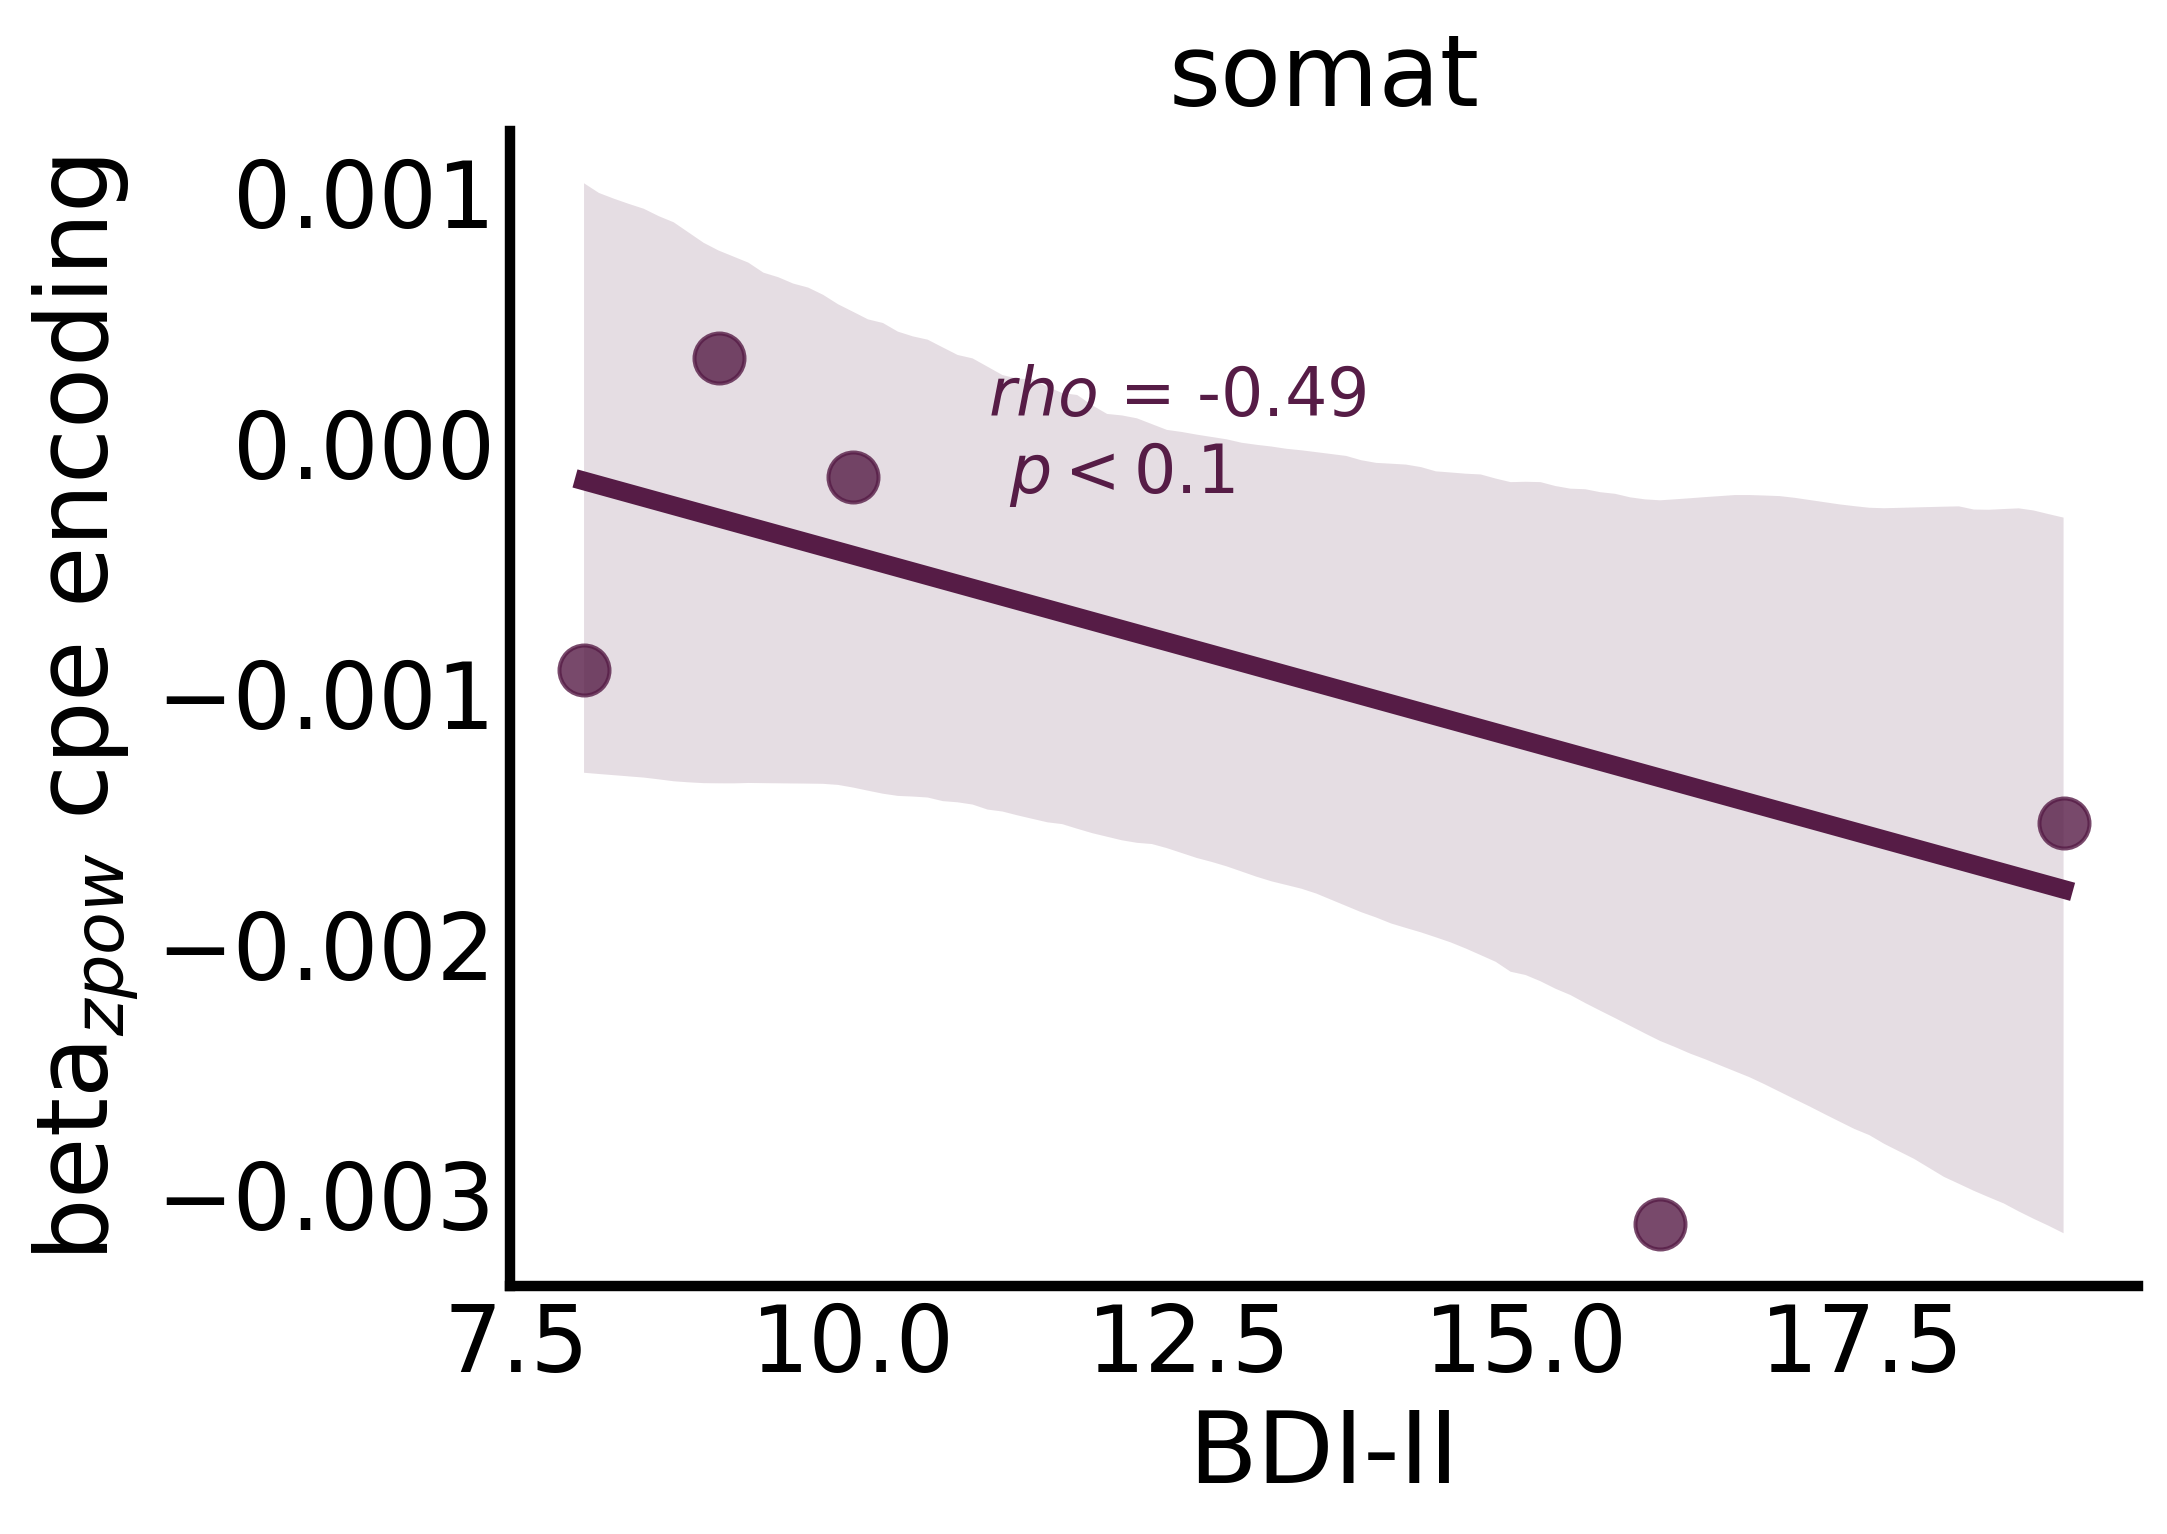

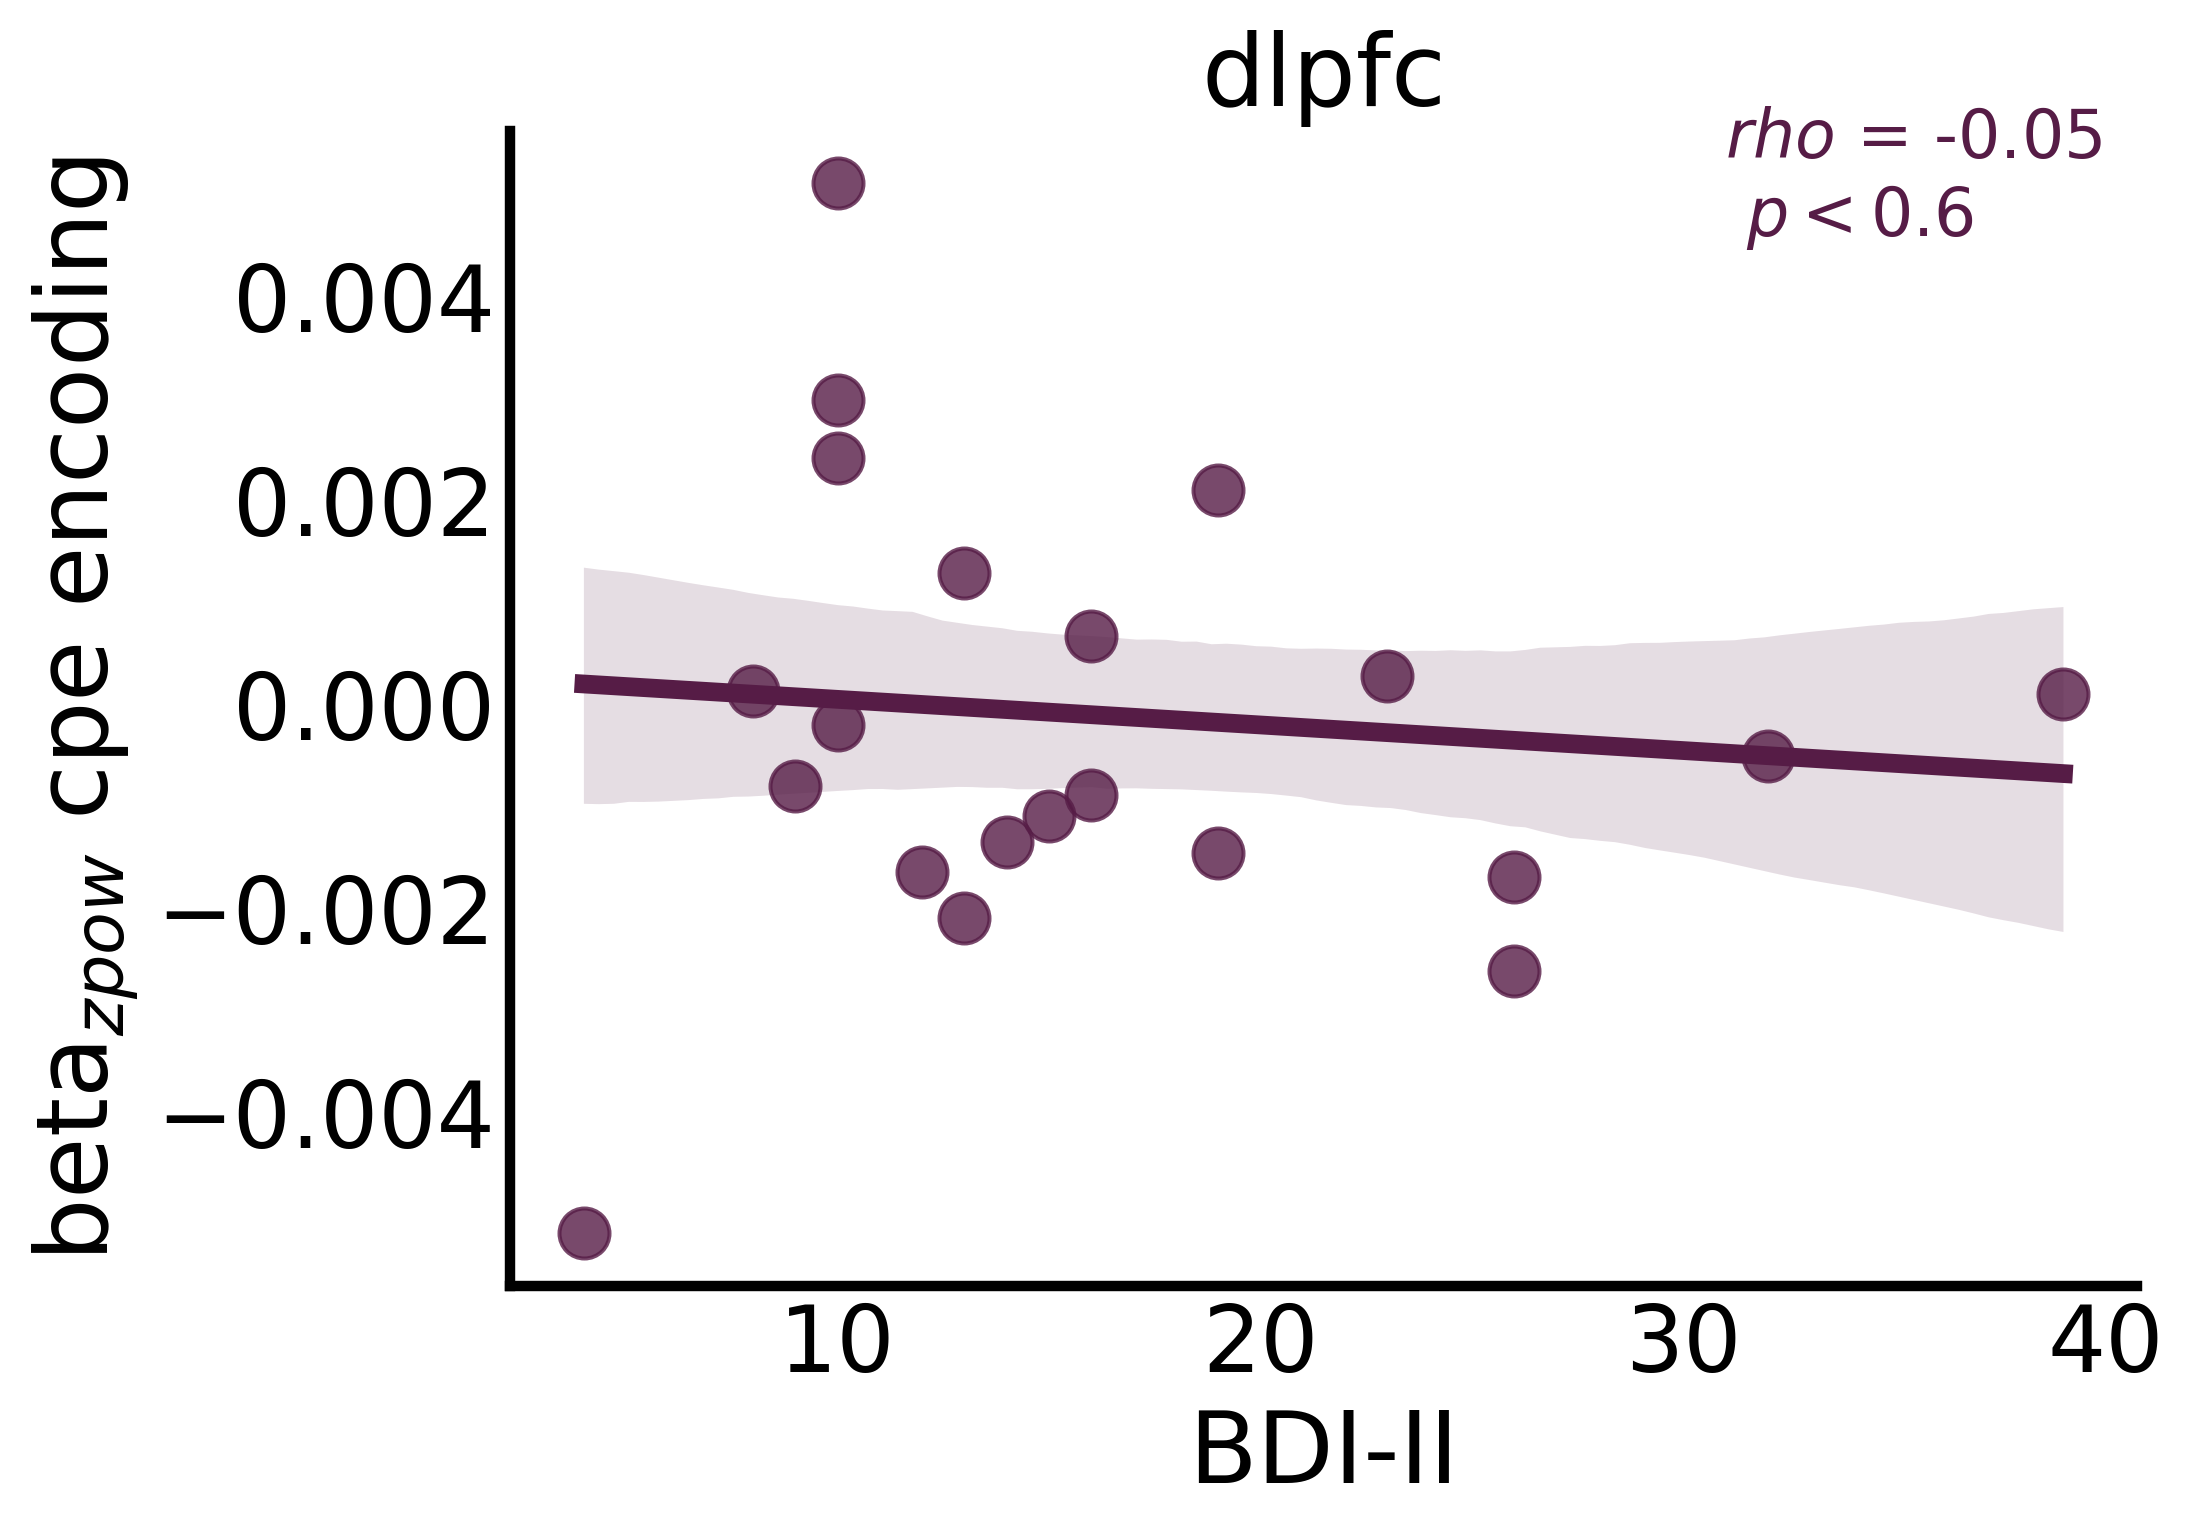

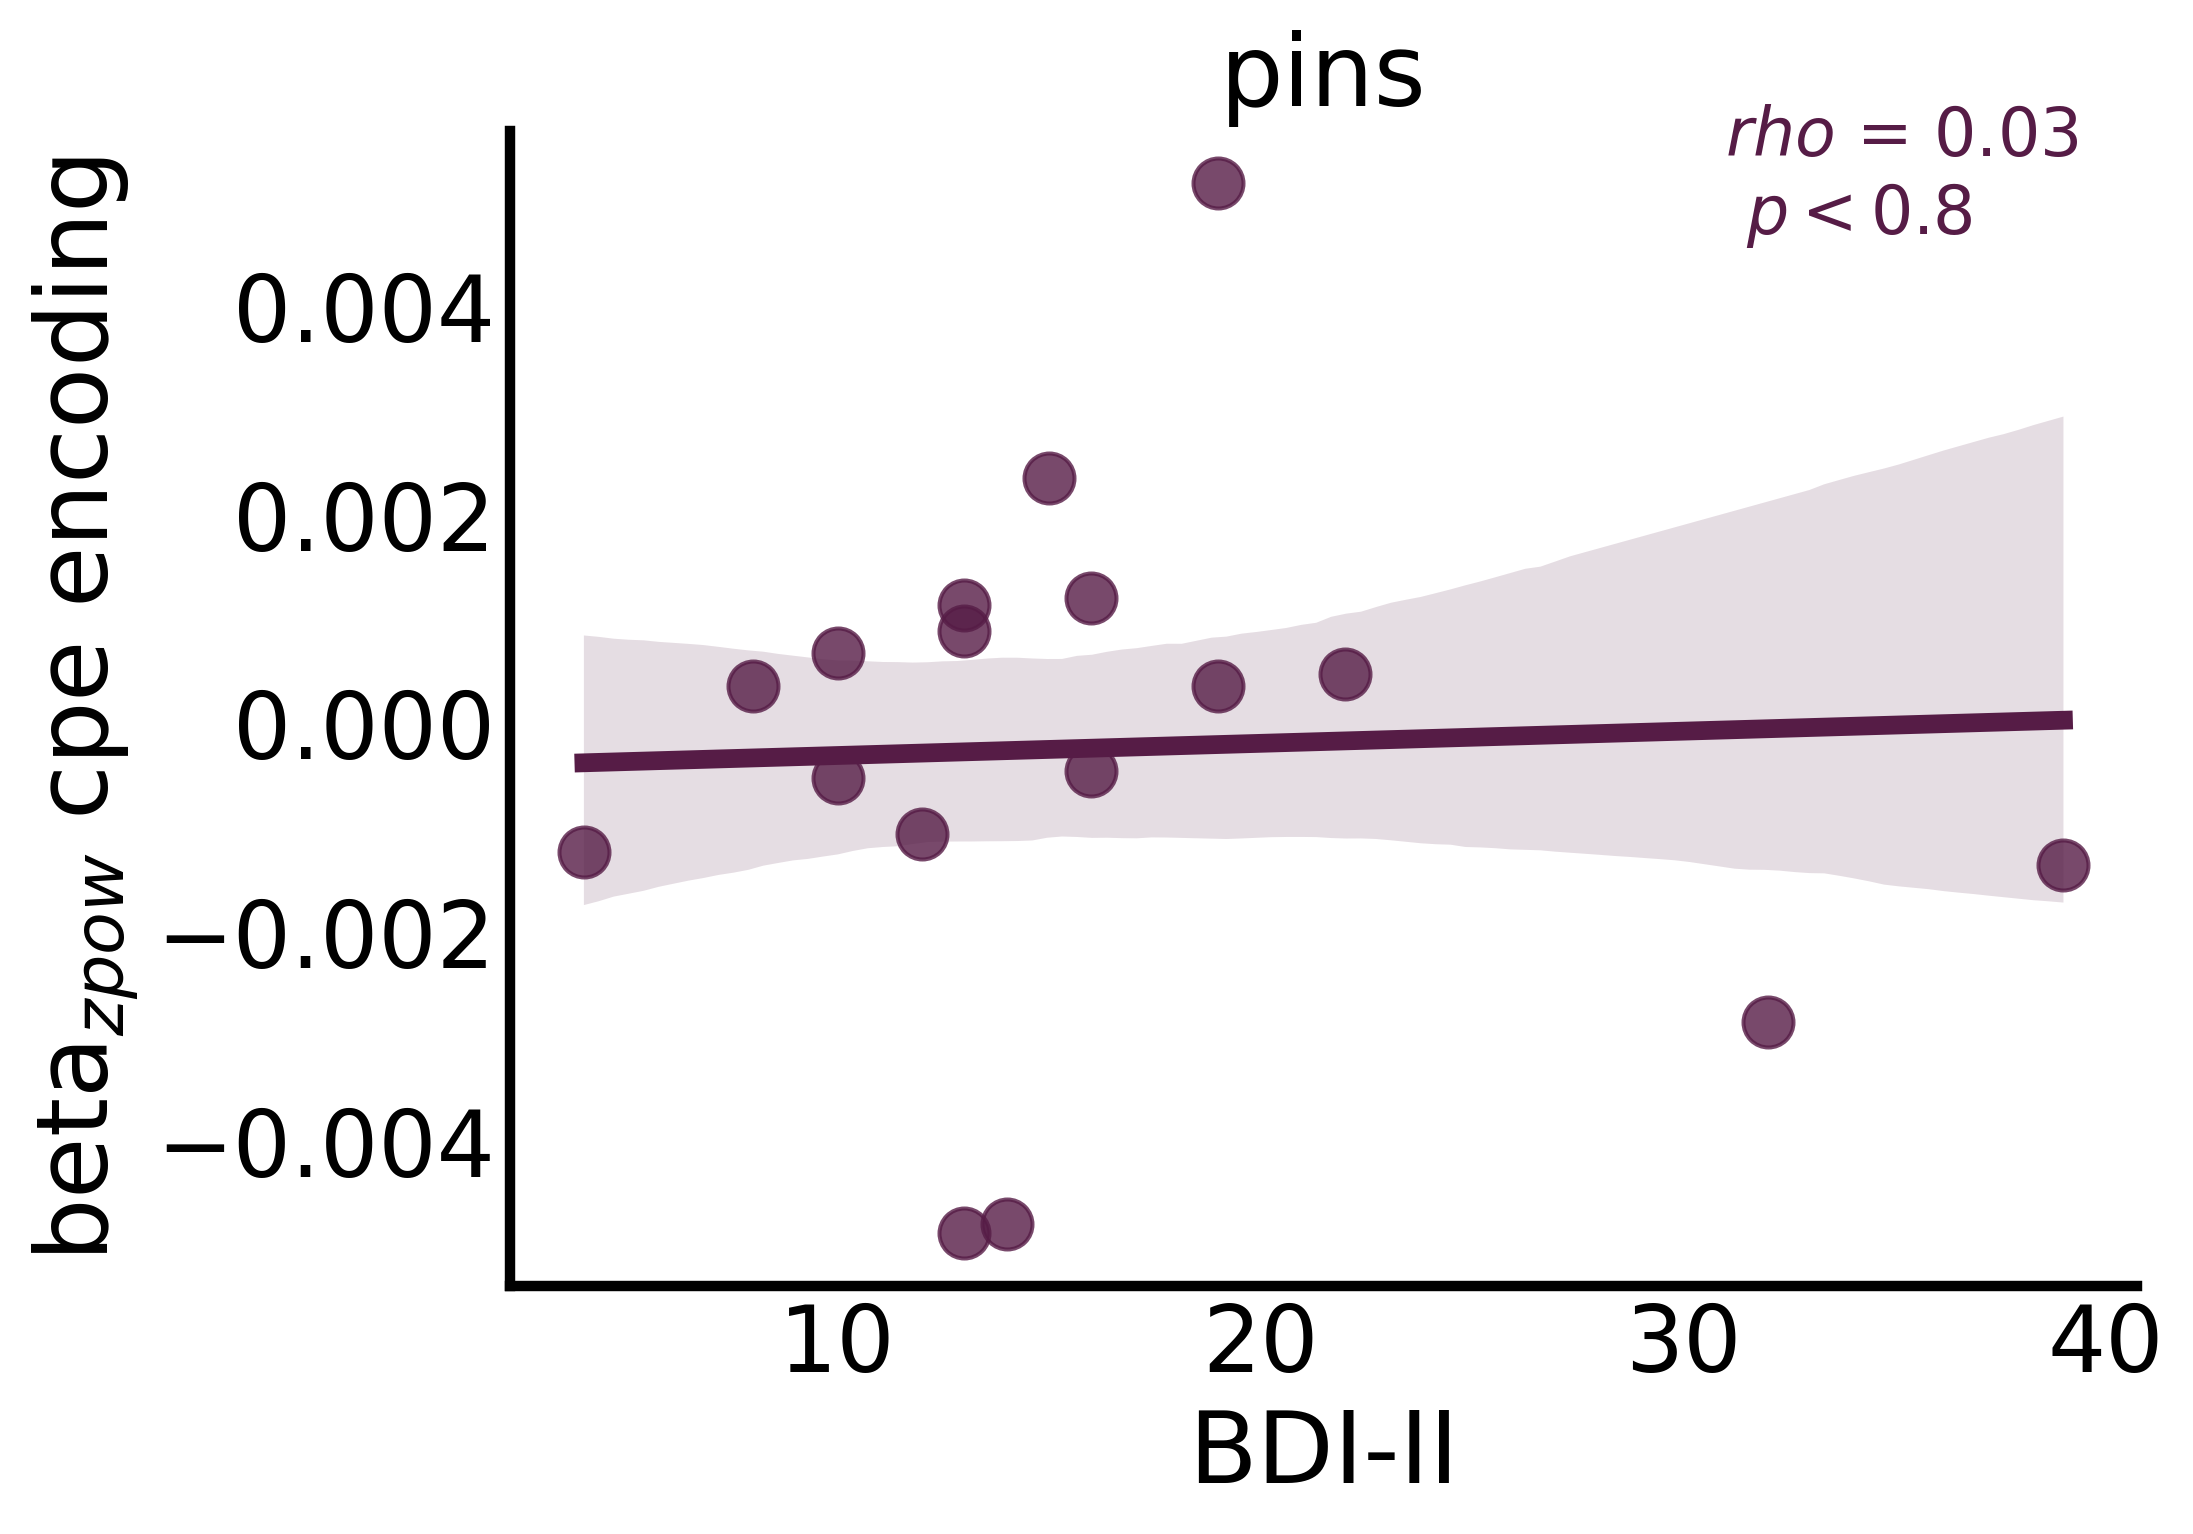

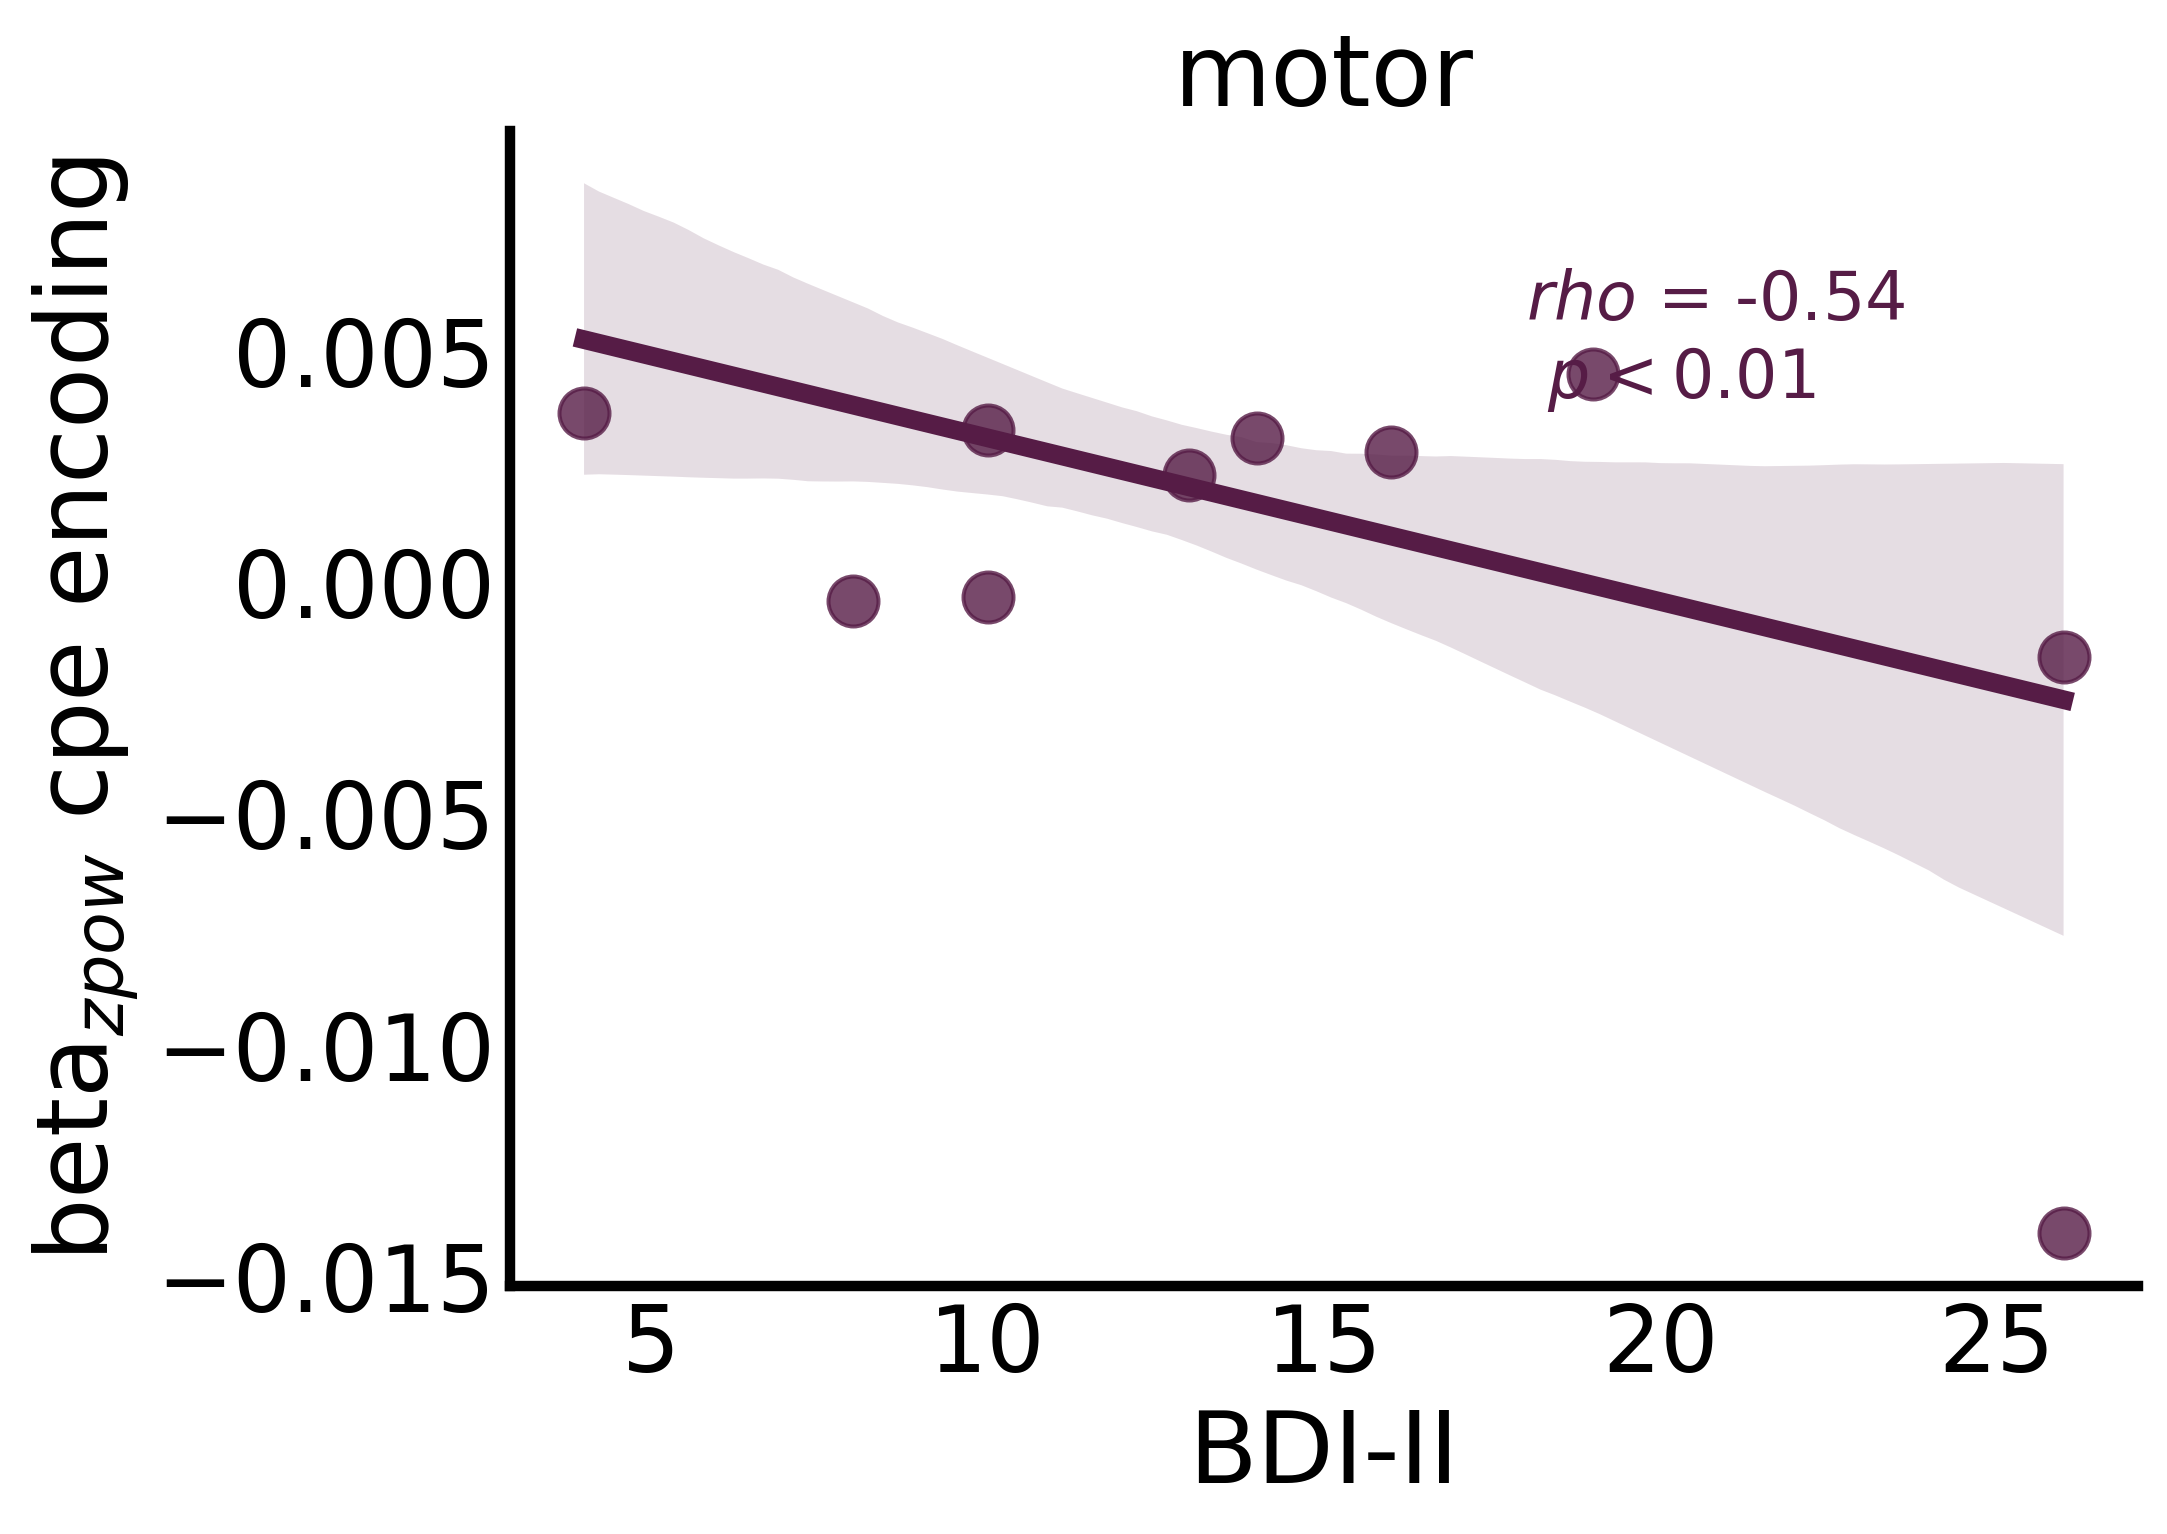

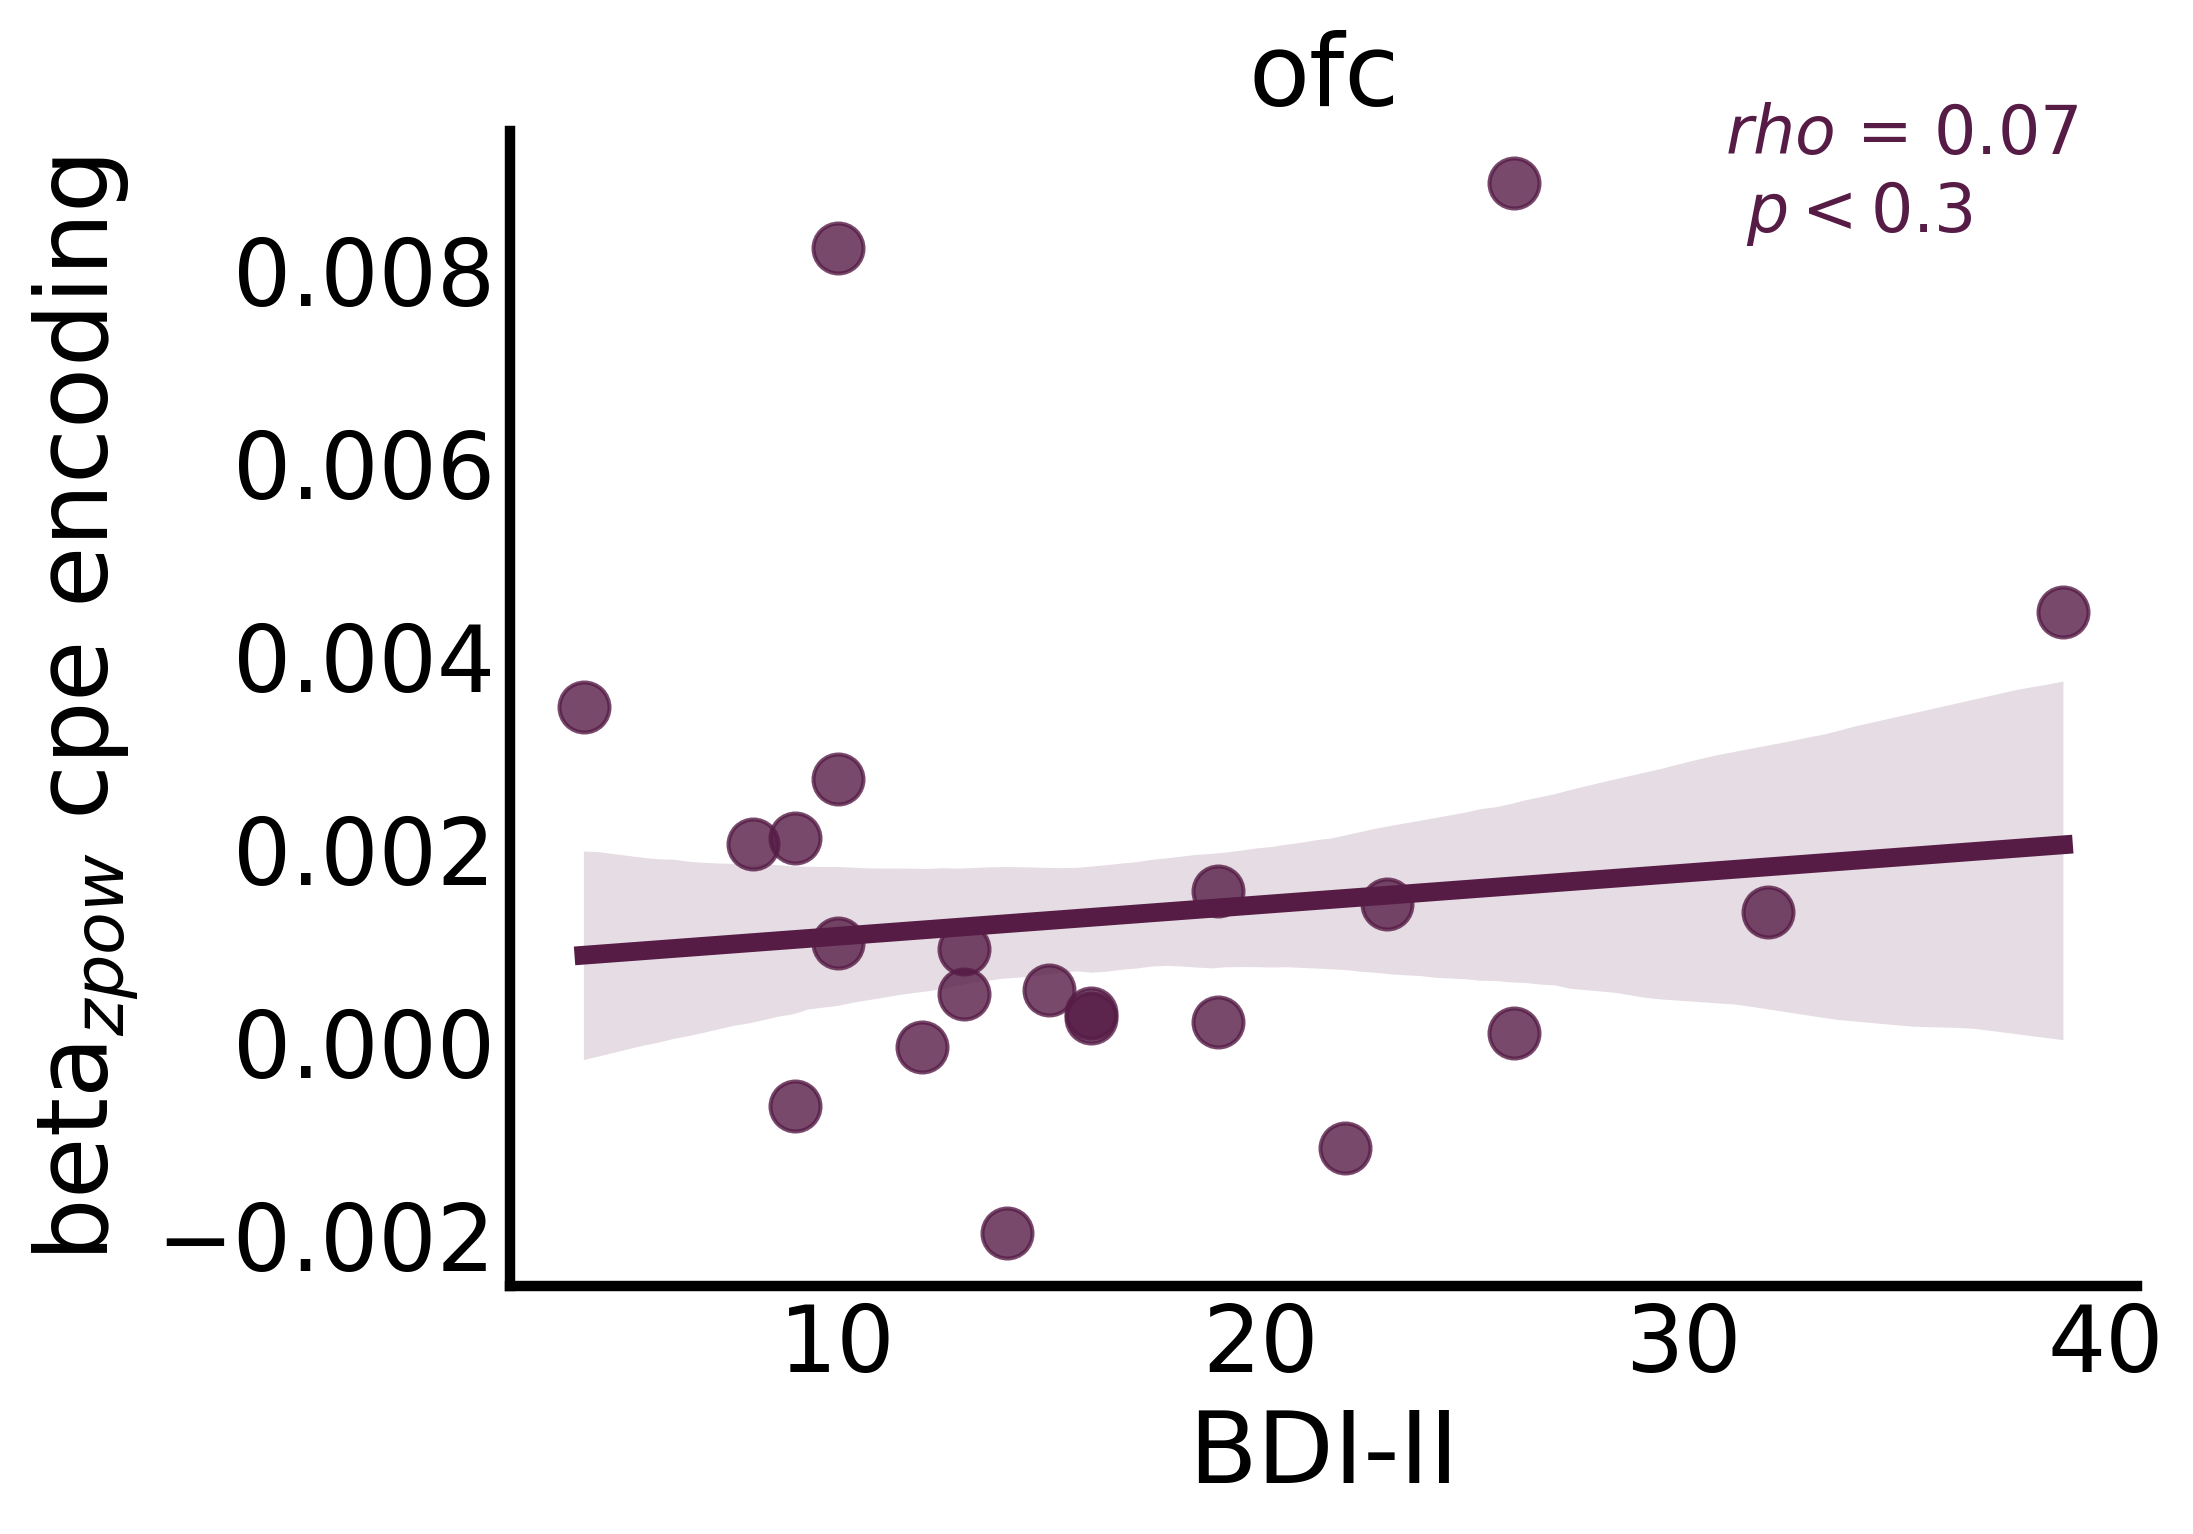

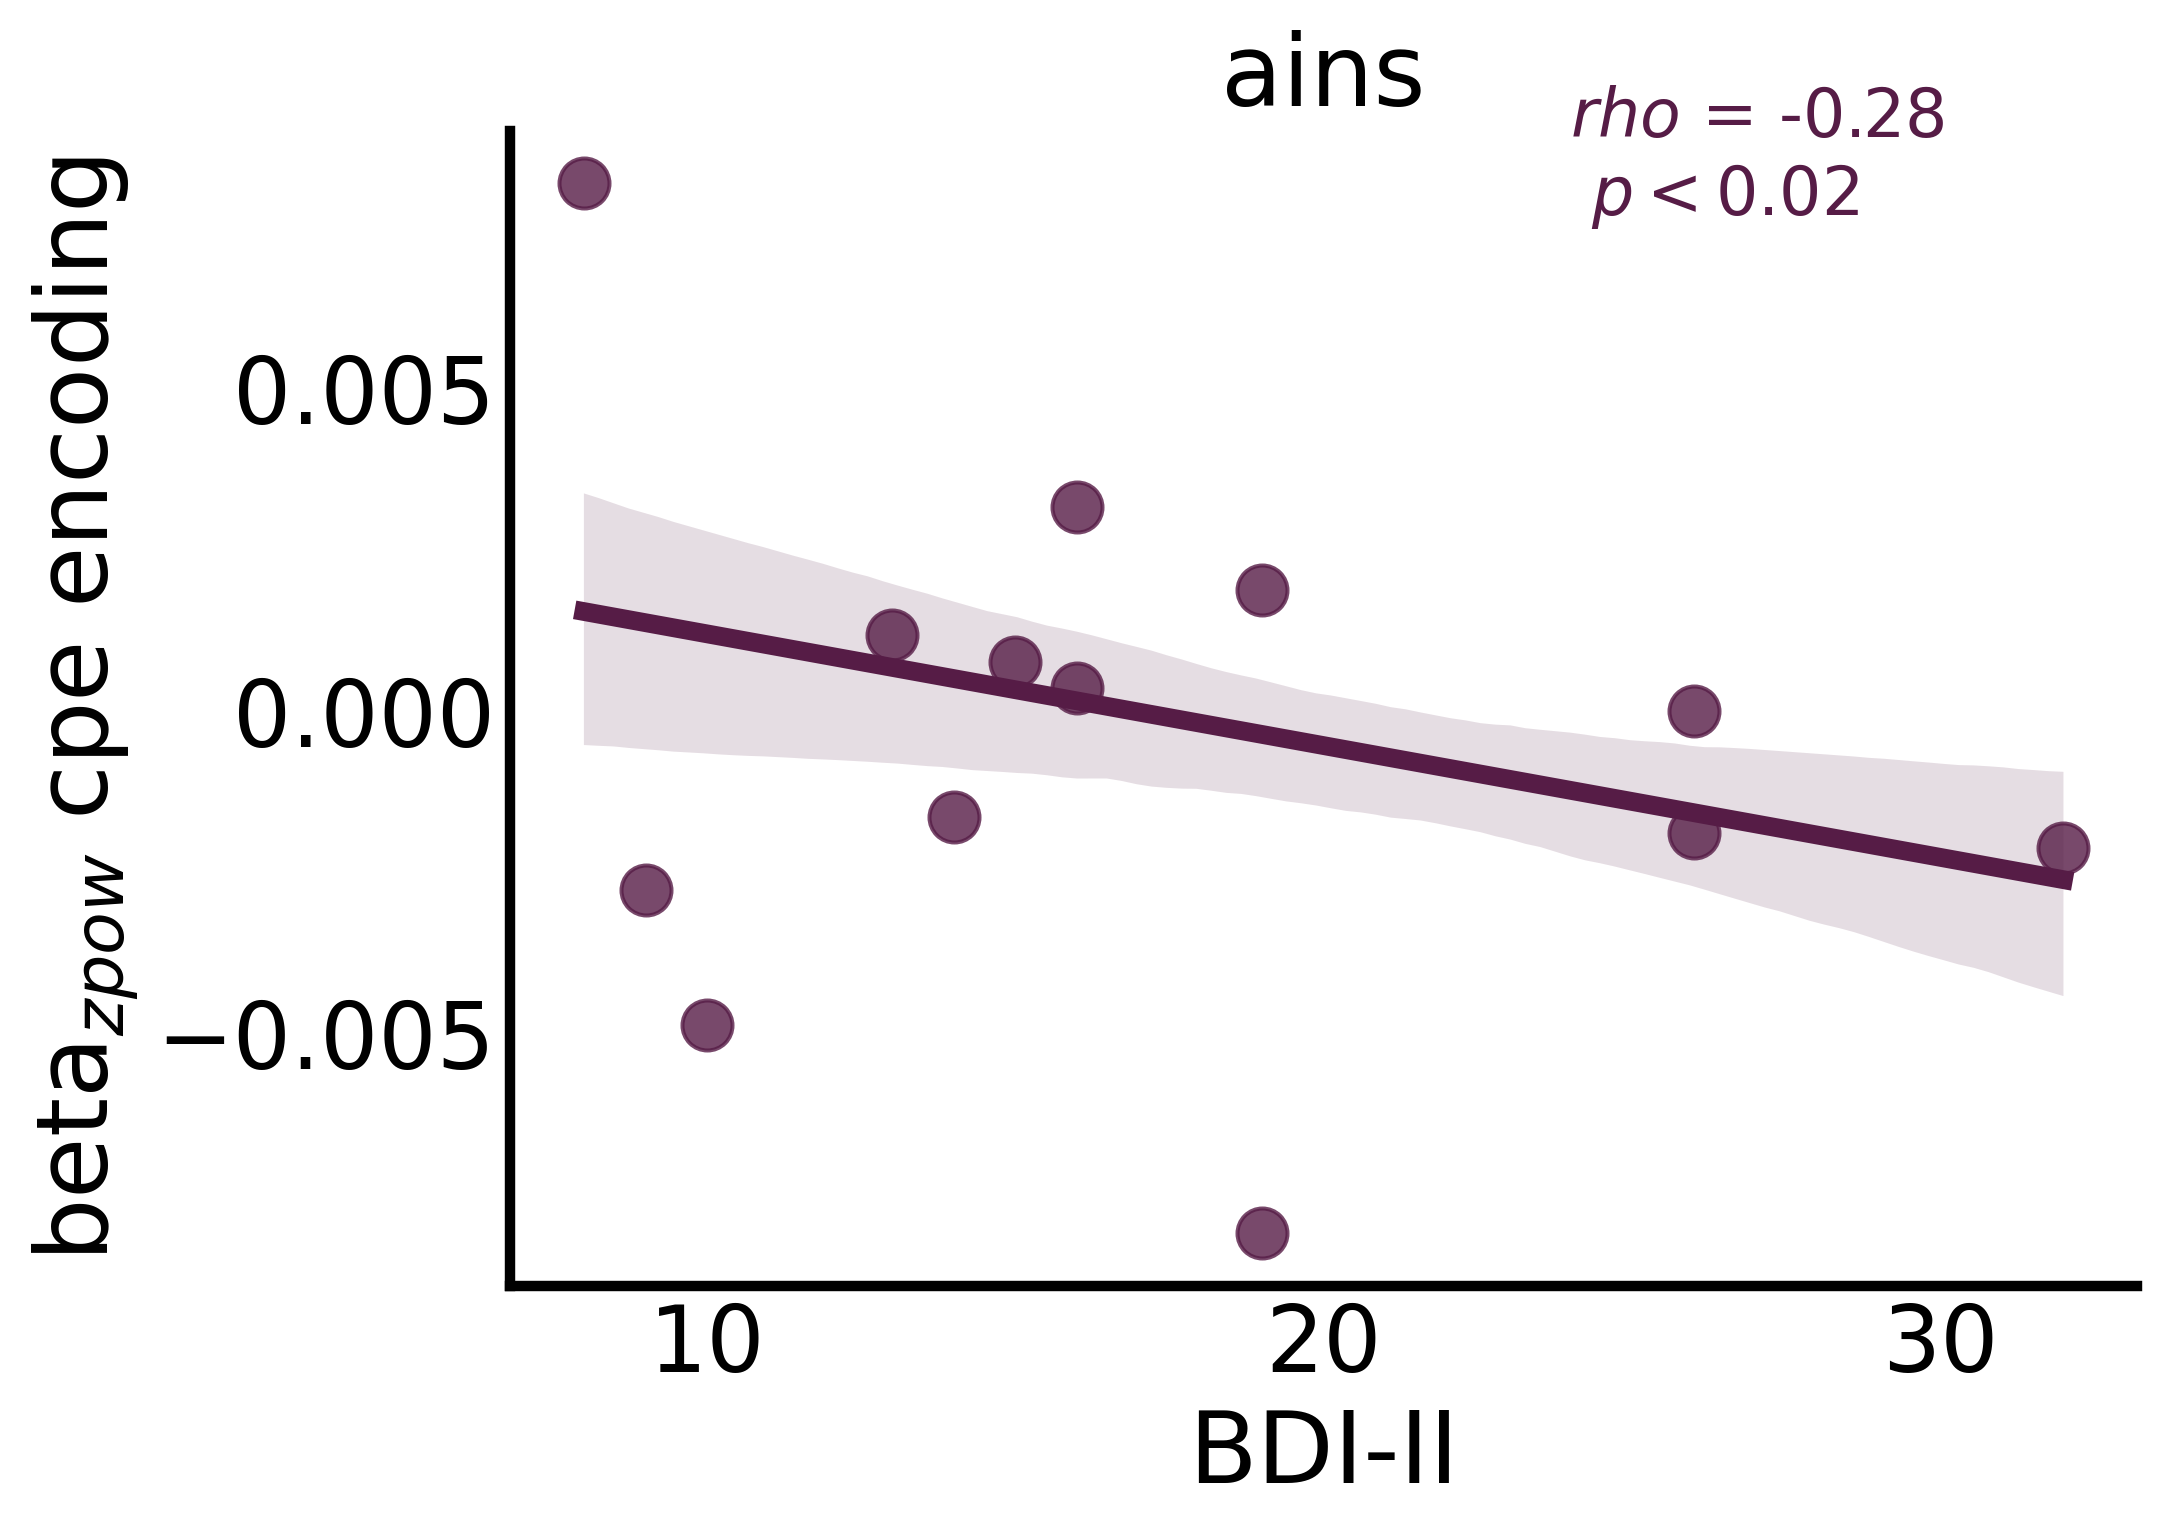

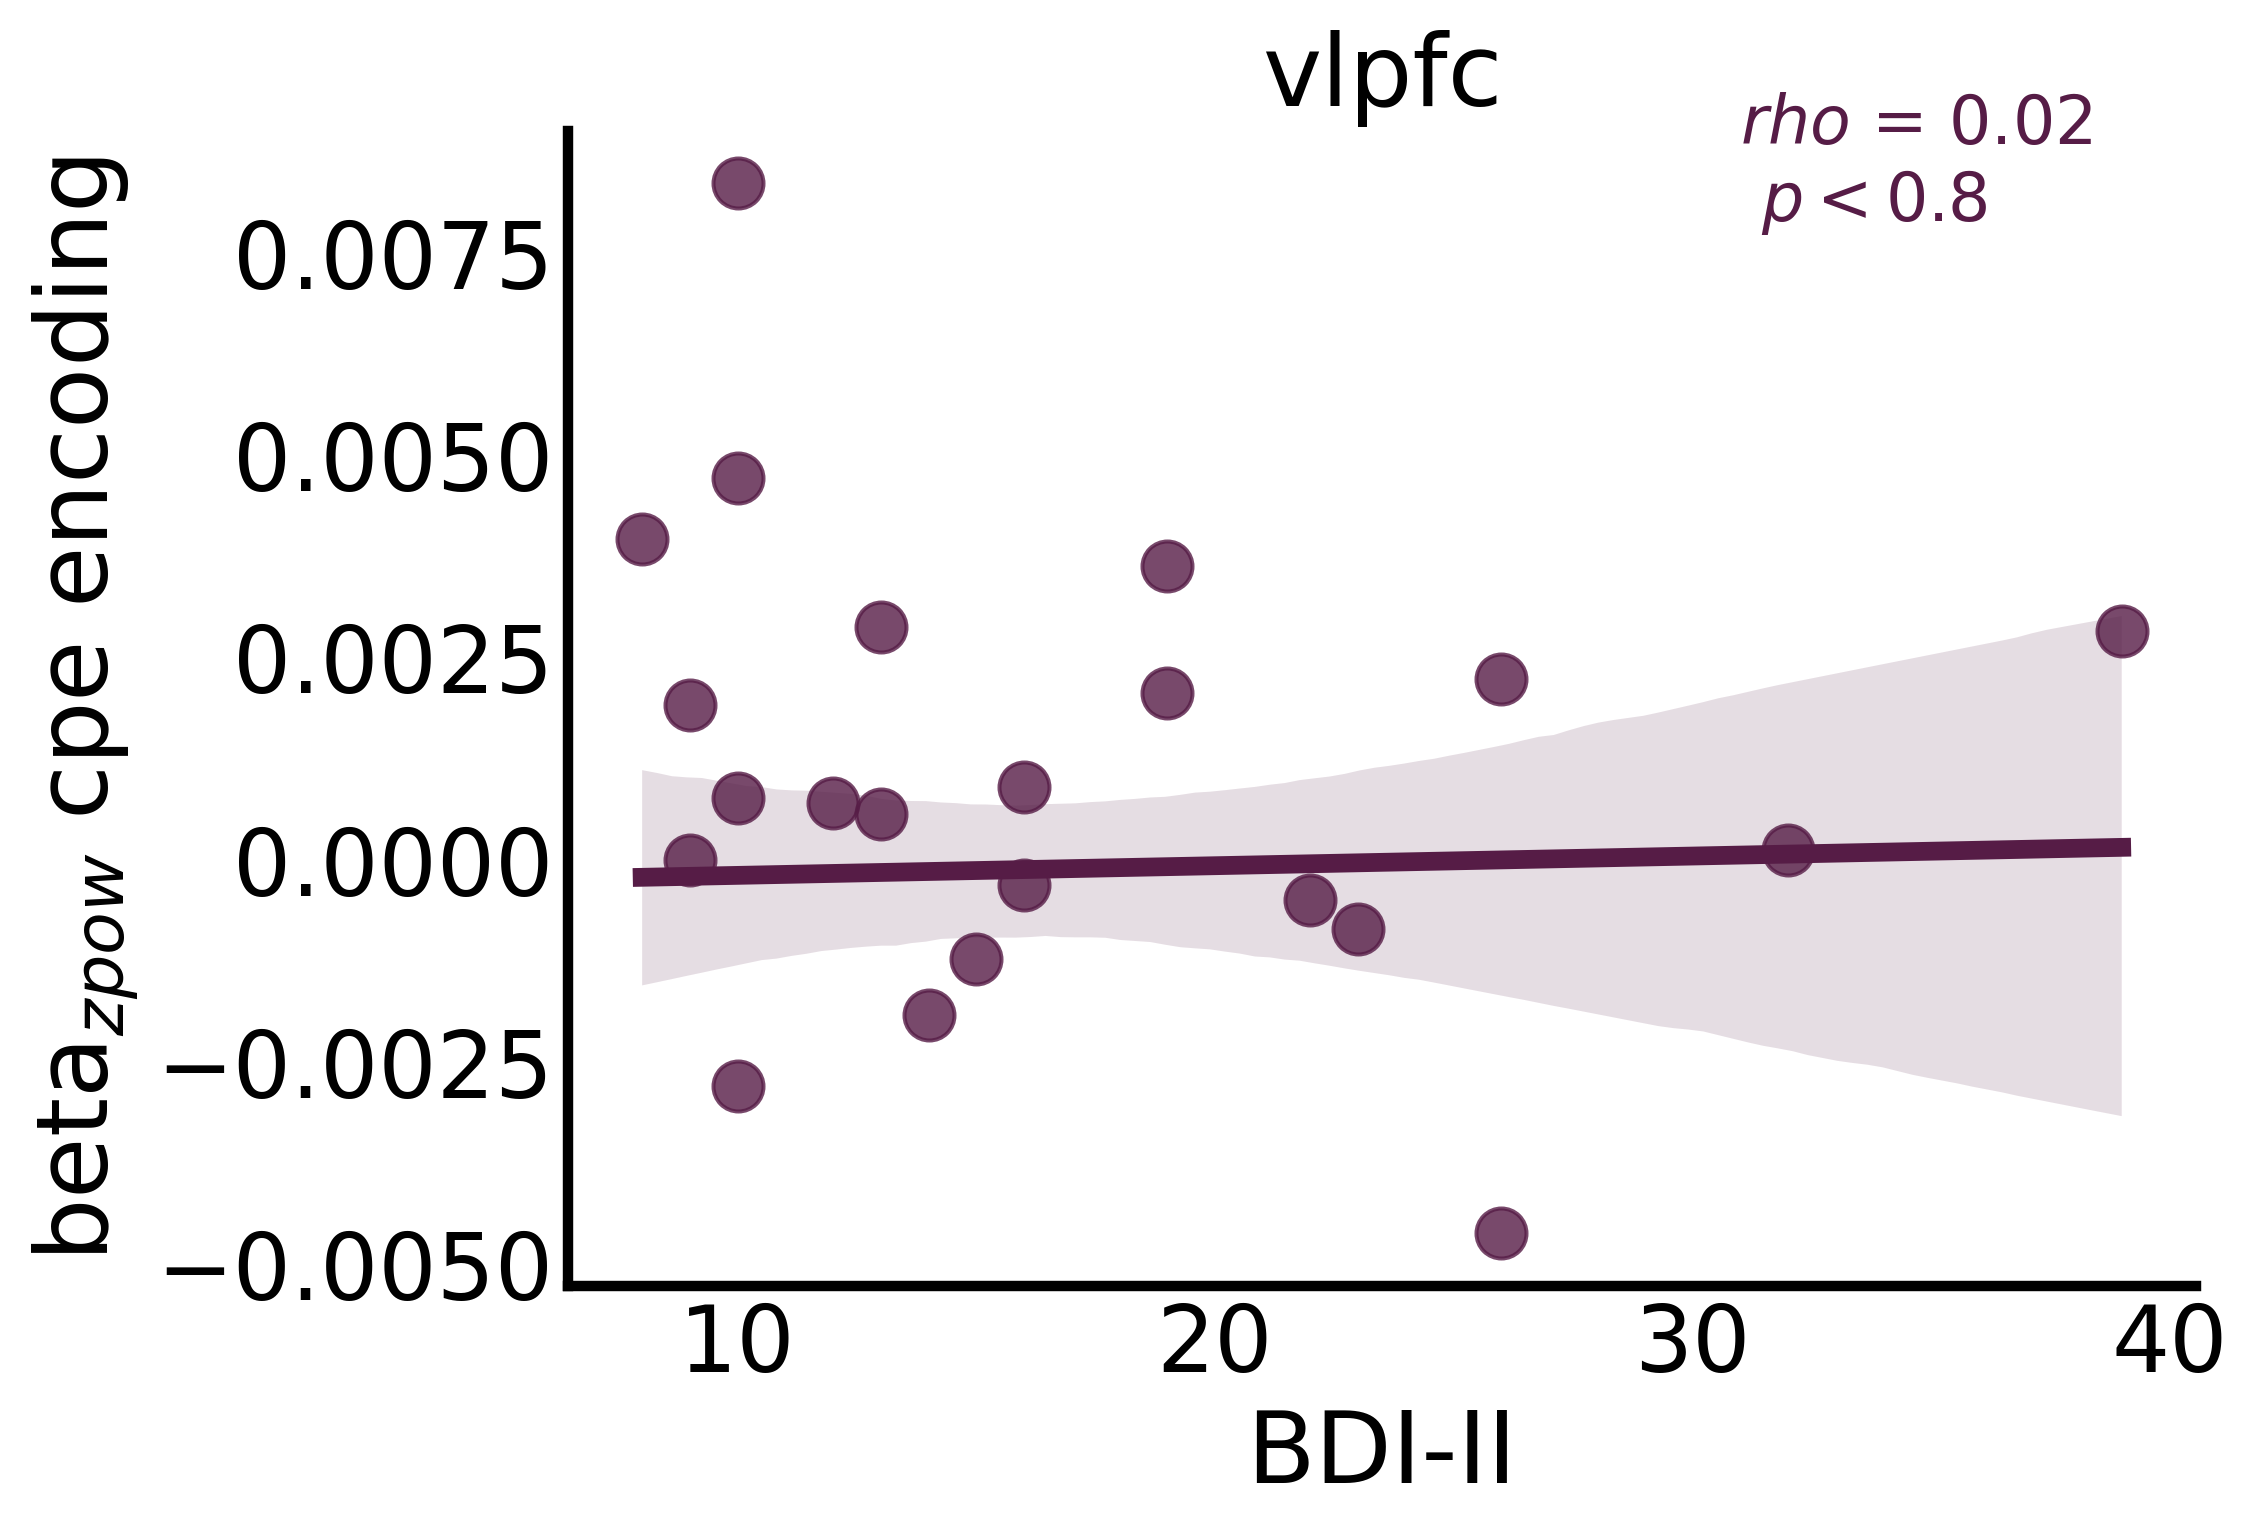

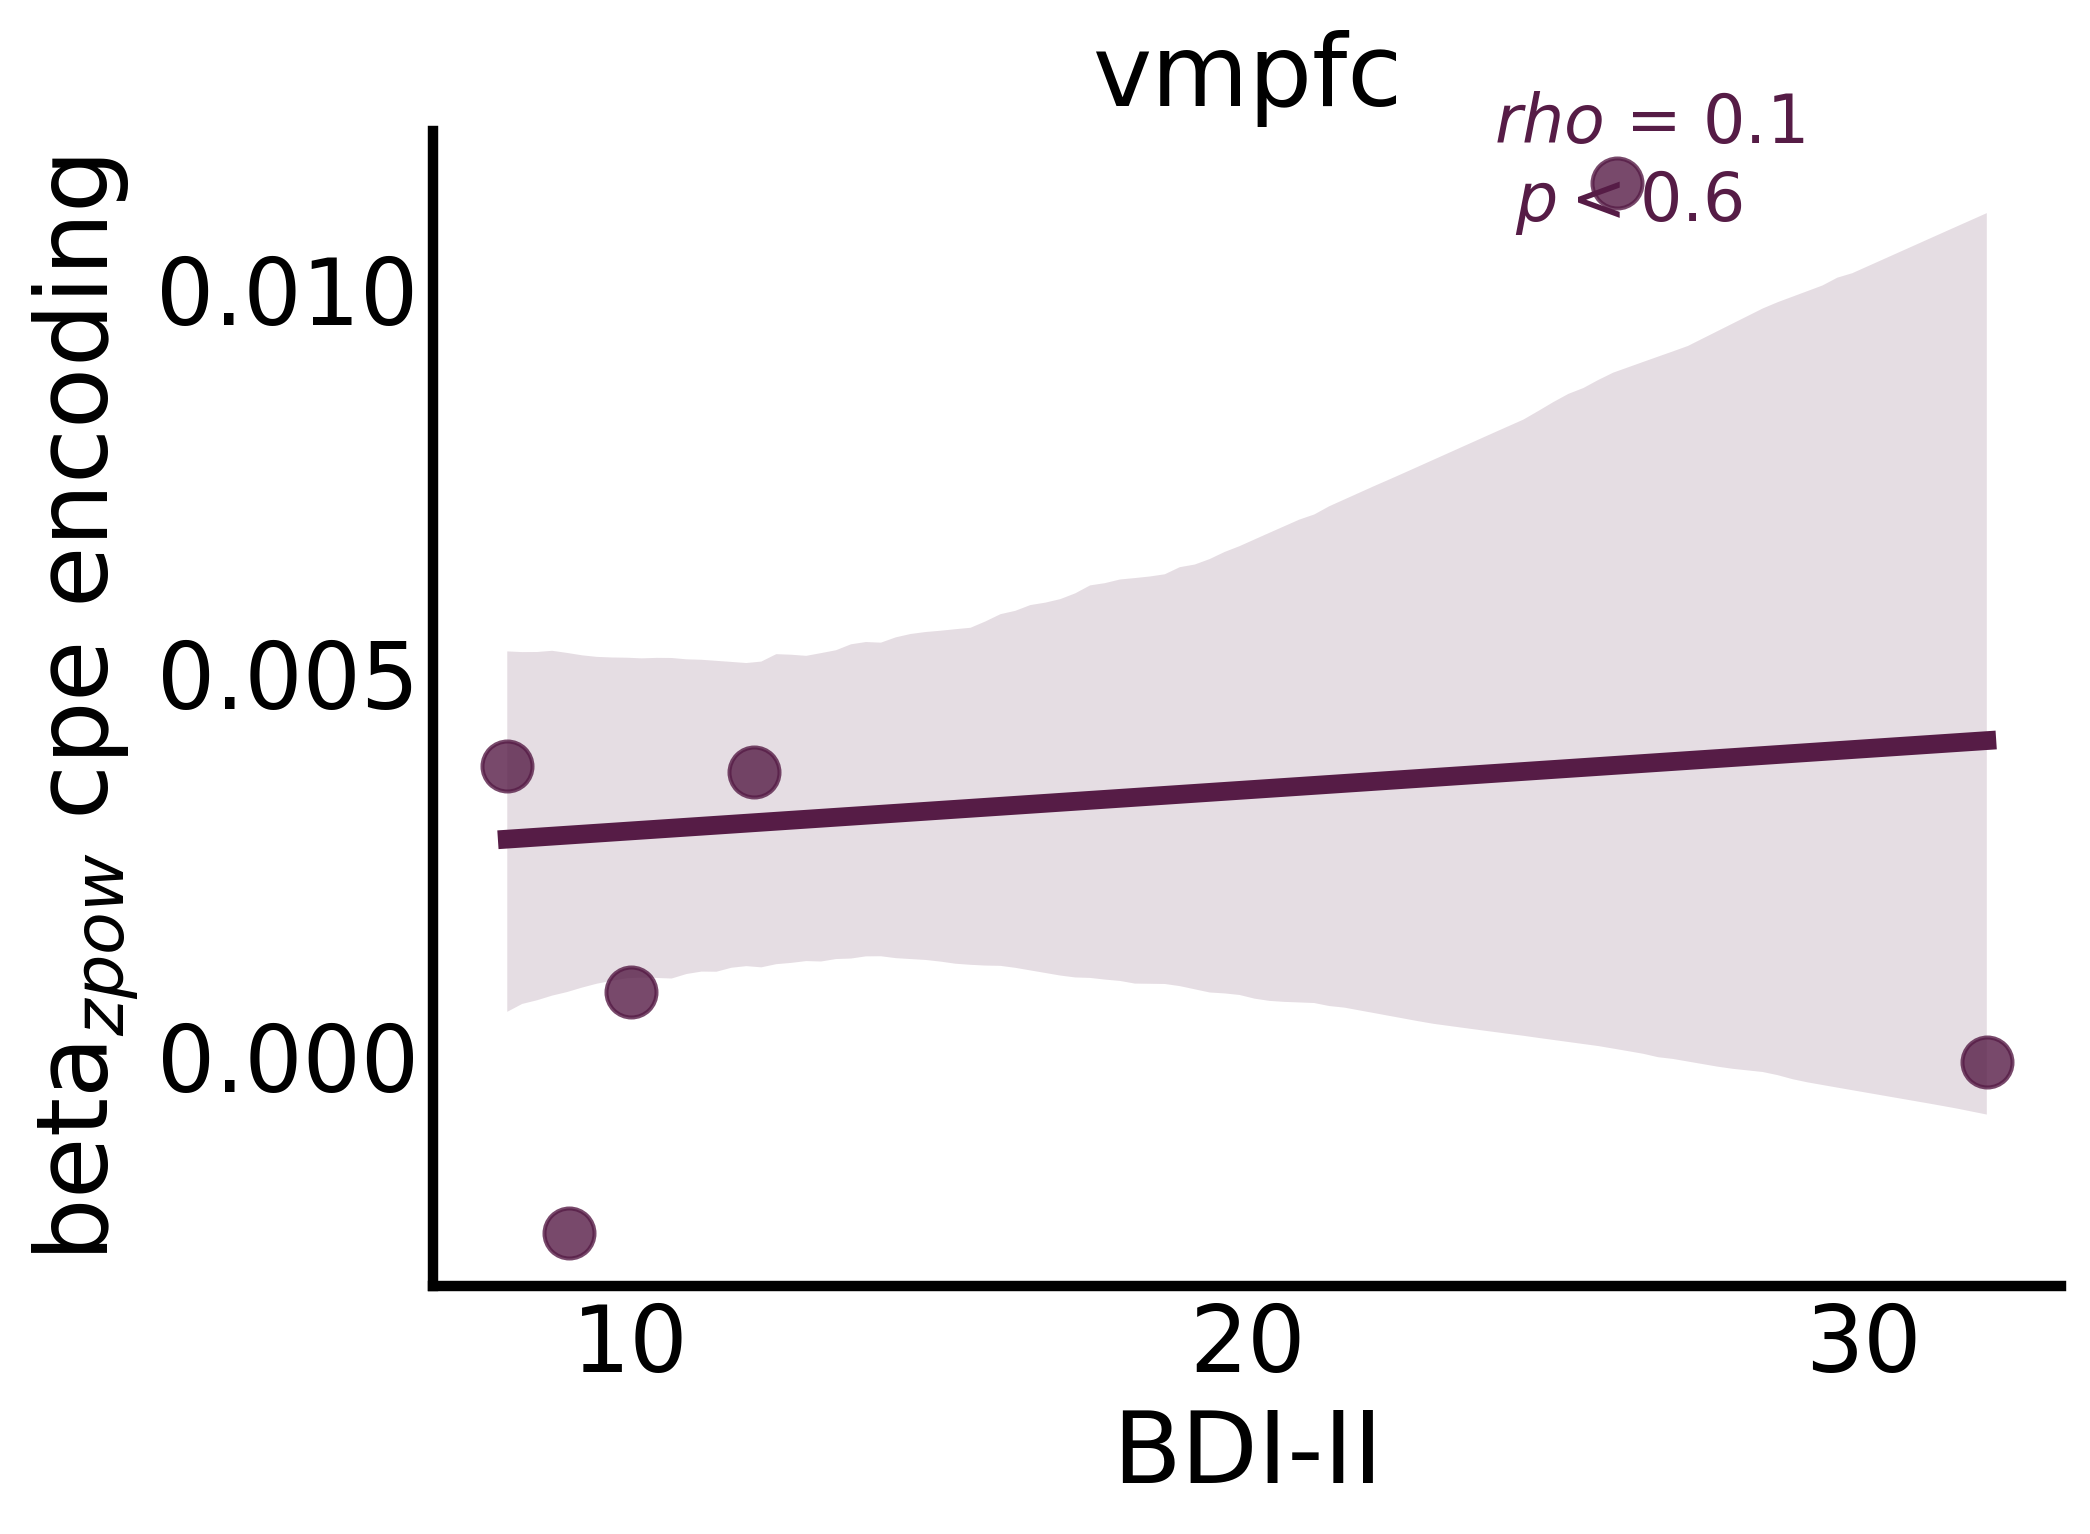

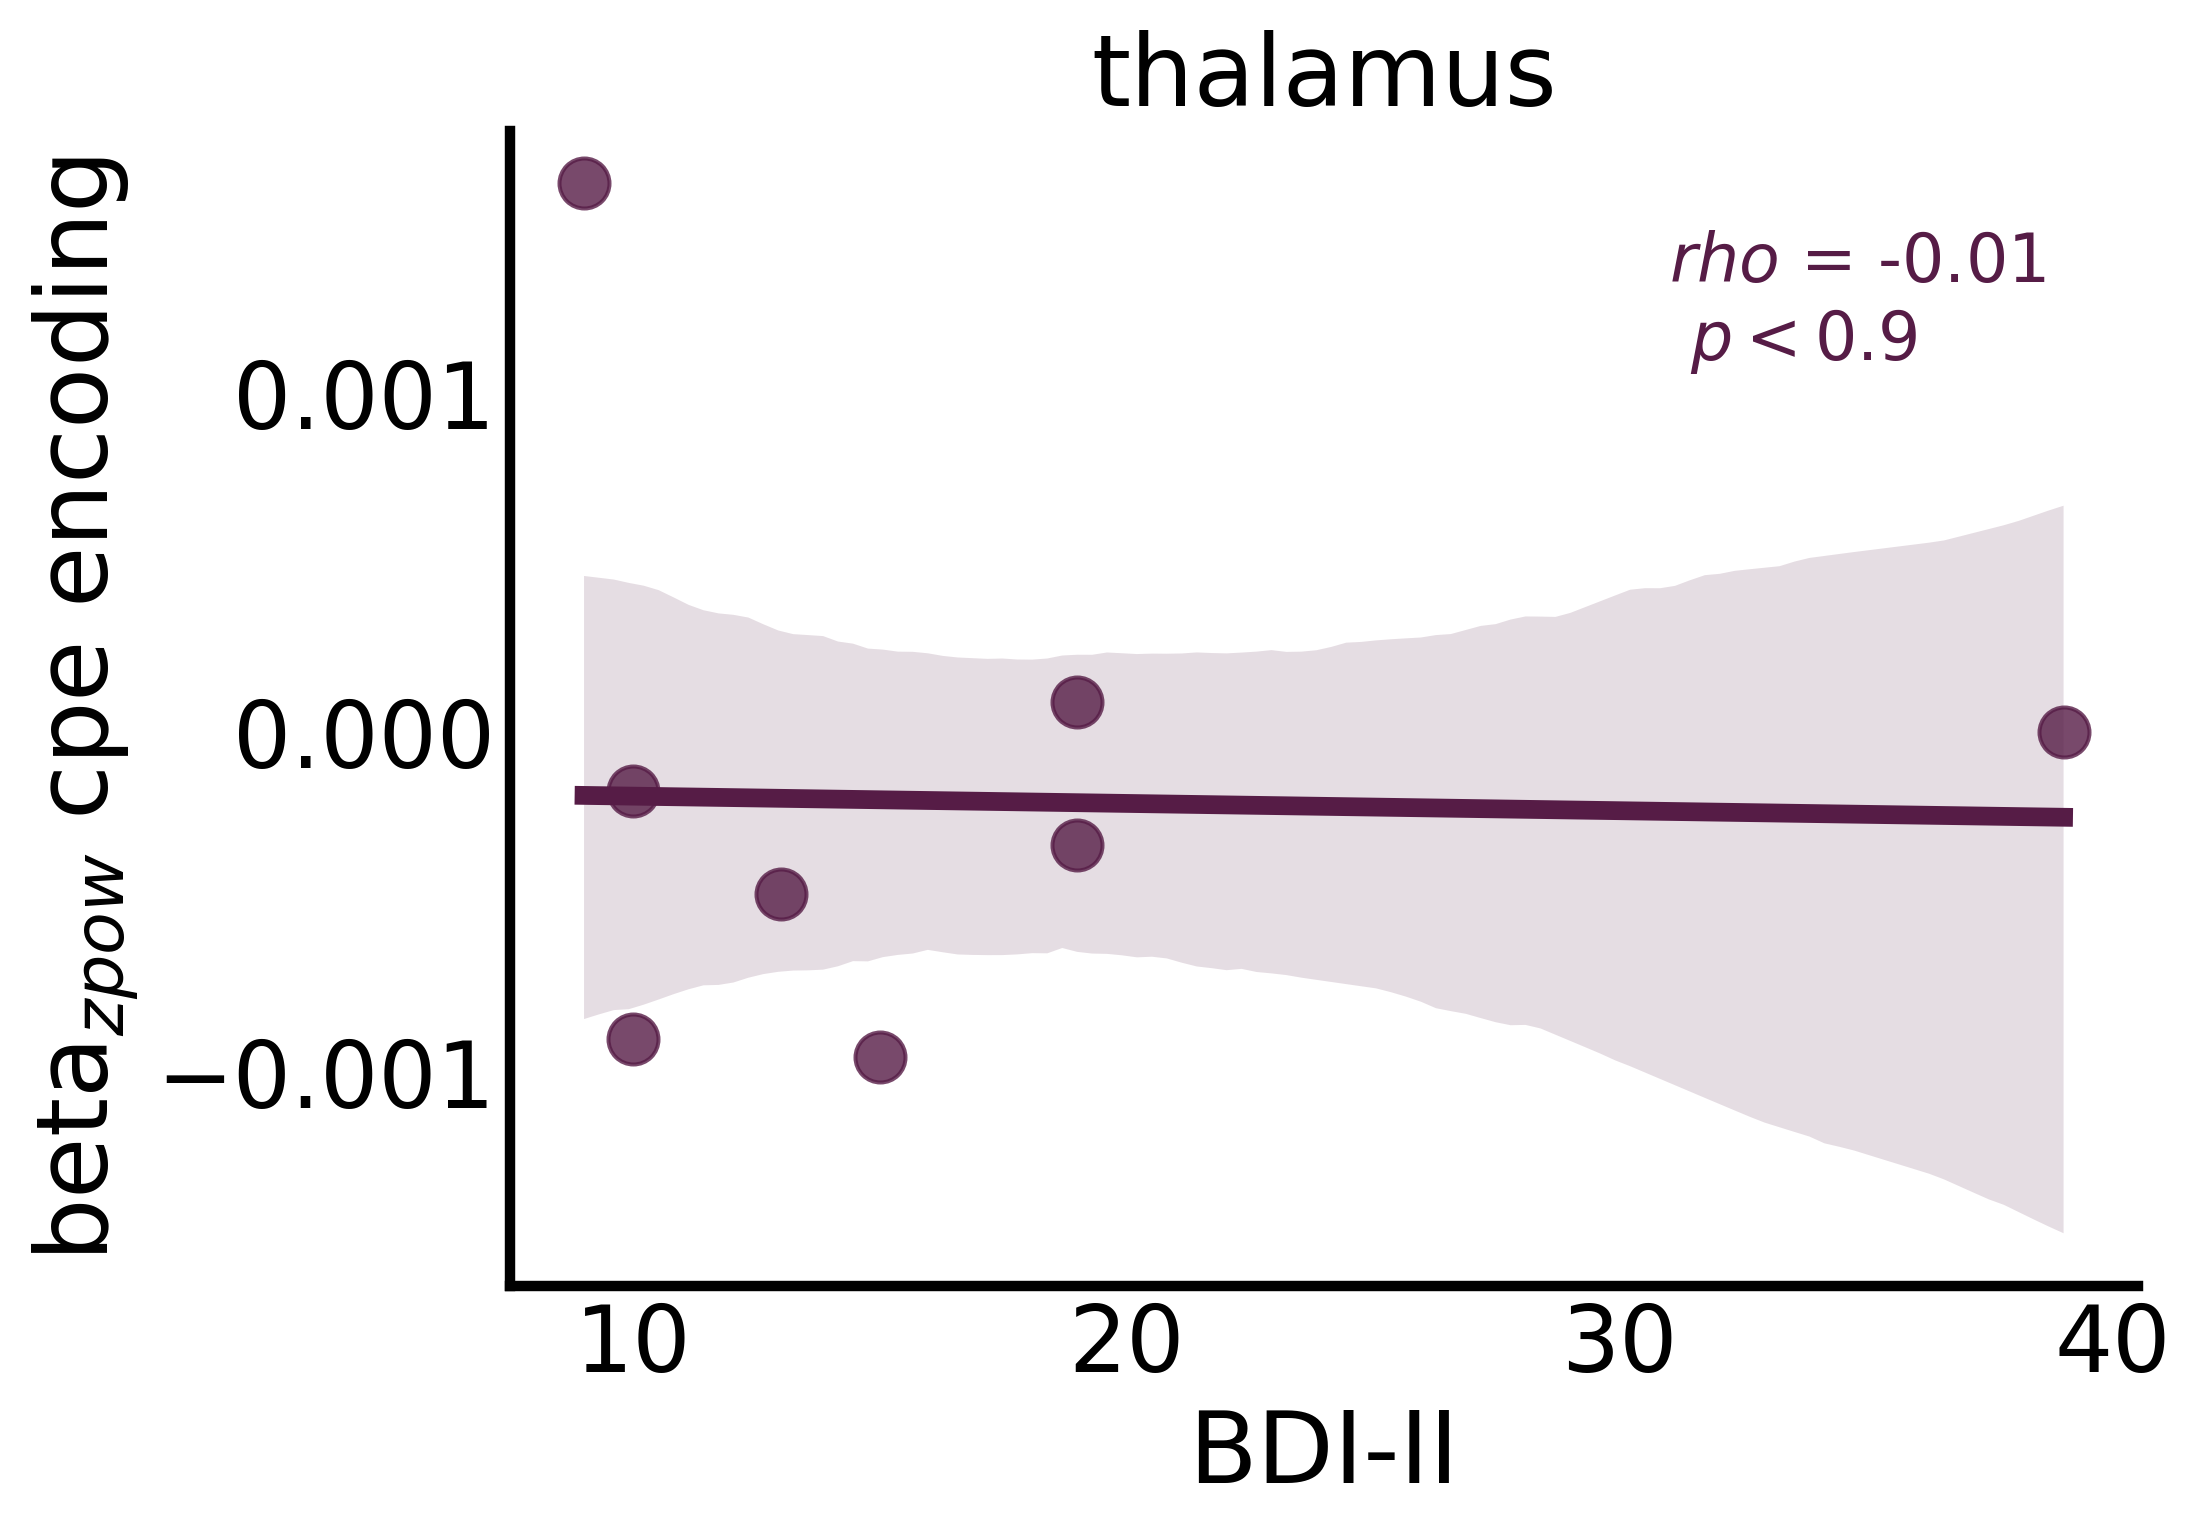

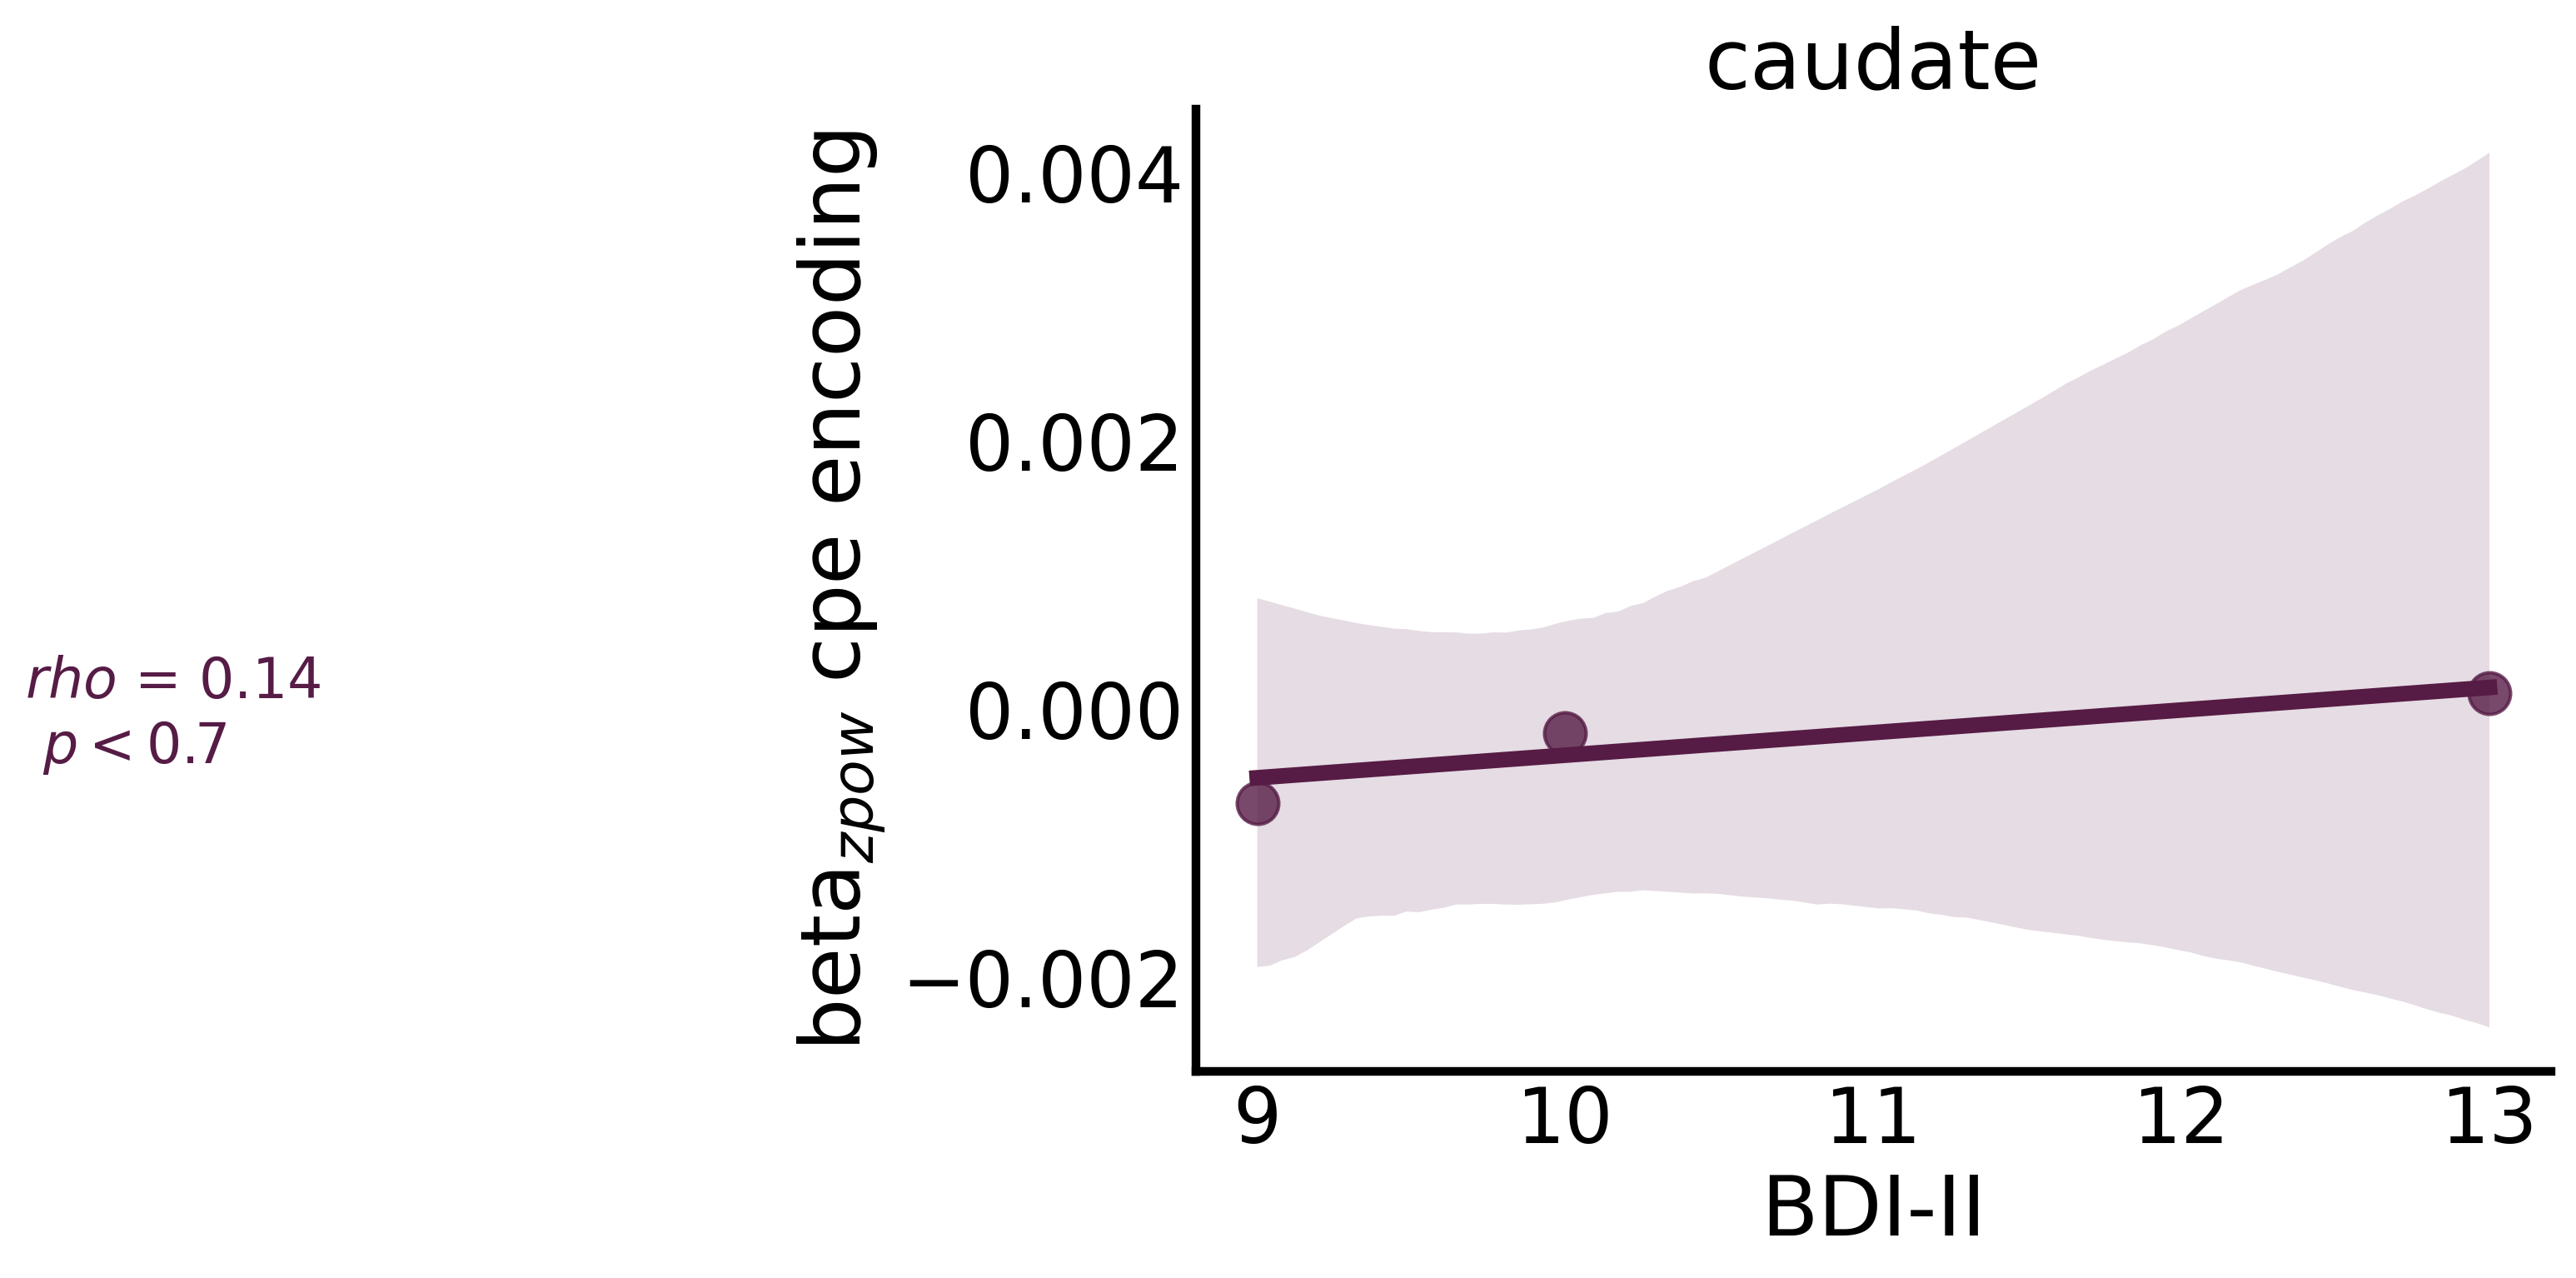

In [339]:

for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,
                fit_reg=True,color = '#561C46') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#561C46',edgecolor='#561C46',alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) #,width=1.5)
    plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')

    plt.text(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),4)-0.0005,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < $'+f'{rho_p}',
             color='#561C46',fontsize=16)

#     plt.locator_params(axis='y', nbins=4)


# #     plt.text(30,(np.round(max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),4)),
#     plt.text(30,float(str(max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE))[:4]),
#              r'$rho$ = '+f'{np.round(rho,2)} '+'\n '+r'$p < $'+f'{np.round(rho_p,4)}',
#              color='#00467e',fontsize=16)

    plt.title(f'{roi}',fontsize=24)

    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_HFA-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# BDI Plots

In [14]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'
rand_eff_var = 'unique_reref_ch'
bdi_fit = fit_mixed_model(hfa_reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       band_pow   
No. Observations:        250396        Method:                   ML         
No. Groups:              1813          Scale:                    0.0231     
Min. group size:         65            Log-Likelihood:           111949.5740
Max. group size:         148           Converged:                No         
Mean group size:         138.1                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         -0.011    0.005 -1.949 0.051 -0.021  0.000
decisionCPE                        0.001    0.005  0.270 0.787 -0.008  0.010
bdi                                0.000    0.000  0.364 0.716 -0.001  0.001
decisionCPE:bdi    

In [15]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

['decisionCPE', 'bdi', 'decisionCPE:bdi']

In [16]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [hfa_reg_df.roi[hfa_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [17]:
bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_decisionCPE  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.030306         0.019981   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.010601        -0.029454   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.029824        -0.013579   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.037106        -0.004615   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.056360        -0.045470   
...      ...            ...                  ...        ...              ...   
1808   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5  -0.028374        -0.005985   
1809   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.037177         0.045659   
1810   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.149839         0.071124   
1811   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.144023         0.083716   
1812   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.079755         0.118463   

       raw_bdi  raw_decisionCPE:bdi    roi  bdi  
0    -0.000942            -0.001114    acc   14  
1    -0.000228             0.001535  dmpfc   14  
2    -0.000834             0.000659    acc   14  
3    -0.001072             0.000171    acc   14  
4    -0.001520             0.002291  dmpfc   14  
...        ...                  ...    ...  ...  
1808  0.001373             0.000397    ofc    9  
1809 -0.001820            -0.002895    ofc    9  
1810 -0.007274            -0.004578    ofc    9  
1811 -0.007000            -0.005364    ofc    9  
1812 -0.003916            -0.007497  vlpfc    9  

[1813 rows x 9 columns]

In [18]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


0.00011789019080452044

In [19]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [20]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=0.21793648588925293, pvalue=0.8277100464980827, df=192),
 'dmpfc': TtestResult(statistic=0.924971339848738, pvalue=0.3560178294674977, df=215),
 'hpc': TtestResult(statistic=1.0216373446877083, pvalue=0.3087934712778655, df=134),
 'sts': TtestResult(statistic=0.45500761093249736, pvalue=0.6497616278422267, df=150),
 'amy': TtestResult(statistic=-3.0116547988373505, pvalue=0.0032361332495384467, df=108),
 'parietal': TtestResult(statistic=0.4842428605485191, pvalue=0.6327927305395289, df=23),
 'angular': TtestResult(statistic=2.3073136069192204, pvalue=0.038137592960204365, df=13),
 'stg': TtestResult(statistic=-0.5162332653955807, pvalue=0.606842646937036, df=99),
 'premotor': TtestResult(statistic=0.48740343197312613, pvalue=0.6390474268425561, df=8),
 'mcc': TtestResult(statistic=-1.9964060135296389, pvalue=0.05606446325942696, df=27),
 'fusiform': TtestResult(statistic=1.734605566530747, pvalue=0.09990175082061659, df=18),
 'itg': TtestResult(statistic=

In [37]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

{'acc': TtestResult(statistic=0.805474715927277, pvalue=0.42154219045139774, df=192),
 'dmpfc': TtestResult(statistic=1.611949720075456, pvalue=0.10843983752871551, df=215),
 'hpc': TtestResult(statistic=1.5184855671242297, pvalue=0.13124788624308836, df=134),
 'sts': TtestResult(statistic=0.7787496051000757, pvalue=0.4373540095362266, df=150),
 'amy': TtestResult(statistic=-2.4037361796906356, pvalue=0.01793175210069314, df=108),
 'parietal': TtestResult(statistic=0.643309219702509, pvalue=0.5263861359059097, df=23),
 'angular': TtestResult(statistic=2.6460581010224216, pvalue=0.02016236734282244, df=13),
 'stg': TtestResult(statistic=-0.2558760708847349, pvalue=0.798577437404209, df=99),
 'premotor': TtestResult(statistic=0.6340294375176744, pvalue=0.5437605177327041, df=8),
 'mcc': TtestResult(statistic=-1.7745447749409686, pvalue=0.08725078241992928, df=27),
 'fusiform': TtestResult(statistic=2.136291714881893, pvalue=0.0466420947323656, df=18),
 'itg': TtestResult(statistic=0.9715

In [23]:
# bonferr_alpha = 0.05/len(roi_order)
bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

0.0017857142857142859

In [24]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


sig ROIs after multiple comp correction:  [('smg', 3.802833016366051e-05)]


In [25]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




sig ROIs after multiple comp correction:  [('smg', 1.0634890972716761e-05)]


In [26]:
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [38]:
roi_bdi_plot_data = bdi_plot_data.copy()
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


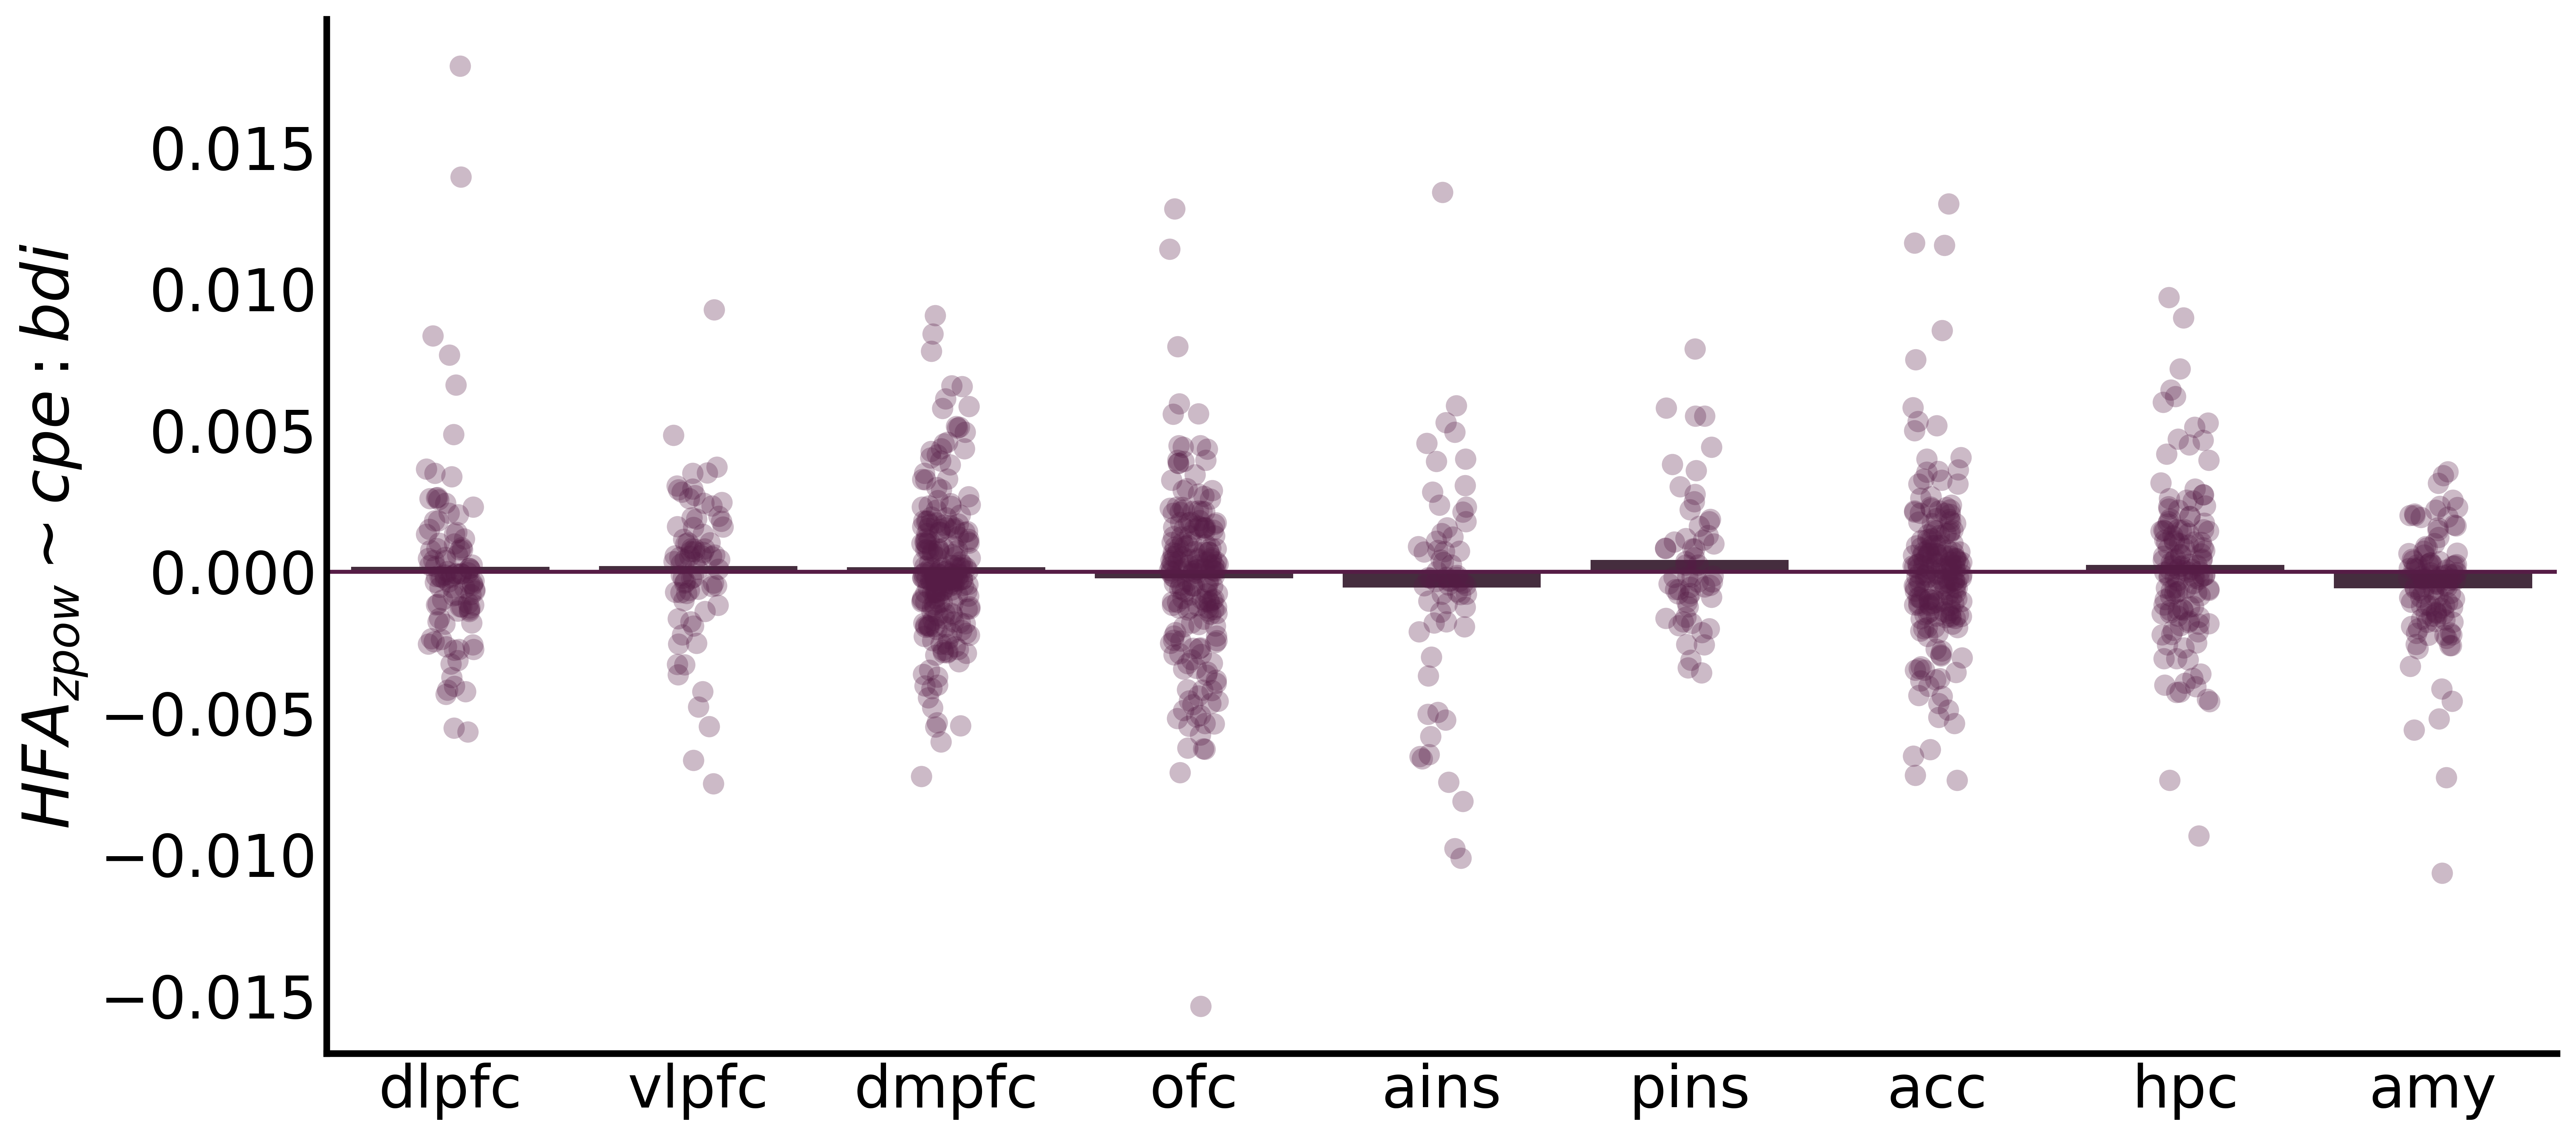

In [36]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 7),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/hfa_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#             y='elec_bCPE',
            color = '#561C46',
            saturation=0.4,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#               y='elec_bCPE',
            color = '#561C46',
            alpha=.3,
              dodge=True,
            order=roi_order,
            size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)

# plt.ylim([-0.011,0.01])
ax.set(xlabel=None)
plt.tick_params(length=0)
plt.ylabel(r'$HFA_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=8)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/HFA_CPEBDIINT{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
palette=dict(Low="#3f2755", High="#125549")